<a href="https://colab.research.google.com/github/jake-wittman/DiabetesML/blob/main/DiabetesML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/DiabetesML'

# Install necessary libraries, excluding pmdarima for now due to compatibility issues
!pip install pandas prophet statsmodels torch joblib scipy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy
from sklearn.preprocessing import StandardScaler
import pickle
import os
from itertools import combinations
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
# pmdarima import is removed due to persistent compatibility issues

warnings.filterwarnings('ignore')
#import cache_magic

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/DiabetesML


In [2]:
     import pandas as pd
     import numpy as np
     file_path = '/content/drive/MyDrive/reorganized_ts.parquet' # Replace with your file path
     df = pd.read_parquet(file_path)
     # Identify columns that start with "source"
columns_to_drop = [col for col in df.columns if col.startswith('source')]

# Drop these columns from the DataFrame
# axis=1 indicates that we are dropping columns, not rows
# inplace=True modifies the DataFrame directly
df.drop(columns=columns_to_drop, axis=1, inplace=True)



In [3]:
# prompt: Create a code chunk that subsets the data by uuid. Give me a random subset of 200 UUIDs and overwrite the original df

# Get a random subset of unique UUIDs
subset_uuids = np.random.choice(df['uuid'].unique(), size=5, replace=False)

# Get another subset that's larger for some other EDA type stuff
subset_uuids2 = np.random.choice(df['uuid'].unique(), size=100, replace=False)

df_full = df.copy()
# Subset the DataFrame to include only rows with the selected UUIDs
df_larger_sample = df[df['uuid'].isin(subset_uuids)].copy()
# Subset the DataFrame to include only rows with the selected UUIDs
df = df[df['uuid'].isin(subset_uuids)].copy()

# EDA

Plot some random time series to see what we have

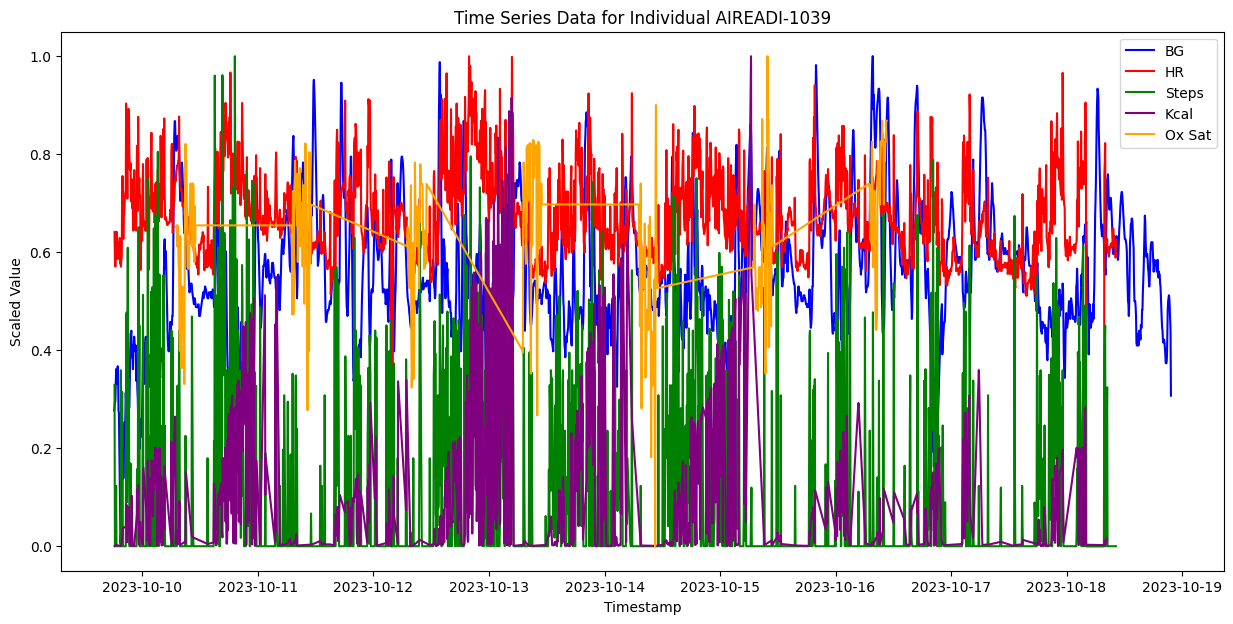

In [4]:
# Prompt: This data is a time series data for a bunch of people (uuid identifies the people). It contains time series of blood glucose (bg), heart rate (hr), steps, calories burned (kcal) and oxygen saturation (ox_sat_percent). Give me a way to plot a random individuals time series for each of these variables so I can inspect the  data. Rescale the variables so they can all be put on one plot and map them to different colors. Provide sparing code comments


# Select a random UUID
random_uuid = np.random.choice(df_larger_sample['uuid'].unique())
random_individual_df = df_larger_sample[df_larger_sample['uuid'] == random_uuid].copy()

# Define columns to plot
cols_to_plot = ['bg', 'hr', 'steps', 'kcal', 'ox_sat_percent']

# Normalize the data for plotting on a single axis
for col in cols_to_plot:
  if col in random_individual_df.columns:
    # Check if the column contains non-null values
    if not random_individual_df[col].isnull().all():
        min_val = random_individual_df[col].min()
        max_val = random_individual_df[col].max()
        if max_val != min_val: # Avoid division by zero
            random_individual_df[f'{col}_scaled'] = (random_individual_df[col] - min_val) / (max_val - min_val)
        else:
             random_individual_df[f'{col}_scaled'] = 0.5 # Assign a mid-range value if all values are the same
    else:
        random_individual_df[f'{col}_scaled'] = np.nan # Assign NaN if the column is all null


# Plotting
plt.figure(figsize=(15, 7))
# Change 'ts' to 'timestamp' in the x argument
sns.lineplot(data=random_individual_df, x='timestamp', y='bg_scaled', label='BG', color='blue')
sns.lineplot(data=random_individual_df, x='timestamp', y='hr_scaled', label='HR', color='red')
sns.lineplot(data=random_individual_df, x='timestamp', y='steps_scaled', label='Steps', color='green')
sns.lineplot(data=random_individual_df, x='timestamp', y='kcal_scaled', label='Kcal', color='purple')
sns.lineplot(data=random_individual_df, x='timestamp', y='ox_sat_percent_scaled', label='Ox Sat', color='orange')

plt.title(f'Time Series Data for Individual {random_uuid}')
plt.xlabel('Timestamp')
plt.ylabel('Scaled Value')
plt.legend()
plt.show()

Some individuals have data far outside the 10 day range. This code attempts to extract only the 10 day range where all data are available

In [5]:
# Identify individuals with more than 10 days of data for any variable
# Assuming 'timestamp' is already in datetime format or can be easily converted
# Ensure 'timestamp' is datetime type
df['timestamp'] = pd.to_datetime(df['timestamp'])

# List of measurement columns to check for duration
# Keep the check on all columns to identify which individuals need trimming
measurement_cols = ['bg', 'hr', 'steps', 'kcal', 'ox_sat_percent']

long_duration_uuids_vars_list = []

# Iterate through each uuid and check duration for each measurement column
for uuid in df['uuid'].unique():
    df_uuid = df[df['uuid'] == uuid].copy()

    if df_uuid.empty:
        continue

    for col in measurement_cols:
        # Filter out rows where the measurement is missing for this column
        df_uuid_col = df_uuid[df_uuid[col].notna()]

        if not df_uuid_col.empty:
            # Calculate the duration in days for this variable and uuid
            duration_days = (df_uuid_col['timestamp'].max() - df_uuid_col['timestamp'].min()).days

            if duration_days > 10:
                long_duration_uuids_vars_list.append({'uuid': uuid, 'variable': col, 'duration_days': duration_days})

# Convert the list of dictionaries to a DataFrame
long_duration_uuids_vars = pd.DataFrame(long_duration_uuids_vars_list)

print("\nIndividuals and variables with more than 10 days of data:")
if not long_duration_uuids_vars.empty:
    print(long_duration_uuids_vars)

    # Identify unique uuids that need trimming for at least one variable
    # Add a check here to ensure the DataFrame is not empty before accessing 'uuid'
    uuids_to_trim = long_duration_uuids_vars['uuid'].unique()
    print(f"\nUnique UUIDs that need trimming: {uuids_to_trim}")
else:
    print("No individuals found with more than 10 days of data for any variable.")
    # If the DataFrame is empty, there are no uuids to trim
    uuids_to_trim = []
    print(f"\nUnique UUIDs that need trimming: {uuids_to_trim}")


# Function to trim data for a specific uuid based on the start and end of BG data
def trim_data_to_bg_window(df, uuid):
    individual_df = df[df['uuid'] == uuid].copy()
    if individual_df.empty:
        return individual_df # Return empty if no data for this uuid

    # Filter for non-null 'bg' values to find the start and end of the BG series
    bg_data = individual_df[individual_df['bg'].notna()].copy()

    if bg_data.empty:
        # If there is no BG data for this uuid, no trimming based on BG is possible
        print(f"Warning: No 'bg' data found for uuid {uuid}. Cannot trim based on BG.")
        return pd.DataFrame(columns=df.columns) # Return empty DataFrame if no BG data

    # Find the earliest and latest timestamp among non-null BG values
    min_timestamp_bg = bg_data['timestamp'].min()
    max_timestamp_bg = bg_data['timestamp'].max()

    # Filter the entire individual's data to include only timestamps within the BG window
    trimmed_individual_df = individual_df[(individual_df['timestamp'] >= min_timestamp_bg) &
                                          (individual_df['timestamp'] <= max_timestamp_bg)].copy()

    return trimmed_individual_df

# Create a new DataFrame with trimmed data for the identified uuids
# And keep original data for uuids that didn't need trimming
trimmed_df_list = []

# Process uuids that need trimming
# This loop will now correctly handle the case where uuids_to_trim is empty
for uuid in uuids_to_trim:
    # Use the new BG-focused trimming function
    trimmed_individual_df = trim_data_to_bg_window(df, uuid)
    if not trimmed_individual_df.empty:
        trimmed_df_list.append(trimmed_individual_df)


# Add data for uuids that do not need trimming
# This approach assumes that uuids_to_trim correctly identifies all UUIDs that need trimming.
# We can filter the original df to get the data for uuids not in uuids_to_trim.
# Convert arrays to sets before using the difference method
uuids_not_to_trim = set(df['uuid'].unique()).difference(set(uuids_to_trim))
df_not_trimmed = df[df['uuid'].isin(uuids_not_to_trim)].copy()
if not df_not_trimmed.empty:
    trimmed_df_list.append(df_not_trimmed)

# Concatenate all data back into a single DataFrame
# Handle the case where trimmed_df_list might be empty if no data exists after filtering/trimm ing
if trimmed_df_list:
    df_trimmed = pd.concat(trimmed_df_list, ignore_index=True)
    print("\nDataFrame after trimming long duration data:")
    print(df_trimmed)
else:
    df_trimmed = pd.DataFrame(columns=df.columns) # Create an empty DataFrame with original columns
    print("\nNo data remaining after processing and trimming.")

# Ensure df is updated to df_trimmed for subsequent cells
df = df_trimmed.copy()


Individuals and variables with more than 10 days of data:
           uuid variable  duration_days
0  AIREADI-1186       hr             12
1  AIREADI-1186    steps             12
2  AIREADI-1186     kcal             11
3  AIREADI-7161       hr             15
4  AIREADI-7161    steps             15
5  AIREADI-7280       hr             14
6  AIREADI-7280    steps             14
7  AIREADI-7348       hr             13
8  AIREADI-7348    steps             13

Unique UUIDs that need trimming: ['AIREADI-1186' 'AIREADI-7161' 'AIREADI-7280' 'AIREADI-7348']

DataFrame after trimming long duration data:
                      timestamp          uuid      bg         hr      kcal  \
0     2024-03-15 17:42:57+00:00  AIREADI-1186  110.28  69.133333  1.166184   
1     2024-03-15 17:47:57+00:00  AIREADI-1186  112.58  67.533333  1.144470   
2     2024-03-15 17:52:57+00:00  AIREADI-1186  119.02  70.400000  1.122756   
3     2024-03-15 17:57:57+00:00  AIREADI-1186  112.26  65.733333  1.101042   
4     202

Visualize some of the trimmed data


Visualizing data for individuals whose data was trimmed:


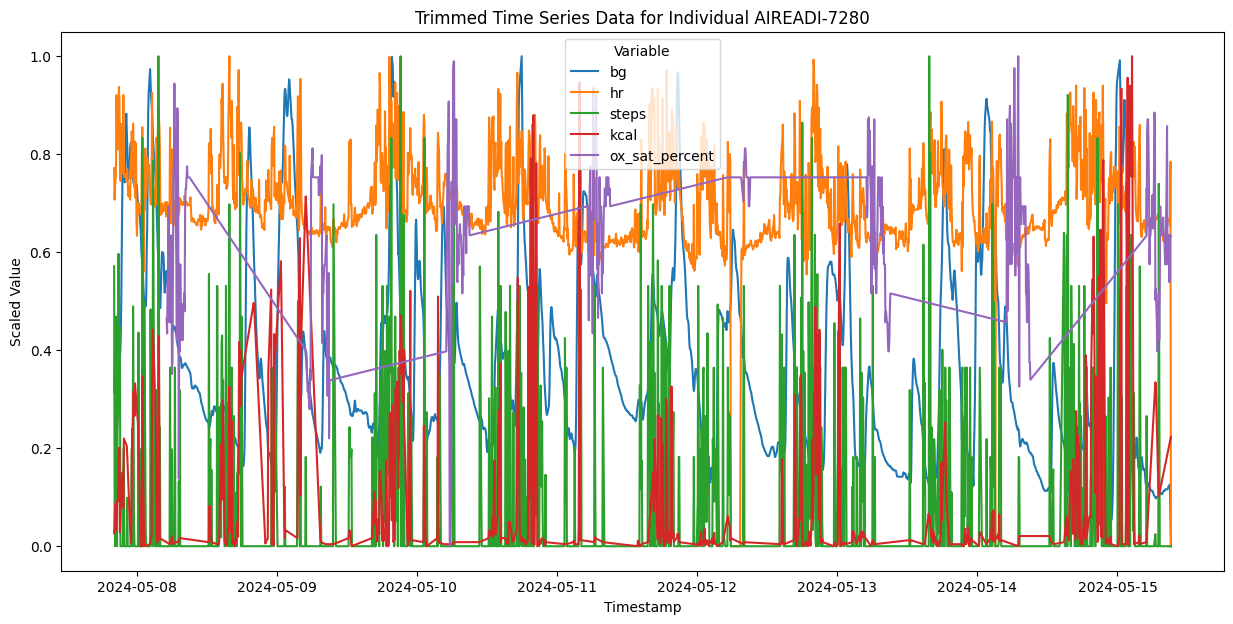

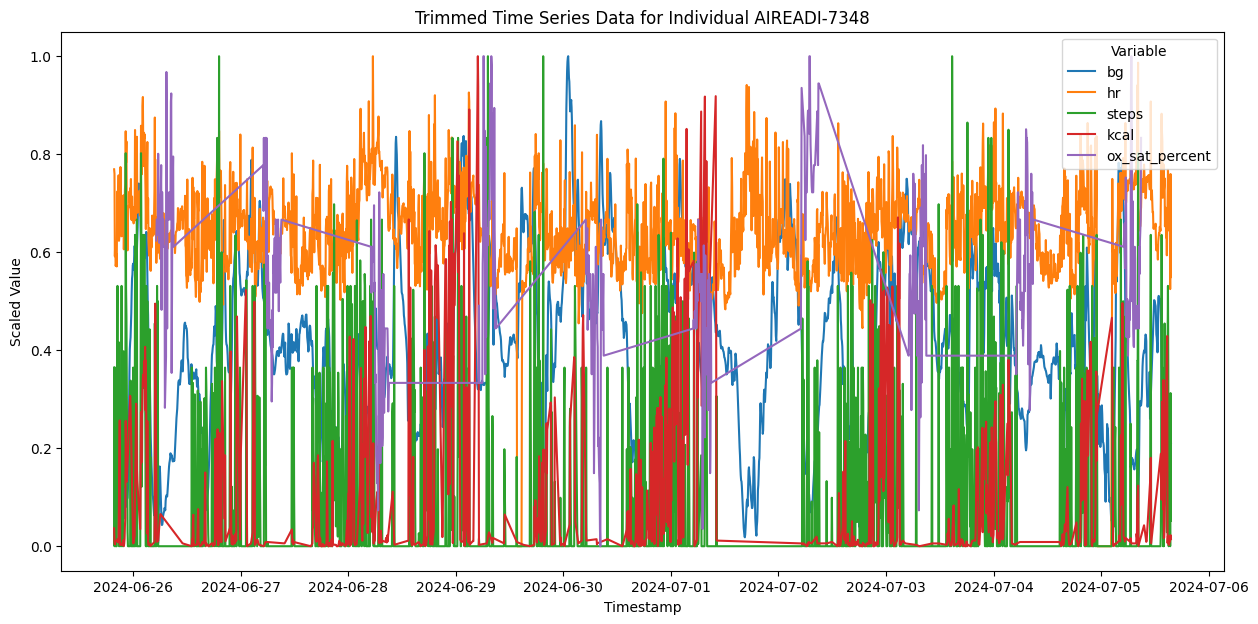

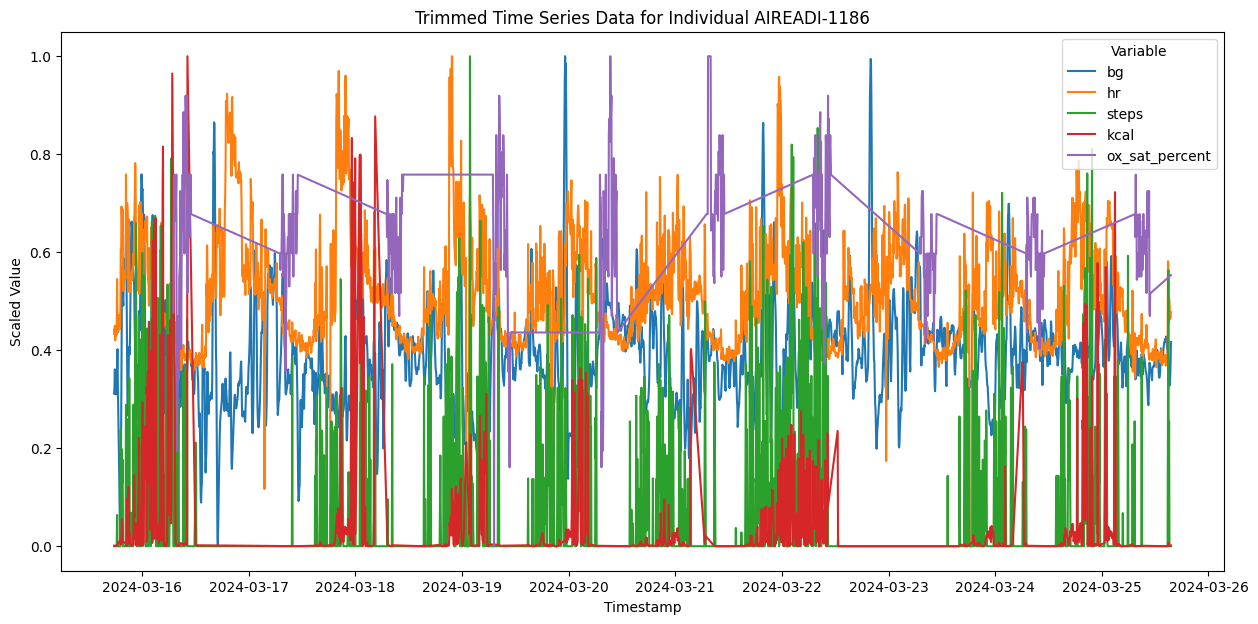

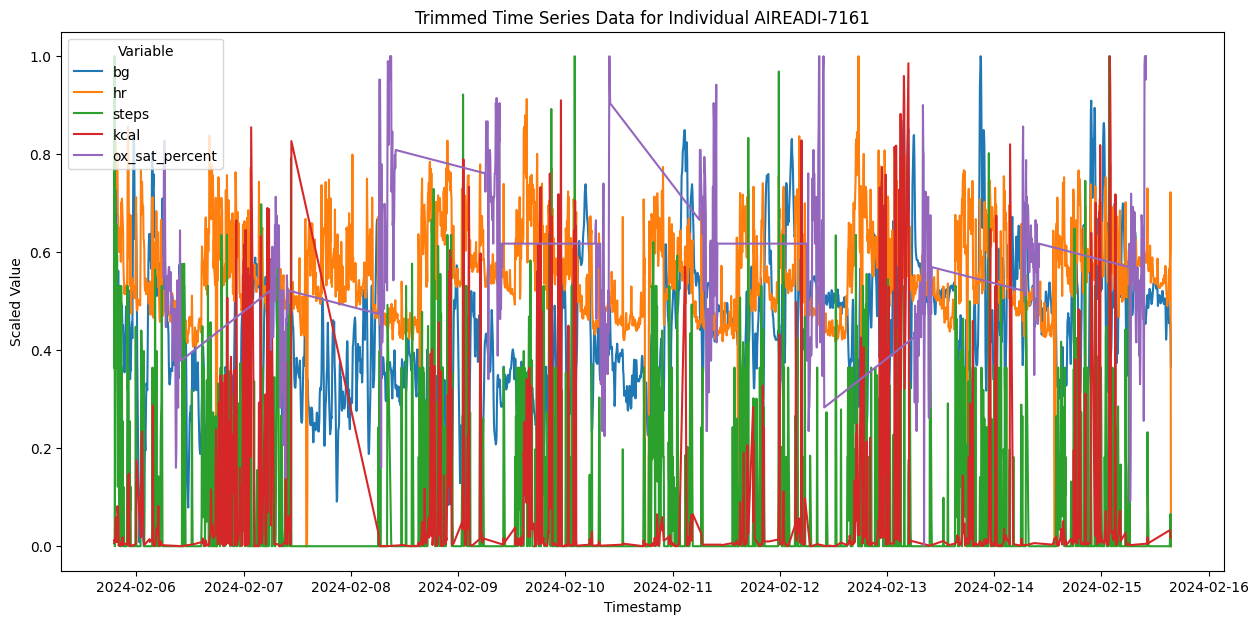

In [6]:


# Visualize the data for individuals whose data was trimmed
print("\nVisualizing data for individuals whose data was trimmed:")

# Define columns to plot
cols_to_plot = ['bg', 'hr', 'steps', 'kcal', 'ox_sat_percent']

# Select a random subset of 5 UUIDs from the ones that were trimmed
# Ensure we only sample if there are enough uuids to trim
if len(uuids_to_trim) > 0:
    uuids_to_visualize = np.random.choice(uuids_to_trim, size=min(5, len(uuids_to_trim)), replace=False)
else:
    uuids_to_visualize = []
    print("No UUIDs needed trimming, skipping visualization of trimmed data.")


for uuid in uuids_to_visualize:
    # Use df_trimmed for visualization (df was updated to df_trimmed in the previous cell)
    individual_df = df[df['uuid'] == uuid].copy()

    if individual_df.empty:
        print(f"No data available for UUID {uuid} in the trimmed DataFrame. Skipping visualization.")
        continue

    # Melt the DataFrame for easier plotting with seaborn
    # Only melt the columns that exist in the individual_df and are in cols_to_plot
    cols_to_melt = [col for col in cols_to_plot if col in individual_df.columns]
    if not cols_to_melt:
        print(f"No relevant measurement columns found for UUID {uuid} in trimmed data. Skipping visualization.")
        continue

    individual_melted = individual_df.melt(id_vars=['uuid', 'timestamp'], value_vars=cols_to_melt, var_name='variable', value_name='value')

    # Normalize the data for plotting on a single axis for this individual
    # Apply normalization within the group for each variable
    def normalize_group(group):
        min_val = group['value'].min()
        max_val = group['value'].max()
        # Check for NaN values before calculating min/max and performing normalization
        if group['value'].isnull().all():
            group['value_scaled'] = np.nan
        elif max_val != min_val:
            group['value_scaled'] = (group['value'] - min_val) / (max_val - min_val)
        else:
            group['value_scaled'] = 0.5  # Assign a mid-range value if all values are the same and not all null
        return group

    # Apply normalization only if individual_melted is not empty
    if not individual_melted.empty:
         individual_melted = individual_melted.groupby('variable', group_keys=False).apply(normalize_group).reset_index(drop=True)
    else:
         print(f"Melted DataFrame is empty for UUID {uuid}. Skipping plotting.")
         continue


    plt.figure(figsize=(15, 7))
    # Use individual_melted for plotting
    sns.lineplot(data=individual_melted, x='timestamp', y='value_scaled', hue='variable')

    plt.title(f'Trimmed Time Series Data for Individual {uuid}')
    plt.xlabel('Timestamp')
    plt.ylabel('Scaled Value')
    plt.legend(title='Variable')
    plt.show()

ACF/ PACF Plots

ACF/PACF Analysis Summary
Dataset shape: (18610, 7)
Number of individuals: 5
Variables to analyze: ['bg', 'hr', 'steps', 'kcal', 'ox_sat_percent']
Minimum observations per individual: 50

bg:
  - Total non-null observations: 13335
  - Overall mean: 147.8464
  - Overall std: 51.0729
  - Valid individuals: 5
  - Average observations per valid individual: 2667.0
  - Range of observations per individual: 2174 - 2855
  - Range of individual std deviations: 18.4370 - 63.3740

hr:
  - Total non-null observations: 18429
  - Overall mean: 63.2891
  - Overall std: 36.9466
  - Valid individuals: 5
  - Average observations per valid individual: 3685.8
  - Range of observations per individual: 2499 - 4365
  - Range of individual std deviations: 16.8072 - 39.6643

steps:
  - Total non-null observations: 18471
  - Overall mean: 11.5165
  - Overall std: 26.3746
  - Valid individuals: 5
  - Average observations per valid individual: 3694.2
  - Range of observations per individual: 2498 - 4367
  - Range

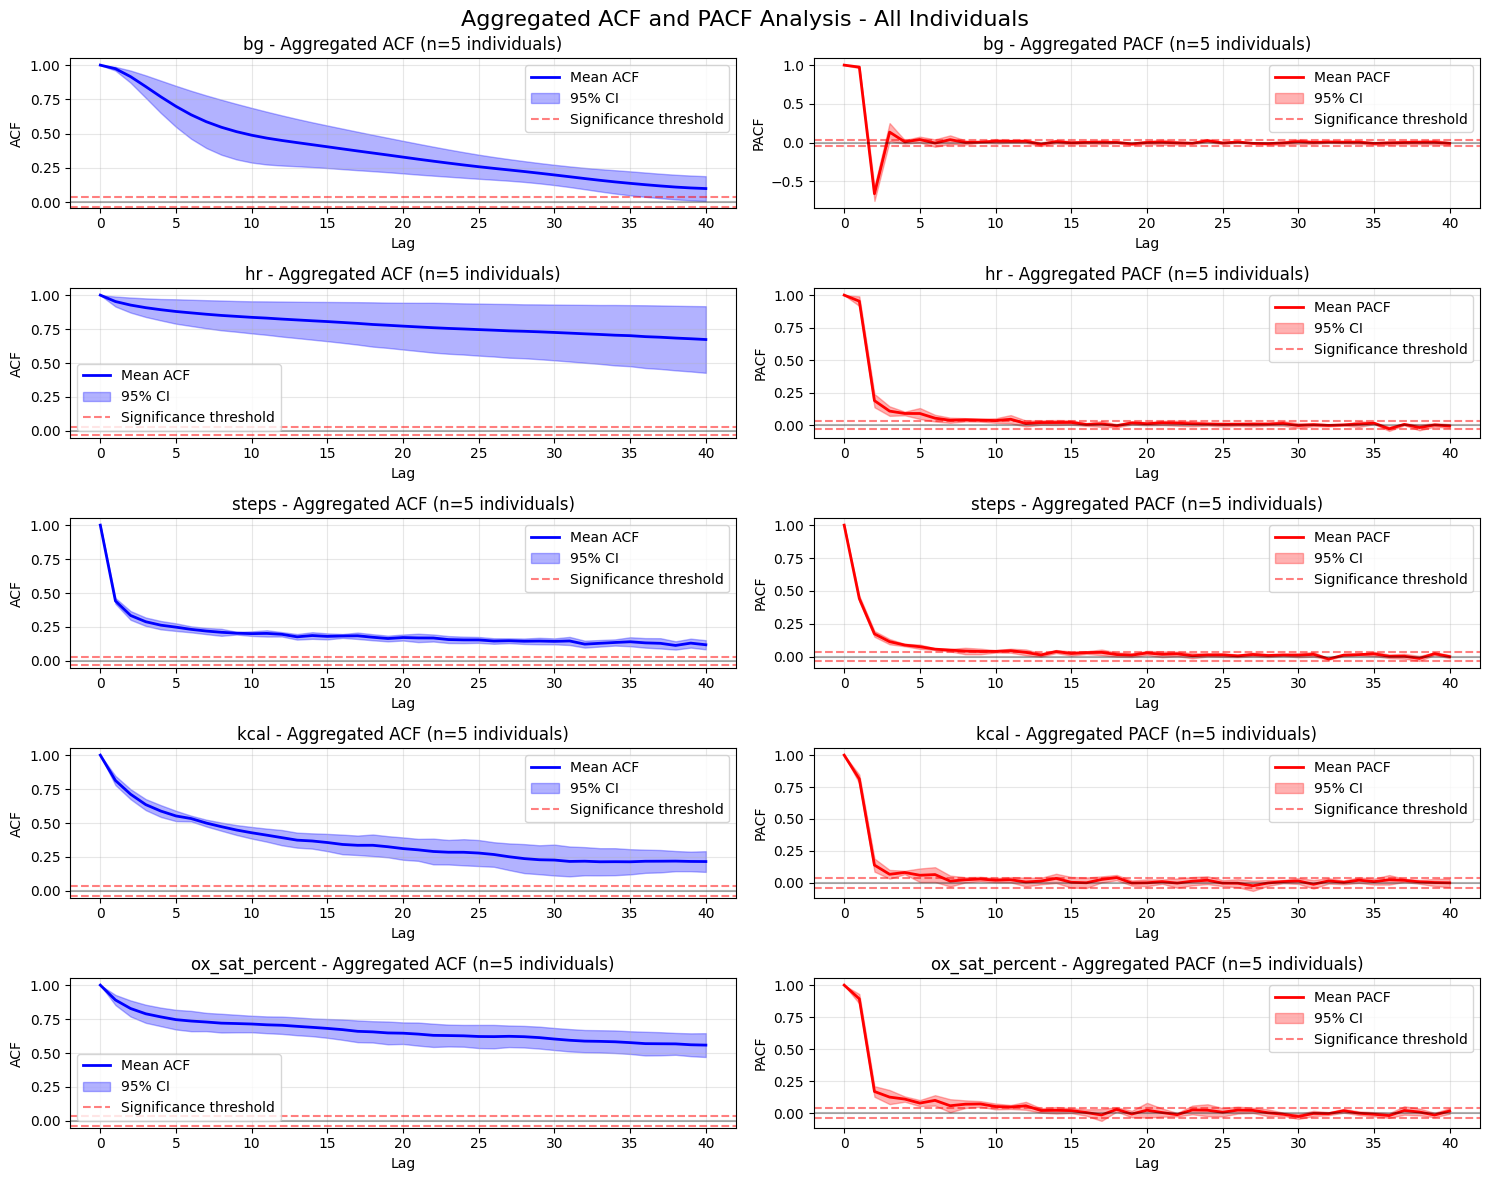

In [7]:



def preprocess_series(data, min_obs=50):
    """
    Preprocess time series data to handle common issues

    Parameters:
    -----------
    data : pandas.Series
        Time series data
    min_obs : int
        Minimum number of observations required

    Returns:
    --------
    pandas.Series or None
        Preprocessed data or None if invalid
    """
    # Remove NaN values
    clean_data = data.dropna()

    # Check minimum length
    if len(clean_data) < min_obs:
        return None

    # Check for constant values (no variation)
    if clean_data.nunique() <= 1:
        print(f"Warning: Series has constant values (std = {clean_data.std():.6f})")
        return None

    # Check for extremely low variation
    if clean_data.std() < 1e-10:
        print(f"Warning: Series has very low variation (std = {clean_data.std():.6f})")
        return None

    return clean_data

def safe_acf_pacf(data, max_lags=40):
    """
    Safely calculate ACF and PACF with error handling

    Parameters:
    -----------
    data : pandas.Series
        Time series data
    max_lags : int
        Maximum number of lags

    Returns:
    --------
    tuple : (acf_values, pacf_values) or (None, None) if calculation fails
    """
    try:
        # Adjust max_lags if data is too short
        effective_lags = min(max_lags, len(data) - 1, len(data) // 4)

        if effective_lags < 1:
            return None, None

        # Calculate ACF with different methods if needed
        try:
            acf_vals = acf(data, nlags=effective_lags, fft=True)
        except:
            # Fallback to non-FFT method
            acf_vals = acf(data, nlags=effective_lags, fft=False)

        # Calculate PACF with error handling
        try:
            pacf_vals = pacf(data, nlags=effective_lags, method='ols')
        except:
            try:
                # Try alternative method
                pacf_vals = pacf(data, nlags=effective_lags, method='ywm')
            except:
                print("Warning: PACF calculation failed, using zeros")
                pacf_vals = np.zeros(effective_lags + 1)

        return acf_vals, pacf_vals

    except Exception as e:
        print(f"Error in ACF/PACF calculation: {e}")
        return None, None

def plot_aggregated_acf_pacf(df, uuid_col='uuid', variables=['bg', 'hr', 'steps', 'kcal', 'ox_sat_percent'],
                            max_lags=40, figsize=(15, 12), min_obs_per_individual=50):
    """
    Plot aggregated ACF and PACF across all individuals with robust error handling

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing time series data with uuid column and variable columns
    uuid_col : str
        Name of the column containing individual identifiers
    variables : list
        List of variable names to analyze
    max_lags : int
        Maximum number of lags to compute
    figsize : tuple
        Figure size (width, height)
    min_obs_per_individual : int
        Minimum observations required per individual

    Returns:
    --------
    matplotlib.figure.Figure
        The created figure object
    """

    fig, axes = plt.subplots(len(variables), 2, figsize=figsize)
    if len(variables) == 1:
        axes = axes.reshape(1, -1)

    fig.suptitle('Aggregated ACF and PACF Analysis - All Individuals', fontsize=16)

    for i, var in enumerate(variables):
        print(f"\nProcessing variable: {var}")

        if var not in df.columns:
            print(f"Warning: Variable '{var}' not found in dataframe")
            axes[i, 0].text(0.5, 0.5, f'Variable {var} not found',
                           transform=axes[i, 0].transAxes, ha='center', va='center')
            axes[i, 1].text(0.5, 0.5, f'Variable {var} not found',
                           transform=axes[i, 1].transAxes, ha='center', va='center')
            continue

        acf_values = []
        pacf_values = []
        valid_individuals = 0
        skipped_individuals = 0

        # Process each individual
        for uuid in df[uuid_col].unique():
            individual_data = df[df[uuid_col] == uuid][var]

            # Preprocess data
            clean_data = preprocess_series(individual_data, min_obs=min_obs_per_individual)

            if clean_data is None:
                skipped_individuals += 1
                continue

            # Calculate ACF/PACF
            acf_vals, pacf_vals = safe_acf_pacf(clean_data, max_lags)

            if acf_vals is not None and pacf_vals is not None:
                acf_values.append(acf_vals)
                pacf_values.append(pacf_vals)
                valid_individuals += 1
            else:
                skipped_individuals += 1

        print(f"  Valid individuals: {valid_individuals}")
        print(f"  Skipped individuals: {skipped_individuals}")

        if len(acf_values) > 0:
            # Find minimum length to align all series
            min_len = min(len(acf) for acf in acf_values)
            acf_values = [acf[:min_len] for acf in acf_values]
            pacf_values = [pacf[:min_len] for pacf in pacf_values]

            # Calculate statistics
            acf_mean = np.mean(acf_values, axis=0)
            acf_std = np.std(acf_values, axis=0)
            pacf_mean = np.mean(pacf_values, axis=0)
            pacf_std = np.std(pacf_values, axis=0)

            # Standard error for confidence intervals
            acf_se = acf_std / np.sqrt(len(acf_values))
            pacf_se = pacf_std / np.sqrt(len(pacf_values))

            lags = range(len(acf_mean))

            # Estimate average series length for significance bounds
            avg_n = np.mean([len(df[df[uuid_col] == uuid][var].dropna())
                           for uuid in df[uuid_col].unique()
                           if len(df[df[uuid_col] == uuid][var].dropna()) >= min_obs_per_individual])

            sig_bound = 1.96 / np.sqrt(avg_n) if avg_n > 0 else 0.1

            # Plot ACF
            axes[i, 0].plot(lags, acf_mean, 'b-', linewidth=2, label='Mean ACF')
            axes[i, 0].fill_between(lags, acf_mean - 1.96*acf_se,
                                   acf_mean + 1.96*acf_se,
                                   alpha=0.3, color='blue', label='95% CI')
            axes[i, 0].axhline(y=0, color='k', linestyle='-', alpha=0.3)
            axes[i, 0].axhline(y=sig_bound, color='r', linestyle='--', alpha=0.5,
                              label='Significance threshold')
            axes[i, 0].axhline(y=-sig_bound, color='r', linestyle='--', alpha=0.5)
            axes[i, 0].set_title(f'{var} - Aggregated ACF (n={valid_individuals} individuals)')
            axes[i, 0].set_xlabel('Lag')
            axes[i, 0].set_ylabel('ACF')
            axes[i, 0].legend()
            axes[i, 0].grid(True, alpha=0.3)
            # Force integer ticks on x-axis
            axes[i, 0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
            axes[i, 0].tick_params(axis='x', which='major')

            # Plot PACF
            axes[i, 1].plot(lags, pacf_mean, 'r-', linewidth=2, label='Mean PACF')
            axes[i, 1].fill_between(lags, pacf_mean - 1.96*pacf_se,
                                   pacf_mean + 1.96*pacf_se,
                                   alpha=0.3, color='red', label='95% CI')
            axes[i, 1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
            axes[i, 1].axhline(y=sig_bound, color='r', linestyle='--', alpha=0.5,
                              label='Significance threshold')
            axes[i, 1].axhline(y=-sig_bound, color='r', linestyle='--', alpha=0.5)
            axes[i, 1].set_title(f'{var} - Aggregated PACF (n={valid_individuals} individuals)')
            axes[i, 1].set_xlabel('Lag')
            axes[i, 1].set_ylabel('PACF')
            axes[i, 1].legend()
            axes[i, 1].grid(True, alpha=0.3)
            # Force integer ticks on x-axis
            axes[i, 1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
            axes[i, 1].tick_params(axis='x', which='major')

        else:
            axes[i, 0].text(0.5, 0.5, f'No valid data for {var}\n({skipped_individuals} individuals skipped)',
                           transform=axes[i, 0].transAxes, ha='center', va='center')
            axes[i, 1].text(0.5, 0.5, f'No valid data for {var}\n({skipped_individuals} individuals skipped)',
                           transform=axes[i, 1].transAxes, ha='center', va='center')

    plt.tight_layout()
    return fig

def analyze_acf_pacf_summary(df, uuid_col='uuid', variables=['bg', 'hr', 'steps', 'kcal', 'ox_sat_percent'],
                            min_obs_per_individual=50):
    """
    Print detailed summary statistics about the ACF/PACF analysis
    """
    print("ACF/PACF Analysis Summary")
    print("=" * 50)
    print(f"Dataset shape: {df.shape}")
    print(f"Number of individuals: {df[uuid_col].nunique()}")
    print(f"Variables to analyze: {variables}")
    print(f"Minimum observations per individual: {min_obs_per_individual}")
    print()

    for var in variables:
        if var in df.columns:
            print(f"{var}:")

            # Overall statistics
            total_obs = df[var].notna().sum()
            print(f"  - Total non-null observations: {total_obs}")
            print(f"  - Overall mean: {df[var].mean():.4f}")
            print(f"  - Overall std: {df[var].std():.4f}")

            # Individual-level statistics
            valid_individuals = 0
            total_valid_obs = 0
            individual_stats = []

            for uuid in df[uuid_col].unique():
                individual_data = df[df[uuid_col] == uuid][var].dropna()

                if len(individual_data) >= min_obs_per_individual:
                    # Check for variation
                    if individual_data.std() > 1e-10:
                        valid_individuals += 1
                        total_valid_obs += len(individual_data)
                        individual_stats.append({
                            'uuid': uuid,
                            'n_obs': len(individual_data),
                            'mean': individual_data.mean(),
                            'std': individual_data.std()
                        })

            if valid_individuals > 0:
                avg_obs_per_individual = total_valid_obs / valid_individuals
                print(f"  - Valid individuals: {valid_individuals}")
                print(f"  - Average observations per valid individual: {avg_obs_per_individual:.1f}")

                # Show range of individual statistics
                obs_counts = [stats['n_obs'] for stats in individual_stats]
                stds = [stats['std'] for stats in individual_stats]
                print(f"  - Range of observations per individual: {min(obs_counts)} - {max(obs_counts)}")
                print(f"  - Range of individual std deviations: {min(stds):.4f} - {max(stds):.4f}")
            else:
                print(f"  - No valid individuals (insufficient data or no variation)")

        else:
            print(f"{var}: Variable not found in dataset")
        print()

# This takes a long time with all the data so just use a subsample

# Print detailed summary
analyze_acf_pacf_summary(df_larger_sample, uuid_col='uuid',
                        variables=['bg', 'hr', 'steps', 'kcal', 'ox_sat_percent'],
                        min_obs_per_individual=50)

# Create aggregated plots with robust error handling
fig = plot_aggregated_acf_pacf(df_larger_sample, uuid_col='uuid',
                              variables=['bg', 'hr', 'steps', 'kcal', 'ox_sat_percent'],
                              max_lags=40, min_obs_per_individual=50)
plt.show()



Based on the PACF plots, it looks like PACF drops to nothing around 5 time lags or less. I'm not sure if using a longer lag will be useful, so for now I'm going to generate one for the first 5 time steps and then one for something longer


# Clean data

Impute missing data and engineer useful features that may improve a RNN model.[link text](https://)


In [8]:
# prompt: I want to check the df_full data.frame for the overall % missing values for each variable and  average % of missing values for each variable by UUID. I also want code to drop any variables that have >25% missingness overall, except for bg, which should be retained always. Also remove these variables from the df_larger_sample and the df data.frames.

# Overall percentage of missing values for each variable in df_full
missing_overall = df_full.isnull().sum() / len(df_full) * 100
print("Overall % Missing Values:")
print(missing_overall)

# Average percentage of missing values for each variable by UUID in df_full
missing_by_uuid = df_full.groupby('uuid').apply(lambda x: x.isnull().sum() / len(x) * 100)
print("\nAverage % Missing Values by UUID:")
print(missing_by_uuid.mean())

# Identify columns to drop (missingness > 40% overall, excluding 'bg')
cols_to_drop = missing_overall[missing_overall > 40].index.tolist()

# Ensure 'bg' is not in the list of columns to drop, even if it exceeds the threshold
if 'bg' in cols_to_drop:
    cols_to_drop.remove('bg')

print(f"\nColumns to drop (overall missing > 40%, excluding 'bg'): {cols_to_drop}")

# Drop the identified columns from all three DataFrames
df_full.drop(columns=cols_to_drop, errors='ignore', inplace=True)
df_larger_sample.drop(columns=cols_to_drop, errors='ignore', inplace=True)
df.drop(columns=cols_to_drop, errors='ignore', inplace=True)

print("\nDataFrames after dropping columns:")
print("df_full shape:", df_full.shape)
print("df_larger_sample shape:", df_larger_sample.shape)
print("df shape:", df.shape)

Overall % Missing Values:
timestamp          0.000000
uuid               0.000000
bg                59.666938
hr                12.919123
kcal              39.076465
steps              6.445389
ox_sat_percent    53.173487
dtype: float64

Average % Missing Values by UUID:
timestamp          0.000000
uuid               0.000000
bg                40.401056
hr                 6.123740
kcal              29.452953
steps              3.682734
ox_sat_percent    39.102038
dtype: float64

Columns to drop (overall missing > 40%, excluding 'bg'): ['ox_sat_percent']

DataFrames after dropping columns:
df_full shape: (5411838, 6)
df_larger_sample shape: (18610, 6)
df shape: (13335, 6)


In [9]:
# prompt: Now I want to look at the % missingness of all variables for each UUID. Report the mean, median, min, max and standard deviation of the percent missingness for each variable by UUID. I want to drop any records for a UUID that has bg missingness > 25%, hr missingness > 10%, kcal missingness > 40%, and steps missingness > 10%. Tell me how many UUIDs were dropped for each variable threshold

# Calculate missingness percentage for each variable for each UUID
missingness_by_uuid_detailed = df_full.groupby('uuid').apply(lambda x: x.isnull().sum() / len(x) * 100)

# Report the mean, median, min, max and standard deviation
missingness_stats = missingness_by_uuid_detailed.agg(['mean', 'median', 'min', 'max', 'std'])

print("\nMissingness Statistics per Variable by UUID:")
print(missingness_stats)

# Define the missingness thresholds
thresholds = {
    'bg': 40,
    'hr': 10,
    'kcal': 40,
    'steps': 10
}

# Initialize a dictionary to store dropped UUID counts
dropped_uuids_count = {var: 0 for var in thresholds.keys()}

# Identify UUIDs to drop based on thresholds
uuids_to_drop_set = set() # Use a set to avoid adding the same UUID multiple times

for variable, threshold in thresholds.items():
    if variable in missingness_by_uuid_detailed.columns:
        # Find UUIDs where missingness for this variable exceeds the threshold
        uuids_exceeding_threshold = missingness_by_uuid_detailed[missingness_by_uuid_detailed[variable] > threshold].index.tolist()

        # Add these UUIDs to the set of UUIDs to drop
        uuids_to_drop_set.update(uuids_exceeding_threshold)

        # Count how many distinct UUIDs were added to the drop list *because of this specific variable*
        # This counts how many met *this* variable's criteria
        dropped_uuids_count[variable] = len(uuids_exceeding_threshold)

print("\nNumber of UUIDs dropped for exceeding threshold for each variable:")
for variable, count in dropped_uuids_count.items():
    print(f"- {variable}: {count}")

# Convert the set of UUIDs to drop to a list
uuids_to_drop_list = list(uuids_to_drop_set)

print(f"\nTotal unique UUIDs to drop based on all thresholds: {len(uuids_to_drop_list)}")

# Drop the identified records from df_full
initial_rows = len(df_full)
df_full_cleaned = df_full[~df_full['uuid'].isin(uuids_to_drop_list)].copy()
final_rows = len(df_full_cleaned)

print(f"\nInitial number of rows in df_full: {initial_rows}")
print(f"Final number of rows in df_full after dropping records: {final_rows}")
print(f"Number of rows dropped: {initial_rows - final_rows}")
print(f"Number of UUIDs remaining: {df_full_cleaned['uuid'].nunique()}")

# Update the df_full variable to the cleaned version
df_full = df_full_cleaned.copy()

# Note: The original task asks to drop records for a UUID if *any* variable exceeds its threshold.
# The code above implements this by collecting all UUIDs that fail *any* threshold
# into `uuids_to_drop_set` and then dropping all rows associated with those UUIDs.
# The count `dropped_uuids_count[variable]` shows how many UUIDs violated each *individual* threshold,
# but the final drop removes a UUID if it violated *at least one* threshold.



Missingness Statistics per Variable by UUID:
        timestamp  uuid          bg         hr       kcal      steps
mean          0.0   0.0   40.401056   6.123740  29.452953   3.682734
median        0.0   0.0   34.684217   0.080118  26.288363   0.000000
min           0.0   0.0    0.000000   0.000000   0.016706   0.000000
max           0.0   0.0  100.000000  97.258486  97.715405  97.258486
std           0.0   0.0   22.166922  17.282569  21.166092  13.156324

Number of UUIDs dropped for exceeding threshold for each variable:
- bg: 315
- hr: 98
- kcal: 180
- steps: 74

Total unique UUIDs to drop based on all thresholds: 363

Initial number of rows in df_full: 5411838
Final number of rows in df_full after dropping records: 1674913
Number of rows dropped: 3736925
Number of UUIDs remaining: 429


In [10]:
# prompt: Using the df data.frame, give me code that uses the prophet time series modeling library or PyMC and Stan (which is already loaded) to impute missing values. I want to fit time series models that pool information across UUIDs similar to a hierarchical or mixed-effects model to improve predictions for the imputed values. I'm getting errors that the time zone needs to be removed

# Ensure timestamp columns are timezone-naive before any operations that might conflict
# This is crucial for compatibility with Prophet and joining operations
# We will work with timezone-naive timestamps and add timezone back at the end if needed.
df['timestamp'] = df['timestamp'].dt.tz_localize(None)

# Reset the index of df to ensure it's a clean default integer index from 0
# This is crucial for aligning original_null_masks correctly after merges
df = df.reset_index(drop=True)

# Also ensure df_imputed (from previous steps) is timezone-naive if it's going to be used or compared
if 'df_imputed' in globals():
    df_imputed['timestamp'] = df_imputed['timestamp'].dt.tz_localize(None)


# Prepare data for Prophet - Global Model with UUID regressors
# Prophet requires columns named 'ds' for timestamp and 'y' for the value to be predicted/imputed.
# For a global model, we'll combine data from all UUIDs.

# Create a list to store imputed results
prophet_imputed_list = []

variables_to_impute = ['bg', 'hr', 'kcal', 'steps'] # Define the variables to impute

# Store original null masks for each variable BEFORE any imputation loop starts
# We will store the null mask along with the original index
original_null_masks_with_index = {}
for var in variables_to_impute:
    if var in df.columns:
        # Reset index when storing the null mask to capture the original row number
        original_null_masks_with_index[var] = df[var].isnull().reset_index(name=f'{var}_original_null')


# Prepare the combined DataFrame for Prophet
# We will train a separate global model for each variable to impute.
for var in variables_to_impute:
    if var not in df.columns:
        print(f"Warning: Variable '{var}' not found in dataframe. Skipping global Prophet imputation for {var}.")
        # If the variable is not in the dataframe, add the indicator column with all zeros
        df[f'is_{var}_prophet_imputed'] = 0
        # And add the imputed column as a copy of the original (which will be all NaNs if not present)
        df[f'{var}_prophet_imputed'] = df.get(var, pd.Series(np.nan, index=df.index))
        continue


    print(f"Applying Global Prophet for imputation on variable: {var}")

    # Create a DataFrame with 'ds', 'y', and 'uuid' from the original df
    # We are working with the original df state (after trimming and initial drops, before first imputation)
    # to identify where the true missing values were.
    global_prophet_df = df[['timestamp', 'uuid', var]].copy()
    global_prophet_df.rename(columns={'timestamp': 'ds', var: 'y'}, inplace=True)

    # Drop rows where 'y' is still NaN in the original df before fitting the global model
    # Prophet cannot handle NaNs in the 'y' column for fitting.
    global_prophet_df_train = global_prophet_df.dropna(subset=['y']).copy()

    # Check if there's enough data to train the global model
    if global_prophet_df_train.empty or len(global_prophet_df_train['uuid'].unique()) < 2:
        print(f"Skipping Global Prophet for variable {var}: Insufficient non-missing data across individuals.")
        # If global Prophet fails, we should ensure the original data for this variable is kept
        # and the indicator column is all zeros.
        df[f'is_{var}_prophet_imputed'] = 0
        df[f'{var}_prophet_imputed'] = df[var].copy() # Keep original values/NaNs
        continue


    # Create dummy variables for UUIDs to use as regressors
    # This allows Prophet to learn a baseline effect for each UUID, effectively pooling information.
    uuid_dummies = pd.get_dummies(global_prophet_df_train['uuid'], prefix='uuid')
    # Add the dummy variables to the training data
    global_prophet_df_train = pd.concat([global_prophet_df_train, uuid_dummies], axis=1)

    # Initialize and fit Prophet model
    # Add seasonality if not already present (daily, weekly) - can be added once or inside loop
    # Let's add them inside the loop to be explicit for each model fit.
    m = Prophet(daily_seasonality=True, weekly_seasonality=True)


    # Add dummy variable regressors
    for col in uuid_dummies.columns:
        m.add_regressor(col)

    try:
        print(f"Fitting global Prophet model for {var}...")
        m.fit(global_prophet_df_train)
        print(f"Global Prophet model for {var} fitted successfully.")
    except Exception as e:
        print(f"Global Prophet fit failed for variable {var}: {e}")
        # If global Prophet fit fails, ensure original data for this variable is kept
        # and the indicator column is all zeros.
        df[f'is_{var}_prophet_imputed'] = 0
        df[f'{var}_prophet_imputed'] = df[var].copy() # Keep original values/NaNs
        continue


    # --- Make Predictions for all potential data points ---
    # We need to predict for all timestamps and UUIDs that were in the original df,
    # including where 'y' was originally missing.

    # Create the full future DataFrame based on the original df structure
    future = df[['timestamp', 'uuid']].copy()
    future.rename(columns={'timestamp': 'ds'}, inplace=True)

    # Create dummy variables for UUIDs in the future DataFrame as well
    future_uuid_dummies = pd.get_dummies(future['uuid'], prefix='uuid')
    future = pd.concat([future, future_uuid_dummies], axis=1)

    # Ensure that the dummy columns in 'future' match those in 'global_prophet_df_train'
    # This is important if some UUIDs only appear in the full data but not the training data (less likely after initial filtering)
    # Or if the dummy variables cover all UUIDs in the full df but not all were in the training subset.
    # Align columns - add missing dummy columns to future and fill with 0
    train_dummy_cols = set(uuid_dummies.columns)
    future_dummy_cols = set(future_uuid_dummies.columns)

    for col in train_dummy_cols - future_dummy_cols:
        future[col] = 0
    # Drop extra dummy columns in future if any (shouldn't happen with get_dummies on the same set of UUIDs)
    # future = future[list(train_dummy_cols) + ['ds', 'uuid']] # Reorder if necessary

    # Ensure future has the same columns as the training data (including all dummy regressors)
    # Create a template DataFrame from training data regressors and align future to it.
    train_regressor_cols = [col for col in global_prophet_df_train.columns if col.startswith('uuid_')]
    future_aligned = future[['ds'] + train_regressor_cols].copy() # Select ds and the required dummy columns
    # Add back 'uuid' from the original future for merging later
    future_aligned['uuid'] = future['uuid']


    # Make predictions using the global model
    print(f"Making predictions with global Prophet model for {var}...")
    try:
        forecast = m.predict(future_aligned) # Use the aligned future DataFrame for prediction
        print(f"Predictions made successfully for {var}.")
    except Exception as e:
        print(f"Prophet prediction failed for variable {var}: {e}")
        # If global Prophet prediction fails, ensure original data for this variable is kept
        # and the indicator column is all zeros.
        df[f'is_{var}_prophet_imputed'] = 0
        df[f'{var}_prophet_imputed'] = df[var].copy() # Keep original values/NaNs
        continue


    # --- Integrate predictions back into the original data structure ---
    # Merge the forecast ('yhat') back into the original df, aligned by 'timestamp' and 'uuid'.

    # Merge the forecast results back to the future dataframe to align by 'ds' and get 'uuid' back
    # Ensure both dataframes have timezone-naive timestamps before merging
    future_aligned['ds'] = future_aligned['ds'].dt.tz_localize(None) # Ensure future is naive
    forecast['ds'] = forecast['ds'].dt.tz_localize(None) # Ensure forecast is naive

    # Merge forecast with the original 'future_aligned' DataFrame (which contains 'uuid') on 'ds', using left merge to keep all future rows
    # This merge should bring the 'uuid' column alongside the 'yhat' predictions, aligned by timestamp.
    # Use future_aligned as the base for merging forecast results.
    forecast_with_uuid = future_aligned[['ds', 'uuid']].merge(forecast[['ds', 'yhat']], on='ds', how='left')


    # Select relevant columns from the merged DataFrame
    forecast_subset = forecast_with_uuid[['ds', 'uuid', 'yhat']].copy()
    forecast_subset.rename(columns={'ds': 'timestamp', 'yhat': f'{var}_prophet_imputed'}, inplace=True)

    # Merge with the original df
    # Use a left merge on df to keep all original rows
    # Ensure both dataframes have timezone-naive timestamps before merging
    df['timestamp'] = df['timestamp'].dt.tz_localize(None) # Already done at the start, but double-check
    forecast_subset['timestamp'] = forecast_subset['timestamp'].dt.tz_localize(None) # Ensure forecast is also naive

    # Merge based on 'timestamp' and 'uuid'
    df = df.merge(forecast_subset[['timestamp', 'uuid', f'{var}_prophet_imputed']], on=['timestamp', 'uuid'], how='left', suffixes=('', '_prophet'))

    # Create an indicator column for Prophet imputed values for THIS variable
    # A value is Prophet imputed if it was originally null in 'var' column of the *original* df
    # and now has a non-null value in the Prophet imputed column.
    # Use the stored original null mask for this variable.
    if var in original_null_masks_with_index:
        # Merge the original null mask back into the df using the index
        # Use left_index=True (referring to the current df's default integer index)
        # and right_on='index' (referring to the 'index' column in original_null_masks_with_index[var])
        original_null_mask_df = original_null_masks_with_index[var]
        # Corrected merge: merge df (left_index=True) with original_null_mask_df (right_on='index')
        df = df.merge(original_null_mask_df, left_index=True, right_on='index', how='left') # .set_index('index') is not needed here after merge

        df[f'is_{var}_prophet_imputed'] = (df[f'{var}_original_null'] & df[f'{var}_prophet_imputed'].notna()).astype(int)
        # Drop the temporary original null column and the 'index' column from original_null_mask_df
        df = df.drop(columns=[f'{var}_original_null', 'index'])
    else:
        # If original null mask is not available (shouldn't happen with the initial storing),
        # create indicator based on current nulls relative to the original 'var' column state
        # This is less reliable but a fallback.
        print(f"Warning: Original null mask not found for {var}. Creating indicator based on current state.")
        df[f'is_{var}_prophet_imputed'] = (df[var].isnull() & df[f'{var}_prophet_imputed'].notna()).astype(int)


    # Use combine_first to prioritize original non-null values over imputed ones for the imputed column
    # This ensures that if an original value existed, we keep it in the imputed column.
    df[f'{var}_prophet_imputed'] = df[var].combine_first(df[f'{var}_prophet_imputed'])


# After processing all variables, df will contain original columns,
# new prophet_imputed columns, and new is_prophet_imputed indicator columns.

# At the end of the loop, df contains all variables, original and Prophet imputed.
# We should now handle the imputation for the original columns using the new Prophet imputed columns.
# For each variable that was imputed, replace its original nulls with the Prophet imputed values.
# This is the final step of imputation.

for var in variables_to_impute:
    prophet_imputed_col = f'{var}_prophet_imputed'
    if prophet_imputed_col in df.columns:
        # Fill original NaN values in the 'var' column with values from the prophet_imputed_col
        df[var] = df[var].fillna(df[prophet_imputed_col])


# The df DataFrame now contains the original variables with missing values filled
# using the global Prophet model. It also contains the prophet_imputed columns
# and indicator columns, which you might want to keep or drop depending on
# subsequent steps. Let's keep them for now as they might be useful features.

# Ensure df is updated to the final imputed version for subsequent cells
df_prophet_imputed = df.copy()
# We need to make sure the main df variable is updated to this result
df = df_prophet_imputed.copy()


print("\nDataFrame after Global Prophet imputation:")
print(df.isnull().sum())
print(df.head()) # Display first few rows

# Print counts of Prophet imputed points per variable
print("\nCounts of Global Prophet imputed points by variable:")
for var in variables_to_impute:
    indicator_col = f'is_{var}_prophet_imputed'
    if indicator_col in df.columns:
        print(f"  {var}: {df[indicator_col].sum()} points imputed by Prophet")
    else:
        print(f"  {var}: Indicator column '{indicator_col}' not found.")


# --- Update Plotting Code (Cell: n7VCJifhWoQ0) ---
# This part needs to be executed after the Prophet imputation block.
# We will modify the plotting cell directly to show all imputed variables.

# Define the list of variables that were imputed by Prophet for plotting
variables_for_prophet_imputation_plotting = variables_to_impute

Applying Global Prophet for imputation on variable: bg
Fitting global Prophet model for bg...


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpentn38_j/1ec44z99.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpentn38_j/aarhtel6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47925', 'data', 'file=/tmp/tmpentn38_j/1ec44z99.json', 'init=/tmp/tmpentn38_j/aarhtel6.json', 'output', 'file=/tmp/tmpentn38_j/prophet_modele4tva05g/prophet_model-20250625144238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:42:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:42:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Global Prophet model for bg fitted successfully.
Making predictions with global Prophet model for bg...


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Predictions made successfully for bg.
Applying Global Prophet for imputation on variable: hr
Fitting global Prophet model for hr...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpentn38_j/1z7a8p7z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpentn38_j/8wrnrw12.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35948', 'data', 'file=/tmp/tmpentn38_j/1z7a8p7z.json', 'init=/tmp/tmpentn38_j/8wrnrw12.json', 'output', 'file=/tmp/tmpentn38_j/prophet_modelq6bht4ag/prophet_model-20250625144250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:42:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:42:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Global Prophet model for hr fitted successfully.
Making predictions with global Prophet model for hr...


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpentn38_j/7bwff3m5.json


Predictions made successfully for hr.
Applying Global Prophet for imputation on variable: kcal
Fitting global Prophet model for kcal...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpentn38_j/76sqr7tk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71445', 'data', 'file=/tmp/tmpentn38_j/7bwff3m5.json', 'init=/tmp/tmpentn38_j/76sqr7tk.json', 'output', 'file=/tmp/tmpentn38_j/prophet_modelyoxn6qzs/prophet_model-20250625144255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:42:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:42:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Global Prophet model for kcal fitted successfully.
Making predictions with global Prophet model for kcal...


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpentn38_j/yirojjn4.json


Predictions made successfully for kcal.
Applying Global Prophet for imputation on variable: steps
Fitting global Prophet model for steps...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpentn38_j/yx58jgdj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4450', 'data', 'file=/tmp/tmpentn38_j/yirojjn4.json', 'init=/tmp/tmpentn38_j/yx58jgdj.json', 'output', 'file=/tmp/tmpentn38_j/prophet_model03r3rrm2/prophet_model-20250625144300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:43:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:43:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Global Prophet model for steps fitted successfully.
Making predictions with global Prophet model for steps...
Predictions made successfully for steps.

DataFrame after Global Prophet imputation:
timestamp                   0
uuid                        0
bg                          0
hr                          0
kcal                        0
steps                       0
bg_prophet_imputed          0
is_bg_prophet_imputed       0
hr_prophet_imputed          0
is_hr_prophet_imputed       0
kcal_prophet_imputed        0
is_kcal_prophet_imputed     0
steps_prophet_imputed       0
is_steps_prophet_imputed    0
dtype: int64
            timestamp          uuid      bg         hr      kcal  steps  \
0 2024-03-15 17:42:57  AIREADI-1186  110.28  69.133333  1.166184    0.0   
1 2024-03-15 17:47:57  AIREADI-1186  112.58  67.533333  1.144470    0.0   
2 2024-03-15 17:52:57  AIREADI-1186  119.02  70.400000  1.122756    0.0   
3 2024-03-15 17:57:57  AIREADI-1186  112.26  65.733333  1.101042    0.0 


Visualizing Global Prophet imputed values for individual AIREADI-1039:


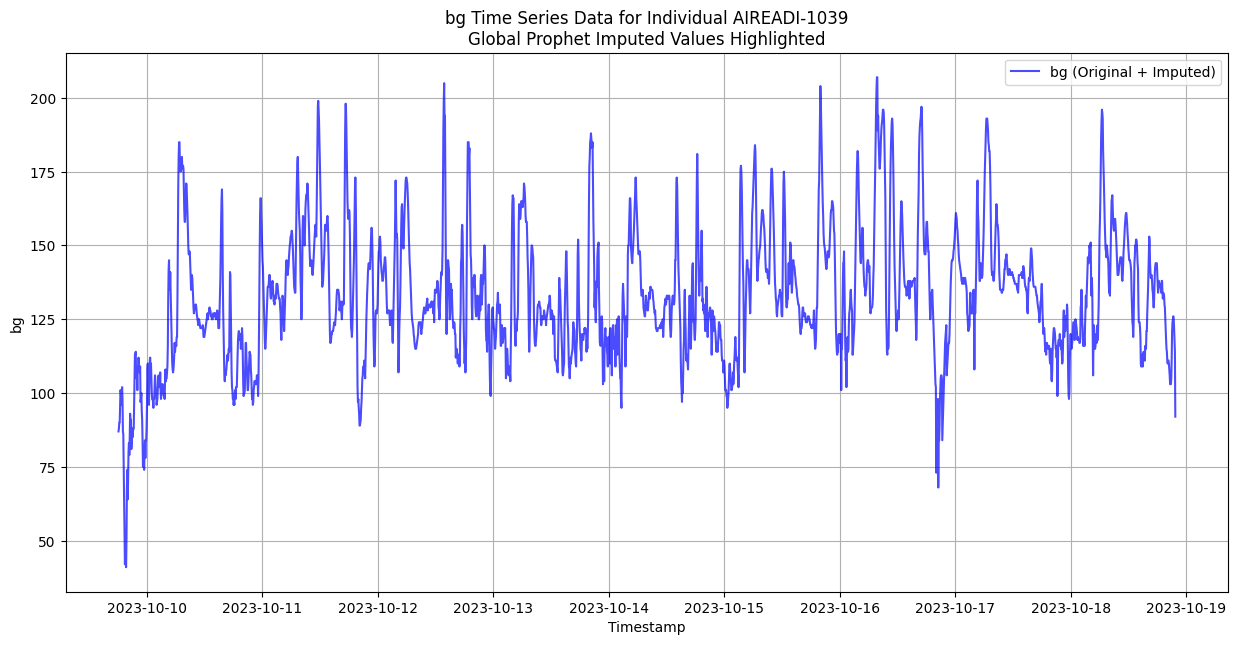

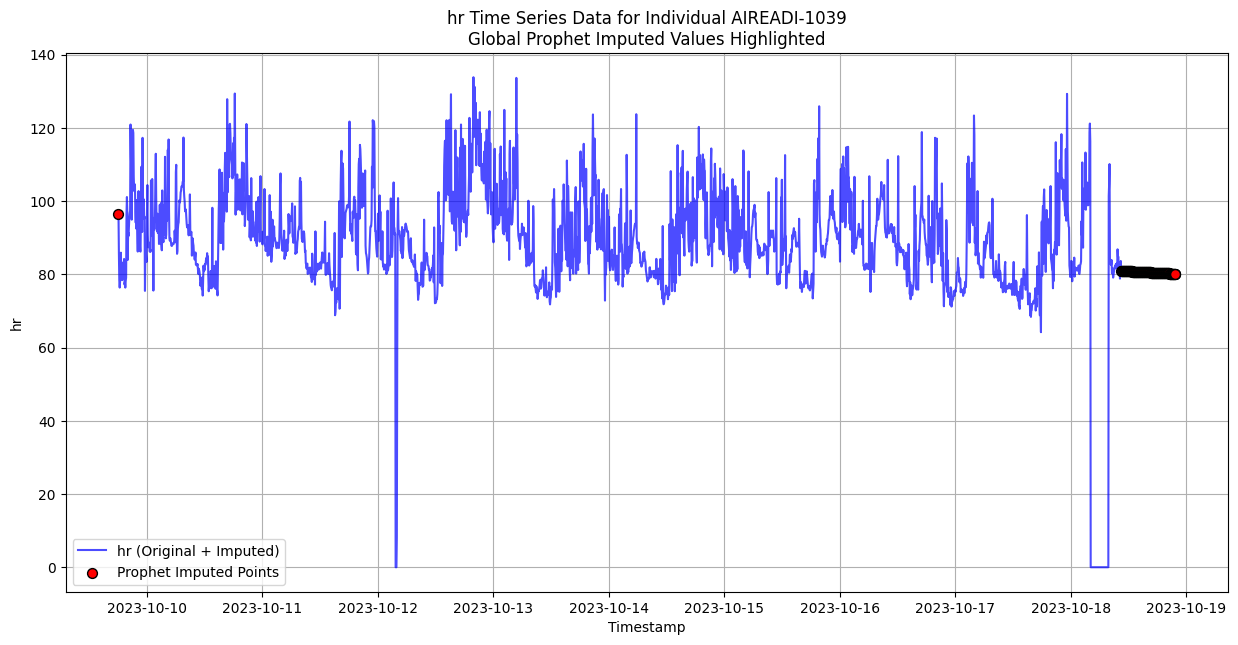

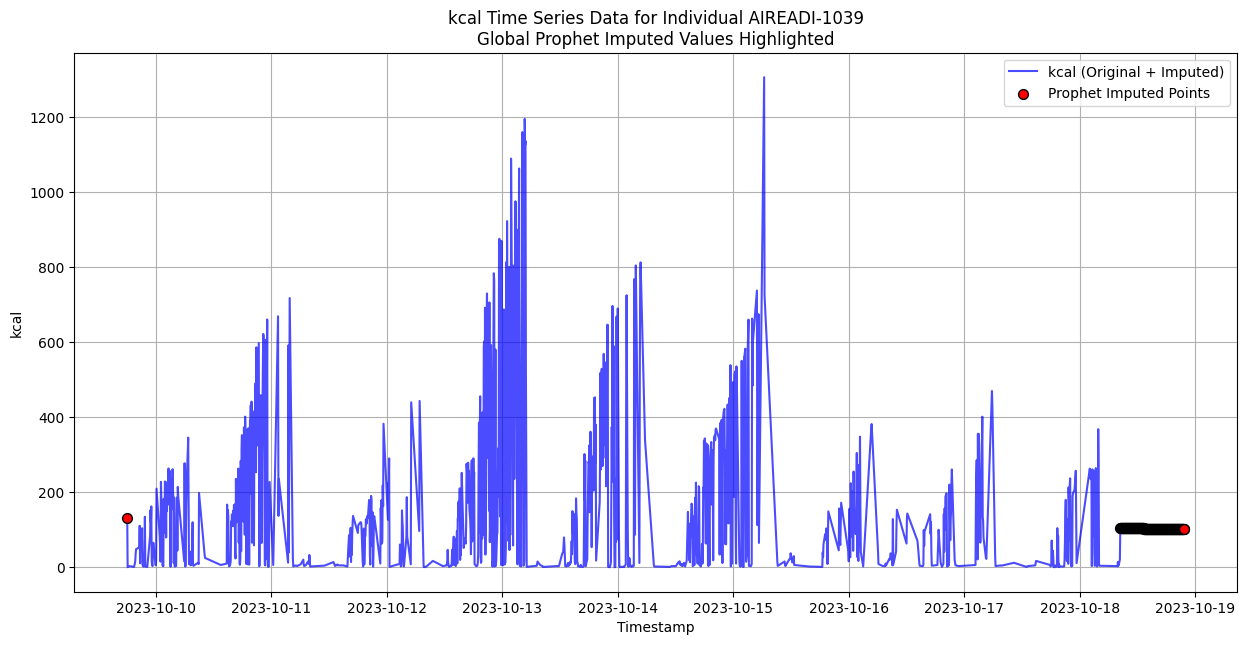

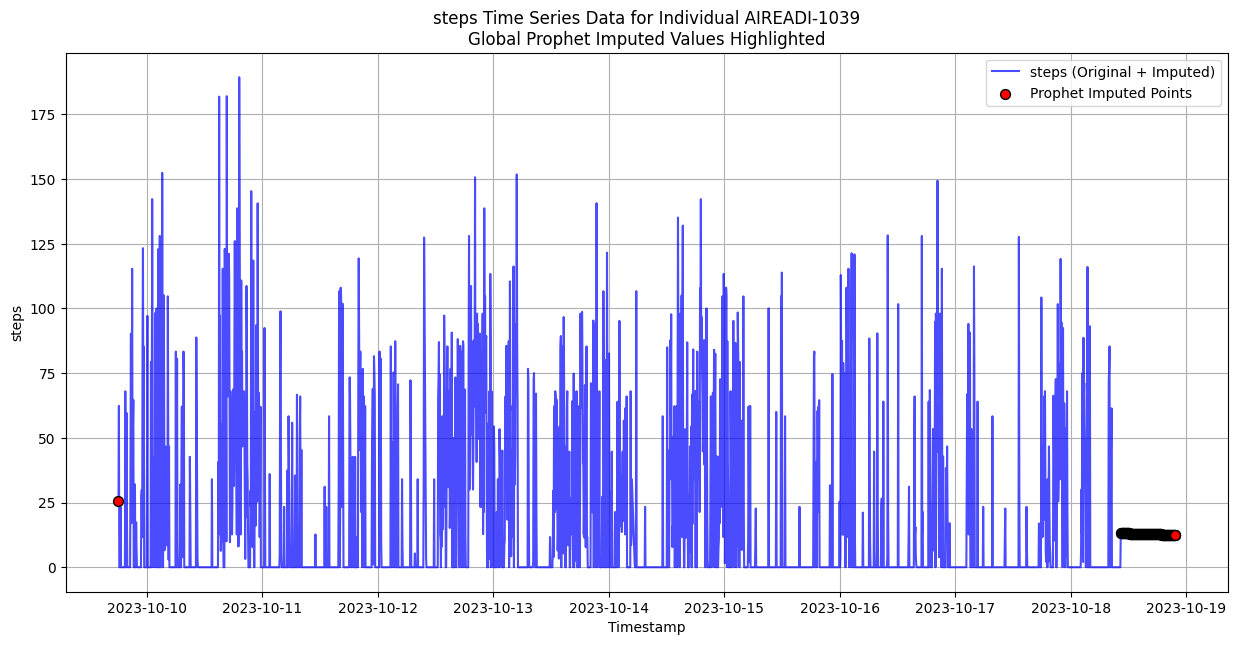

In [11]:
# prompt: Give me code to visualize the prophet imputed values for all variables for a random UUID from the previous code chunk

# Select a random UUID from the ones that had data processed by Prophet
# Ensure we only sample if there are any processed uuids in df
if not df['uuid'].empty:
    random_uuid_prophet = np.random.choice(df['uuid'].unique())
else:
    print("No data available after Prophet imputation to visualize.")
    random_uuid_prophet = None

if random_uuid_prophet:
    print(f"\nVisualizing Global Prophet imputed values for individual {random_uuid_prophet}:")

    # Get the data for this uuid from the final DataFrame (df)
    individual_df_prophet = df[df['uuid'] == random_uuid_prophet].copy()

    if individual_df_prophet.empty:
        print(f"Data not found for UUID {random_uuid_prophet} in the final DataFrame. Skipping visualization.")
    else:
        # Define columns to plot - the original variables now containing Prophet imputed values
        cols_to_plot = variables_for_prophet_imputation_plotting

        for col in cols_to_plot:
            # Check if the variable and its imputation indicator column exist
            indicator_col = f'is_{col}_prophet_imputed'
            if col in individual_df_prophet.columns and indicator_col in individual_df_prophet.columns:
                plt.figure(figsize=(15, 7))

                # Plot the entire time series for the variable (includes original and imputed)
                sns.lineplot(data=individual_df_prophet, x='timestamp', y=col, label=f'{col} (Original + Imputed)', color='blue', alpha=0.7, linewidth=1.5)

                # Highlight the Prophet imputed points using the indicator column
                # Filter rows where the indicator is 1
                prophet_imputed_points = individual_df_prophet[individual_df_prophet[indicator_col] == 1].copy()

                # Overlay the imputed points as scatter markers
                if not prophet_imputed_points.empty:
                     plt.scatter(prophet_imputed_points['timestamp'], prophet_imputed_points[col], color='red', zorder=5, label='Prophet Imputed Points', s=50, marker='o', edgecolor='black')

                plt.title(f'{col} Time Series Data for Individual {random_uuid_prophet}\nGlobal Prophet Imputed Values Highlighted')
                plt.xlabel('Timestamp')
                plt.ylabel(col)
                plt.legend()
                plt.grid(True)
                plt.show()
            else:
                 print(f"Variable '{col}' or indicator column '{indicator_col}' not found in DataFrame for UUID {random_uuid_prophet}. Skipping plot for this variable.")



In [12]:
def impute_time_series_data(df, imputation_vars, time_interval='5min'):
    """
    Cleans, imputes missing time series data, and engineers imputation-related features.

    Args:
        df (pd.DataFrame): The input DataFrame with 'uuid' and 'timestamp' columns.
        imputation_vars (list): A list of column names to impute.
        time_interval (str): The expected regular time interval of the data (e.g., '5min').

    Returns:
        pd.DataFrame: The DataFrame with missing values imputed and new features.
    """
    df_imputed_list = []
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values(by=['uuid', 'timestamp'])

    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek

    interval_td = pd.Timedelta(time_interval)
    short_gap_ffill_duration = pd.Timedelta('30 minutes')
    short_gap_interp_duration = pd.Timedelta('2 hours')

    for uuid in df['uuid'].unique():
        df_uuid = df[df['uuid'] == uuid].copy()
        if df_uuid.empty:
            continue

        df_uuid = df_uuid.drop_duplicates(subset=['timestamp']).sort_values(by='timestamp').set_index('timestamp')

        min_ts = df_uuid.index.min()
        max_ts = df_uuid.index.max()
        if pd.isnull(min_ts) or pd.isnull(max_ts):
             print(f"Warning: Invalid timestamp range for uuid {uuid}. Skipping imputation for this uuid.")
             df_uuid_reindexed = df_uuid
        else:
             full_index = pd.date_range(start=min_ts, end=max_ts, freq=time_interval)
             df_uuid_reindexed = df_uuid.reindex(full_index)

        # Feature: Indicator for any imputation
        df_uuid_reindexed['imputed_indicator'] = 0

        for var in imputation_vars:
            if var not in df_uuid_reindexed.columns:
                print(f"Warning: Variable '{var}' not found in reindexed data for uuid {uuid}. Skipping.")
                continue

            # Store original null mask before imputation
            original_null_mask = df_uuid_reindexed[var].isnull()

            if 'hour' not in df_uuid_reindexed.columns:
                 df_uuid_reindexed['hour'] = df_uuid_reindexed.index.hour
                 df_uuid_reindexed['dayofweek'] = df_uuid_reindexed.index.dayofweek

            # 1. Forward Fill with Decay (<= 30 mins)
            ffill_limit = int(short_gap_ffill_duration / interval_td)
            # Use ffill() instead of fillna(method='ffill')
            df_uuid_reindexed[var] = df_uuid_reindexed[var].ffill(limit=ffill_limit)

            # 2. Interpolation (<= 2 hours)
            interp_limit = int(short_gap_interp_duration / interval_td)
            df_uuid_reindexed[var] = df_uuid_reindexed[var].interpolate(method='linear', limit=interp_limit, limit_direction='both')

            # Exclude steps/kcal interpolation during likely sleep periods (e.g., 10 PM to 6 AM)
            if var in ['steps', 'kcal']:
                 sleep_hours = list(range(22, 24)) + list(range(6))
                 is_sleep_hour = df_uuid_reindexed.index.hour.isin(sleep_hours)
                 # Note: Remaining NaNs in sleep hours for steps/kcal are handled by contextual imputation

            # 3. Contextual Imputation for remaining NaNs
            nan_mask = df_uuid_reindexed[var].isnull()
            if nan_mask.any():
                if df_uuid_reindexed[var].notna().any():
                    hourly_avg = df_uuid_reindexed.groupby(df_uuid_reindexed.index.hour)[var].mean()
                    daily_avg = df_uuid_reindexed.groupby(df_uuid_reindexed.index.dayofweek)[var].mean()
                    individual_avg = df_uuid_reindexed[var].mean()
                else:
                    hourly_avg = pd.Series([], dtype='float64')
                    daily_avg = pd.Series([], dtype='float64')
                    individual_avg = np.nan

                for ts in df_uuid_reindexed.index[nan_mask]:
                    hour = ts.hour
                    dayofweek = ts.dayofweek
                    imputed_value = hourly_avg.get(hour)
                    if pd.isnull(imputed_value):
                        imputed_value = daily_avg.get(dayofweek)
                    if pd.isnull(imputed_value):
                        imputed_value = individual_avg
                    if pd.isnull(imputed_value):
                        global_avg = df[var].mean() # Use original df for global mean
                        imputed_value = global_avg if not pd.isnull(global_avg) else 0
                    df_uuid_reindexed.loc[ts, var] = imputed_value

        df_uuid_reindexed = df_uuid_reindexed.reset_index().rename(columns={'index': 'timestamp'})
        df_imputed_list.append(df_uuid_reindexed)

    if df_imputed_list:
        df_imputed = pd.concat(df_imputed_list, ignore_index=True)
    else:
        df_imputed = pd.DataFrame(columns=df.columns)

    if 'hour' in df_imputed.columns:
        df_imputed = df_imputed.drop(columns=['hour', 'dayofweek'])

    return df_imputed

# List of variables to impute
variables_to_impute = ['bg', 'hr', 'kcal', 'steps']

df_imputed = impute_time_series_data(df, variables_to_impute)

print("\nDataFrame nulls after imputation and feature engineering:")
print(df_imputed.isnull().sum())
print(df_imputed.head()) # Display first few rows to see new features


DataFrame nulls after imputation and feature engineering:
timestamp                   0
uuid                        0
bg                          0
hr                          0
kcal                        0
steps                       0
bg_prophet_imputed          0
is_bg_prophet_imputed       0
hr_prophet_imputed          0
is_hr_prophet_imputed       0
kcal_prophet_imputed        0
is_kcal_prophet_imputed     0
steps_prophet_imputed       0
is_steps_prophet_imputed    0
imputed_indicator           0
dtype: int64
            timestamp          uuid    bg         hr        kcal      steps  \
0 2023-10-09 18:06:32  AIREADI-1039  87.0  96.477473  132.211756  25.536350   
1 2023-10-09 18:11:32  AIREADI-1039  88.0  85.833333    0.236957  62.333333   
2 2023-10-09 18:16:32  AIREADI-1039  90.0  78.275000    0.889130   0.000000   
3 2023-10-09 18:21:32  AIREADI-1039  90.0  76.366667    1.541304   0.000000   
4 2023-10-09 18:26:32  AIREADI-1039  95.0  78.302778    2.193478   0.000000   

   

Select a random UUID to plot to see how imputation went



Visualizing original data with imputed points for individual AIREADI-7280:


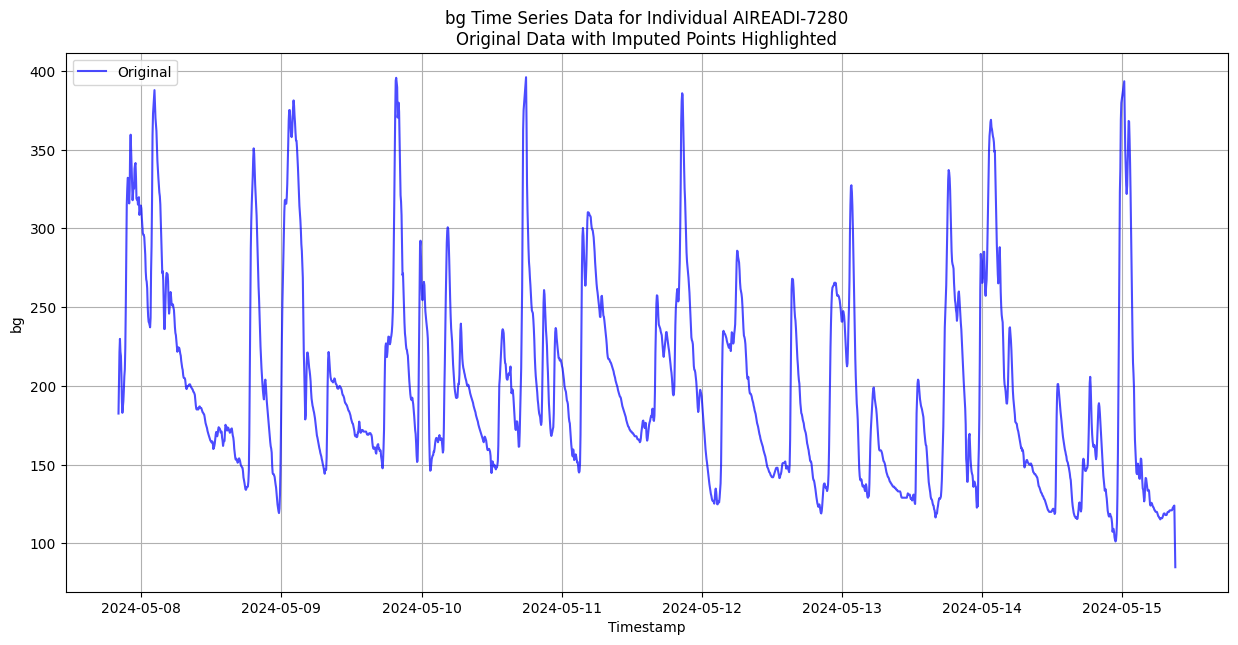

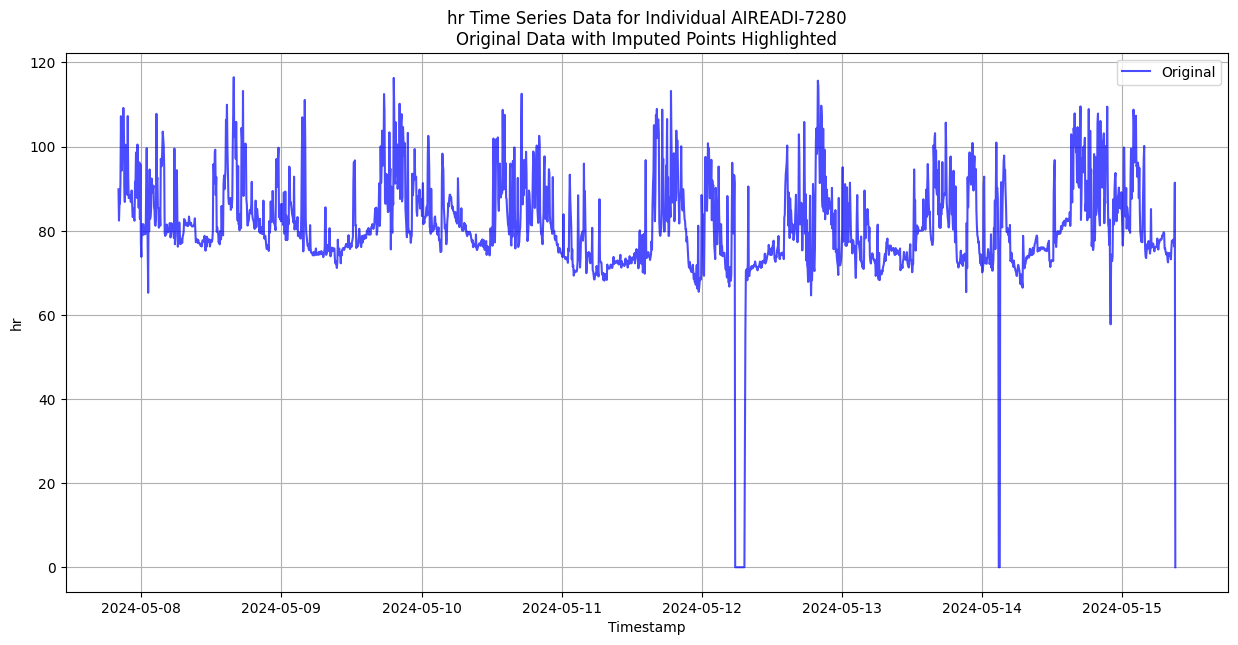

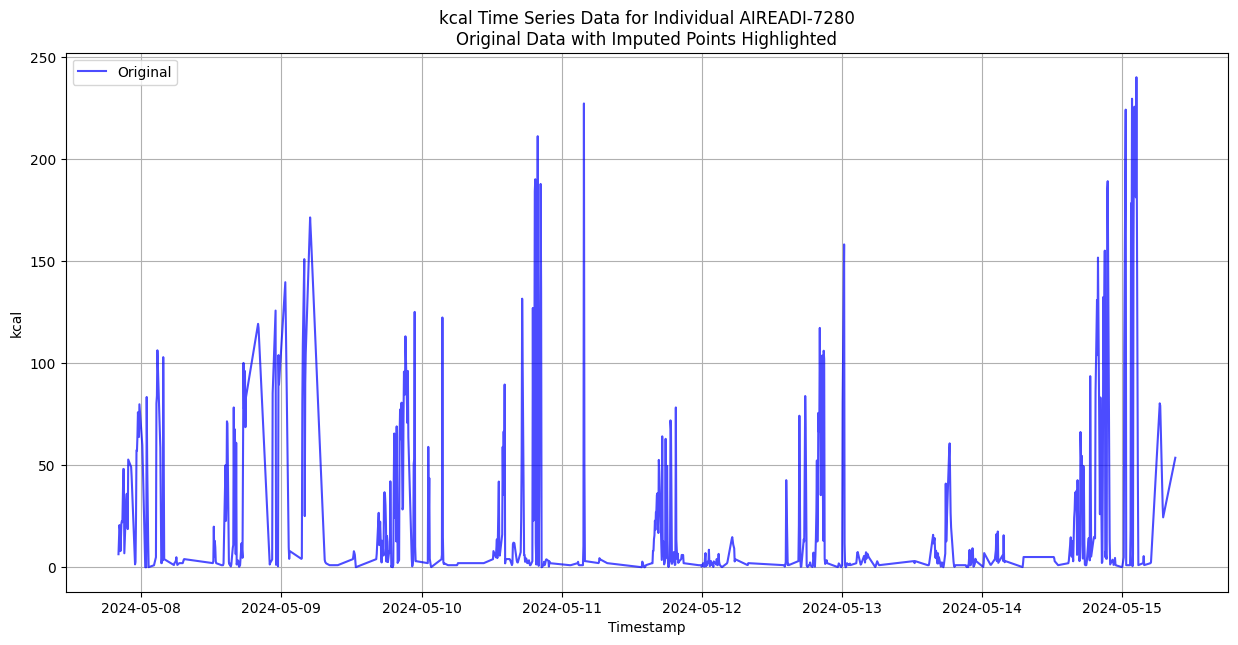

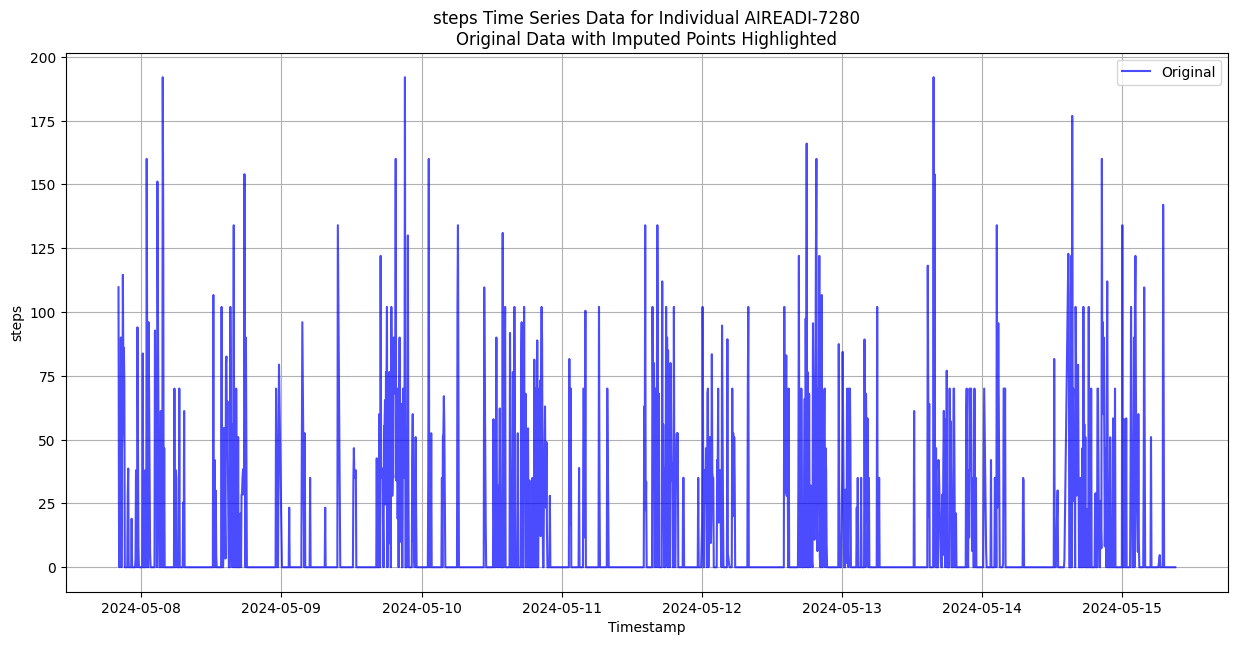

In [13]:


# Select a random UUID from the ones that had data processed
# Ensure we only sample if there are any processed uuids in df_imputed
if not df_imputed['uuid'].empty:
    random_uuid = np.random.choice(df_imputed['uuid'].unique())
else:
    print("No imputed data available to visualize.")
    random_uuid = None # Set to None if no uuids found

if random_uuid:
    print(f"\nVisualizing original data with imputed points for individual {random_uuid}:")

    # Get the original data for this uuid
    # Assuming the original df before imputation is still available as 'df'
    original_individual_df = df[df['uuid'] == random_uuid].copy()

    # Get the imputed data for this uuid
    imputed_individual_df = df_imputed[df_imputed['uuid'] == random_uuid].copy()

    if original_individual_df.empty or imputed_individual_df.empty:
        print(f"Data not found for UUID {random_uuid} in either original or imputed DataFrame. Skipping visualization.")
    else:
        # Define columns to plot (the ones that were imputed)
        cols_to_plot = variables_to_impute # Using the list from the imputation step

        for col in cols_to_plot:
            if col in original_individual_df.columns and col in imputed_individual_df.columns:
                plt.figure(figsize=(15, 7))

                # Plot the original data as the main line
                sns.lineplot(data=original_individual_df, x='timestamp', y=col, label='Original', color='blue', alpha=0.7, linewidth=1.5)

                # Highlight the imputed points
                # To find imputed points, align the original and imputed dataframes by timestamp
                # and check where original was null and imputed is not null.

                # Temporarily set timestamp as index for both for easy comparison
                original_indexed = original_individual_df.set_index('timestamp')
                imputed_indexed = imputed_individual_df.set_index('timestamp')

                # Create the mask using the aligned, time-indexed dataframes
                # This mask is True at timestamps where the original data was null
                imputed_points_mask = original_indexed[col].isnull() & imputed_indexed[col].notna()

                # Select the imputed points from the imputed_indexed dataframe
                imputed_points_to_plot = imputed_indexed.loc[imputed_points_mask].reset_index()

                # Overlay the imputed points as scatter markers
                if not imputed_points_to_plot.empty:
                     plt.scatter(imputed_points_to_plot['timestamp'], imputed_points_to_plot[col], color='red', zorder=5, label='Imputed Points', s=50, marker='o', edgecolor='black') # Use scatter for points


                plt.title(f'{col} Time Series Data for Individual {random_uuid}\nOriginal Data with Imputed Points Highlighted')
                plt.xlabel('Timestamp')
                plt.ylabel(col)
                plt.legend()
                plt.grid(True)
                plt.show()
            else:
                 print(f"Variable '{col}' not found in both original and imputed DataFrames for UUID {random_uuid}. Skipping plot for this variable.")

If there are still NaN values remaining, use this to fill them in.

In [14]:
def fill_nan_values(df, group_col='uuid', timestamp_col='timestamp'):
    """
    Fill NaN values in DataFrame using forward fill, then backward fill as fallback.

    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing NaN values
    group_col : str, default 'uuid'
        Column name to group by (e.g., person/patient identifier)
    timestamp_col : str, default 'timestamp'
        Column name for timestamp to ensure proper ordering

    Returns:
    --------
    pandas.DataFrame
        DataFrame with NaN values filled
    dict
        Summary of NaN filling operations
    """

    # Create a copy to avoid modifying original data
    df_filled = df.copy()

    # Initialize summary dictionary
    fill_summary = {
        'total_nans_before': df.isnull().sum().sum(),
        'columns_with_nans': {},
        'total_nans_after': 0,
        'rows_dropped': 0
    }

    print("NaN Filling Summary:")
    print("=" * 50)

    # Check NaN counts before filling
    nan_counts_before = df.isnull().sum()
    columns_with_nans = nan_counts_before[nan_counts_before > 0]

    if len(columns_with_nans) == 0:
        print("No NaN values found in the data.")
        return df_filled, fill_summary

    print(f"Total NaN values before filling: {fill_summary['total_nans_before']}")
    print("\nNaN counts by column before filling:")
    for col, count in columns_with_nans.items():
        print(f"  {col}: {count}")
        fill_summary['columns_with_nans'][col] = {
            'before': count,
            'filled_forward': 0,
            'filled_backward': 0,
            'remaining': 0
        }

    # Sort by group and timestamp to ensure proper order for forward/backward fill
    df_filled = df_filled.sort_values([group_col, timestamp_col])

    # Process each group separately
    filled_groups = []

    for group_id in df_filled[group_col].unique():
        print(f"\nProcessing group: {group_id}")

        # Get data for this group
        group_data = df_filled[df_filled[group_col] == group_id].copy()

        # Store original NaN positions for tracking
        original_nans = {}
        for col in columns_with_nans.index:
            if col in group_data.columns:
                original_nans[col] = group_data[col].isnull()

        # Forward fill first
        group_data_ffill = group_data.fillna(method='ffill')

        # Count what was filled by forward fill
        for col in columns_with_nans.index:
            if col in group_data.columns:
                filled_by_ffill = original_nans[col] & ~group_data_ffill[col].isnull()
                fill_summary['columns_with_nans'][col]['filled_forward'] += filled_by_ffill.sum()

        # Backward fill for remaining NaNs
        group_data_filled = group_data_ffill.fillna(method='bfill')

        # Count what was filled by backward fill
        for col in columns_with_nans.index:
            if col in group_data.columns:
                still_nan_after_ffill = group_data_ffill[col].isnull()
                filled_by_bfill = still_nan_after_ffill & ~group_data_filled[col].isnull()
                fill_summary['columns_with_nans'][col]['filled_backward'] += filled_by_bfill.sum()

        # Count remaining NaNs
        for col in columns_with_nans.index:
            if col in group_data.columns:
                remaining_nans = group_data_filled[col].isnull().sum()
                fill_summary['columns_with_nans'][col]['remaining'] += remaining_nans

        # Check if there are still NaNs in this group
        remaining_nans_in_group = group_data_filled.isnull().sum().sum()
        if remaining_nans_in_group > 0:
            print(f"  Warning: {remaining_nans_in_group} NaN values remain in group {group_id}")
            print("  These might be columns that are entirely NaN for this group")

        filled_groups.append(group_data_filled)

    # Combine all groups back together
    df_filled = pd.concat(filled_groups, ignore_index=True)

    # Final NaN count
    fill_summary['total_nans_after'] = df_filled.isnull().sum().sum()

    # Print summary
    print("\n" + "=" * 50)
    print("FILLING SUMMARY:")
    print(f"Total NaN values before: {fill_summary['total_nans_before']}")
    print(f"Total NaN values after:  {fill_summary['total_nans_after']}")
    print(f"Total NaN values filled: {fill_summary['total_nans_before'] - fill_summary['total_nans_after']}")

    print("\nDetailed summary by column:")
    for col, stats in fill_summary['columns_with_nans'].items():
        print(f"  {col}:")
        print(f"    Before: {stats['before']}")
        print(f"    Filled by forward fill: {stats['filled_forward']}")
        print(f"    Filled by backward fill: {stats['filled_backward']}")
        print(f"    Remaining: {stats['remaining']}")

    # Handle any remaining NaNs
    if fill_summary['total_nans_after'] > 0:
        print(f"\nWarning: {fill_summary['total_nans_after']} NaN values still remain!")
        print("Options to handle remaining NaNs:")
        print("1. Drop rows with remaining NaNs")
        print("2. Fill with mean/median values")
        print("3. Use interpolation")

        # Show which columns still have NaNs
        remaining_nans = df_filled.isnull().sum()
        remaining_nan_cols = remaining_nans[remaining_nans > 0]
        if len(remaining_nan_cols) > 0:
            print("\nColumns with remaining NaNs:")
            for col, count in remaining_nan_cols.items():
                print(f"  {col}: {count}")

    return df_filled, fill_summary

def handle_remaining_nans(df, strategy='drop', fill_value=None):
    """
    Handle any remaining NaN values after forward/backward fill.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame that may still contain NaN values
    strategy : str, default 'drop'
        Strategy to handle remaining NaNs:
        - 'drop': Drop rows with any NaN values
        - 'mean': Fill with column mean
        - 'median': Fill with column median
        - 'zero': Fill with zero
        - 'value': Fill with specified value
    fill_value : float, optional
        Value to use when strategy='value'

    Returns:
    --------
    pandas.DataFrame
        DataFrame with all NaN values handled
    dict
        Summary of operations performed
    """

    df_clean = df.copy()
    summary = {
        'nans_before': df.isnull().sum().sum(),
        'strategy_used': strategy,
        'rows_dropped': 0,
        'values_filled': 0
    }

    if summary['nans_before'] == 0:
        print("No remaining NaN values to handle.")
        return df_clean, summary

    print(f"\nHandling {summary['nans_before']} remaining NaN values using strategy: '{strategy}'")

    if strategy == 'drop':
        rows_before = len(df_clean)
        df_clean = df_clean.dropna()
        summary['rows_dropped'] = rows_before - len(df_clean)
        print(f"Dropped {summary['rows_dropped']} rows containing NaN values")

    elif strategy == 'mean':
        # Only fill numeric columns
        numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if df_clean[col].isnull().any():
                fill_val = df_clean[col].mean()
                nan_count = df_clean[col].isnull().sum()
                df_clean[col] = df_clean[col].fillna(fill_val)
                summary['values_filled'] += nan_count
                print(f"Filled {nan_count} NaN values in '{col}' with mean: {fill_val:.4f}")

    elif strategy == 'median':
        # Only fill numeric columns
        numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if df_clean[col].isnull().any():
                fill_val = df_clean[col].median()
                nan_count = df_clean[col].isnull().sum()
                df_clean[col] = df_clean[col].fillna(fill_val)
                summary['values_filled'] += nan_count
                print(f"Filled {nan_count} NaN values in '{col}' with median: {fill_val:.4f}")

    elif strategy == 'zero':
        nan_count = df_clean.isnull().sum().sum()
        df_clean = df_clean.fillna(0)
        summary['values_filled'] = nan_count
        print(f"Filled {nan_count} NaN values with zero")

    elif strategy == 'value':
        if fill_value is None:
            raise ValueError("fill_value must be specified when strategy='value'")
        nan_count = df_clean.isnull().sum().sum()
        df_clean = df_clean.fillna(fill_value)
        summary['values_filled'] = nan_count
        print(f"Filled {nan_count} NaN values with: {fill_value}")

    else:
        raise ValueError(f"Unknown strategy: {strategy}")

    final_nans = df_clean.isnull().sum().sum()
    if final_nans > 0:
        print(f"Warning: {final_nans} NaN values still remain after {strategy} strategy")
    else:
        print("All NaN values successfully handled!")

    return df_clean, summary


df_filled, fill_summary = fill_nan_values(df, group_col='uuid', timestamp_col='timestamp')

#If there are still NaNs after forward/backward fill, handle them:
df_clean, clean_summary = handle_remaining_nans(df_filled, strategy='zero')




NaN Filling Summary:
No NaN values found in the data.
No remaining NaN values to handle.


# Feature engineering

Engineer some relevent time series features


In [15]:


# Feature Engineering Function
def engineer_time_series_features(df, variables, time_interval='5min'):
    """
    Engineers standard time series features and lag/rolling features
    for specified variables and their Prophet imputed versions.

    Args:
        df (pd.DataFrame): The input DataFrame with 'uuid' and 'timestamp'.
                           Assumes it includes original variables and
                           Prophet imputed variables (e.g., 'bg', 'bg_prophet_imputed').
        variables (list): A list of base variable names (e.g., ['bg', 'hr']).
        time_interval (str): The expected regular time interval (e.g., '5min').

    Returns:
        pd.DataFrame: The DataFrame with new engineered features.
    """
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values(by=['uuid', 'timestamp'])

    # --- Time-based Features ---
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    # Use isocalendar().week and handle potential multiple modes gracefully
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

    # Optional: Sine/Cosine transformations for cyclic features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

    # --- Lagged Features and Rolling Statistics ---

    # Define common lag periods and rolling window sizes
    lags_min = [
        5,
        10,
        15,
        20,
        25, # Lag 5 - PACF should be close to 0 after this
        60   # 1 hour

    ]

    # Convert lag minutes to periods based on the dominant time interval
    def get_dominant_interval_minutes(df_uuid):
        if df_uuid.empty or len(df_uuid) < 2:
            return np.nan
        diffs = df_uuid['timestamp'].diff().dropna()
        # Calculate the mode, handle multiple modes by taking the first
        mode_diff = diffs.mode()
        if mode_diff.empty:
            return np.nan
        return mode_diff.iloc[0].total_seconds() / 60.0

    # Calculate dominant interval for each uuid and get the median
    dominant_intervals = df.groupby('uuid').apply(get_dominant_interval_minutes)
    median_dominant_interval = dominant_intervals.median()

    if pd.isnull(median_dominant_interval) or median_dominant_interval <= 0:
        print(f"Warning: Could not determine dominant time interval from data. Using provided time_interval: {time_interval}")
        interval_minutes = pd.Timedelta(time_interval).total_seconds() / 60.0
    else:
        interval_minutes = median_dominant_interval
        print(f"Estimated dominant time interval from data: {interval_minutes:.2f} minutes.")

    lag_periods = [max(1, round(lag / interval_minutes)) for lag in lags_min]
    lag_periods = sorted(list(set(lag_periods)))
    print(f"Generated lag periods based on estimated interval: {lag_periods}")

    rolling_windows_min = [
        15,
        30,
        60   # 1 hour
    ]

    rolling_window_periods = [max(1, round(window / interval_minutes)) for window in rolling_windows_min]
    rolling_window_periods = sorted(list(set(rolling_window_periods)))
    print(f"Generated rolling window periods based on estimated interval: {rolling_window_periods}")

    # Combine original variables and their Prophet imputed versions
    all_vars_to_process = []
    for var in variables:
        all_vars_to_process.append(var) # Original variable
        prophet_var = f'{var}_prophet_imputed'
        if prophet_var in df.columns:
            all_vars_to_process.append(prophet_var)
        indicator_var = f'is_{var}_prophet_imputed'
        if indicator_var in df.columns:
             all_vars_to_process.append(indicator_var)

    # Apply features per uuid
    df_features_list = []

    # Set timestamp as index for easier time-based operations within groups
    df = df.set_index('timestamp')

    for uuid, df_uuid in df.groupby('uuid'):
        if df_uuid.empty:
            continue

        # Ensure index is sorted for shift and rolling operations
        df_uuid = df_uuid.sort_index()

        # Create a list to hold new feature columns for this uuid's dataframe chunk
        new_cols_list = []

        # Apply Lagged Features
        for var in all_vars_to_process:
            if var in df_uuid.columns:
                for lag_p in lag_periods:
                    new_col_name = f'{var}_lag_{lag_p}p'
                    # Calculate the lagged series and add it to the list
                    lagged_series = df_uuid[var].shift(periods=lag_p)
                    new_cols_list.append(lagged_series.rename(new_col_name))

        # Apply Rolling Window Features (Mean, Median, Std Dev, Min, Max)
        # Also calculate Difference from Rolling Mean here
        for var in all_vars_to_process:
             if var in df_uuid.columns:
                for window_p in rolling_window_periods:
                     # Calculate rolling features and add them to the list
                     roll_mean = df_uuid[var].rolling(window=window_p, min_periods=1).mean()
                     roll_median = df_uuid[var].rolling(window=window_p, min_periods=1).median()
                     roll_std = df_uuid[var].rolling(window=window_p, min_periods=1).std()
                     roll_min = df_uuid[var].rolling(window=window_p, min_periods=1).min()
                     roll_max = df_uuid[var].rolling(window=window_p, min_periods=1).max()

                     new_cols_list.append(roll_mean.rename(f'{var}_roll_mean_{window_p}p'))
                     #new_cols_list.append(roll_median.rename(f'{var}_roll_median_{window_p}p'))
                     #new_cols_list.append(roll_std.rename(f'{var}_roll_std_{window_p}p'))
                     #new_cols_list.append(roll_min.rename(f'{var}_roll_min_{window_p}p'))
                     #new_cols_list.append(roll_max.rename(f'{var}_roll_max_{window_p}p'))

                     # Feature: Difference from Rolling Mean (Deviation from average)
                     # Calculate using the just-calculated rolling mean and the original variable
                     new_cols_list.append((df_uuid[var] - roll_mean).rename(f'{var}_diff_roll_mean_{window_p}p'))


        # Concatenate the new feature columns to the original df_uuid chunk
        if new_cols_list:
            # Pass df_uuid as the first element to include original columns
            df_uuid_with_features = pd.concat([df_uuid] + new_cols_list, axis=1)
        else:
            df_uuid_with_features = df_uuid # No new features added

        df_features_list.append(df_uuid_with_features)

    # Concatenate all processed DataFrames from the list
    if df_features_list:
        df_featured = pd.concat(df_features_list)
    else:
        df_featured = pd.DataFrame(columns=df.columns) # Return empty if no data was processed

    # Reset index to make timestamp a column again
    df_featured = df_featured.reset_index()

    print("\nDataFrame after Feature Engineering:")
    print(df_featured.head())
    print("\nEngineered Features:")
    # Need a way to compare with the original columns to print only new ones
    # Assuming the input 'df' is the state before this function was called.
    # Let's get the columns of the input df (before setting index)
    original_cols_set = set(df.columns) # This is the df *after* setting index, but before adding features
    # Get columns from the final df_featured and subtract the ones that were in df before features
    engineered_cols = set(df_featured.columns) - original_cols_set
    print(sorted(list(engineered_cols)))


    return df_featured

# Apply the feature engineering function
variables_for_features = ['bg', 'hr', 'kcal', 'steps']

# Ensure df holds the Prophet-imputed data
# The previous cell updates df to df_prophet_imputed
# So, df here is the DataFrame resulting from Prophet imputation.
df_final_featured = engineer_time_series_features(df_clean, variables_for_features)

# Update df for any potential subsequent steps
df = df_final_featured.copy()

Estimated dominant time interval from data: 5.00 minutes.
Generated lag periods based on estimated interval: [1, 2, 3, 4, 5, 12]
Generated rolling window periods based on estimated interval: [3, 6, 12]

DataFrame after Feature Engineering:
            timestamp          uuid    bg         hr        kcal      steps  \
0 2023-10-09 18:06:32  AIREADI-1039  87.0  96.477473  132.211756  25.536350   
1 2023-10-09 18:11:32  AIREADI-1039  88.0  85.833333    0.236957  62.333333   
2 2023-10-09 18:16:32  AIREADI-1039  90.0  78.275000    0.889130   0.000000   
3 2023-10-09 18:21:32  AIREADI-1039  90.0  76.366667    1.541304   0.000000   
4 2023-10-09 18:26:32  AIREADI-1039  95.0  78.302778    2.193478   0.000000   

   bg_prophet_imputed  is_bg_prophet_imputed  hr_prophet_imputed  \
0                87.0                      0           96.477473   
1                88.0                      0           85.833333   
2                90.0                      0           78.275000   
3            

In [16]:
columns_without_prophet = [col for col in df.columns if 'prophet' not in col]
df = df[columns_without_prophet]
print(df)


                timestamp          uuid     bg         hr        kcal  \
0     2023-10-09 18:06:32  AIREADI-1039   87.0  96.477473  132.211756   
1     2023-10-09 18:11:32  AIREADI-1039   88.0  85.833333    0.236957   
2     2023-10-09 18:16:32  AIREADI-1039   90.0  78.275000    0.889130   
3     2023-10-09 18:21:32  AIREADI-1039   90.0  76.366667    1.541304   
4     2023-10-09 18:26:32  AIREADI-1039   95.0  78.302778    2.193478   
...                   ...           ...    ...        ...         ...   
13330 2024-07-05 15:15:09  AIREADI-7348  126.2  96.400000    6.797619   
13331 2024-07-05 15:20:09  AIREADI-7348  145.6  87.800000    3.226190   
13332 2024-07-05 15:25:09  AIREADI-7348  141.0  68.533333    4.462500   
13333 2024-07-05 15:30:09  AIREADI-7348  144.6  99.200000    7.842593   
13334 2024-07-05 15:35:09  AIREADI-7348  142.8  71.733333    5.064815   

           steps  hour  dayofweek  is_weekend  hour_sin  ...  \
0      25.536350    18          0           0 -1.000000  ..

# Variable selection

## Initial reduction
Attention-based and permutation-based feature selection to winnow down the initial variable set



In [17]:

# Helper function to create sequences for LSTM
def create_sequences(data, target_col, sequence_length=12, forecast_horizons=[1, 2, 3, 6, 12]):
    sequences = []
    targets = []

    max_horizon = max(forecast_horizons)

    # Ensure data is sorted by uuid and timestamp before creating sequences
    data = data.sort_values(by=['uuid', 'timestamp'])

    for uuid in data['uuid'].unique():
        person_data = data[data['uuid'] == uuid].copy()

        if len(person_data) < sequence_length + max_horizon:
            # print(f"Warning: Not enough data for uuid {uuid} for sequence creation. Skipping.")
            continue

        feature_cols = [col for col in person_data.columns if col not in ['uuid', 'timestamp', target_col]]
        person_features = person_data[feature_cols].values
        person_targets = person_data[target_col].values

        # Check for NaN values within the sequence and target window
        # This is a more robust check than the one inside the loop
        # It ensures that for each potential sequence and its corresponding targets
        # up to the max_horizon, there are no NaNs.
        for i in range(len(person_data) - sequence_length - max_horizon + 1):
             # Check features in the current sequence
             if np.any(np.isnan(person_features[i:i+sequence_length])):
                  # print(f"Warning: NaN values in features for sequence starting at index {i} for uuid {uuid}. Skipping.")
                  continue
             # Check targets up to max_horizon
             if np.any(np.isnan(person_targets[i+sequence_length : i+sequence_length+max_horizon])):
                  # print(f"Warning: NaN values in targets for sequence starting at index {i} for uuid {uuid} up to horizon {max_horizon}. Skipping.")
                  continue

             sequences.append(person_features[i:i+sequence_length])
             # Append targets for all specified horizons
             horizon_targets = [person_targets[i + sequence_length + h -1] for h in forecast_horizons]
             targets.append(horizon_targets)


    if len(sequences) == 0:
        print("No valid sequences created after checking for NaNs and minimum length.")
        # Return empty arrays with correct shapes to avoid errors later
        # Assuming feature_cols were successfully identified
        if 'feature_cols' in locals() and feature_cols:
             # Shape: (0, sequence_length, num_features)
             empty_sequences = np.array([], dtype=np.float32).reshape(0, sequence_length, len(feature_cols))
        else:
              # Fallback if feature_cols was not defined or empty
              empty_sequences = np.array([], dtype=np.float32).reshape(0, sequence_length, 0)

        # Shape: (0, num_horizons)
        empty_targets = np.array([], dtype=np.float32).reshape(0, len(forecast_horizons))
        return empty_sequences, empty_targets

    return np.array(sequences), np.array(targets)
# =============================================================================
# 1. ATTENTION-BASED FEATURE SELECTION FOR RNN/LSTM
# =============================================================================

class AttentionFeatureSelector(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, attention_dim=64):
        super(AttentionFeatureSelector, self).__init__()
        self.hidden_size = hidden_size
        self.attention_dim = attention_dim

        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

        self.feature_attention = nn.Sequential(
            nn.Linear(hidden_size, attention_dim),
            nn.Tanh(),
            nn.Linear(attention_dim, input_size),
            nn.Softmax(dim=-1)
        )

        self.temporal_attention = nn.Sequential(
            nn.Linear(hidden_size, attention_dim),
            nn.Tanh(),
            nn.Linear(attention_dim, 1)
        )

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, (hidden, _) = self.lstm(x)

        feature_weights = self.feature_attention(hidden[-1])

        attended_input = x * feature_weights.unsqueeze(1)

        lstm_out_attended, (final_hidden, _) = self.lstm(attended_input)

        temporal_scores = self.temporal_attention(lstm_out_attended)
        temporal_weights = torch.softmax(temporal_scores, dim=1)

        attended_output = torch.sum(lstm_out_attended * temporal_weights, dim=1)

        output = self.fc(attended_output)

        return output, feature_weights, temporal_weights

def attention_based_feature_selection(X, y, feature_names, top_k=None, epochs=100, lr=0.001):
    input_size = X.shape[2]
    hidden_size = min(64, input_size * 2)
    output_size = y.shape[1] if len(y.shape) > 1 else 1

    model = AttentionFeatureSelector(input_size, hidden_size, output_size)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        output, feature_weights, temporal_weights = model(X)
        loss = criterion(output, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        if epoch % 20 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        _, feature_weights, _ = model(X)

    avg_feature_weights = feature_weights.mean(dim=0).numpy()

    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': avg_feature_weights
    }).sort_values('importance', ascending=False)

    if top_k:
        selected_features = feature_importance_df.head(top_k)['feature'].tolist()
        selected_indices = [feature_names.index(feat) for feat in selected_features]
    else:
        threshold = np.median(avg_feature_weights)
        selected_indices = np.where(avg_feature_weights > threshold)[0].tolist()
        selected_features = [feature_names[i] for i in selected_indices]

    return selected_indices, selected_features, feature_importance_df, model

# =============================================================================
# 2. PERMUTATION IMPORTANCE FOR RNN/LSTM
# =============================================================================

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, rnn_type='LSTM'):
        super(SimpleRNN, self).__init__()
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        else:
            self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, (hidden, _) = self.rnn(x) if hasattr(self.rnn, 'bias_ih_l0') else (self.rnn(x)[0], self.rnn(x)[1])
        if isinstance(hidden, tuple):
            hidden = hidden[0]
        return self.fc(hidden[-1])

def train_rnn_model(X, y, input_size, hidden_size, output_size, rnn_type='LSTM', epochs=50):
    model = SimpleRNN(input_size, hidden_size, output_size, rnn_type)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    return model

def permutation_importance_rnn(X, y, feature_names, rnn_type='LSTM', n_repeats=10):
    input_size = X.shape[2]
    hidden_size = min(64, input_size * 2)
    output_size = y.shape[1] if len(y.shape) > 1 else 1

    print("Training baseline model...")
    model = train_rnn_model(X, y, input_size, hidden_size, output_size, rnn_type)

    model.eval()
    with torch.no_grad():
        baseline_pred = model(X)
        baseline_mse = nn.MSELoss()(baseline_pred, y).item()

    print(f"Baseline MSE: {baseline_mse:.4f}")

    feature_importance = {}

    for feature_idx in range(input_size):
        if feature_idx % 10 == 0:
          print(f"Testing feature {feature_idx}: {feature_names[feature_idx]}")

        importance_scores = []

        for repeat in range(n_repeats):
            X_permuted = X.clone()

            perm_indices = torch.randperm(X.shape[0])
            X_permuted[:, :, feature_idx] = X_permuted[perm_indices, :, feature_idx]

            with torch.no_grad():
                permuted_pred = model(X_permuted)
                permuted_mse = nn.MSELoss()(permuted_pred, y).item()

            importance = permuted_mse - baseline_mse
            importance_scores.append(importance)

        avg_importance = np.mean(importance_scores)
        std_importance = np.std(importance_scores)

        feature_importance[feature_names[feature_idx]] = {
            'importance_mean': avg_importance,
            'importance_std': std_importance,
            'feature_idx': feature_idx
        }

    importance_df = pd.DataFrame.from_dict(feature_importance, orient='index')
    importance_df = importance_df.sort_values('importance_mean', ascending=False)

    return importance_df

# =============================================================================
# 5. USAGE EXAMPLE AND COMPARISON FUNCTION
# =============================================================================

def compare_feature_selection_methods(X, y, feature_names, methods=['attention', 'permutation'], top_k = None):
    results = {}

    if 'attention' in methods:
        print("\n" + "="*50)
        print("ATTENTION-BASED FEATURE SELECTION")
        print("="*50)
        selected_idx, selected_feat, importance_df, model = attention_based_feature_selection(
            X, y, feature_names, top_k = top_k
        )
        results['attention'] = {
            'selected_indices': selected_idx,
            'selected_features': selected_feat,
            'importance_df': importance_df,
            'model': model
        }

    if 'permutation' in methods:
        print("\n" + "="*50)
        print("PERMUTATION IMPORTANCE")
        print("="*50)
        importance_df = permutation_importance_rnn(X, y, feature_names, 'LSTM')
        top_features = importance_df
        selected_idx = [importance_df.loc[feat, 'feature_idx'] for feat in top_features.index]
        results['permutation'] = {
            'selected_indices': selected_idx,
            'selected_features': list(top_features.index),
            'importance_df': importance_df
        }

    return results

In [18]:
# Define the directory in Google Drive where you want to save the cache
# Ensure this directory exists in your Google Drive
# Example: '/content/drive/My Drive/YourProjectFolder'
cache_dir_fs = '/content/drive/My Drive/DiabetesML' # Update this path if different from the previous cache

# Define the full path for the feature selection cache file
cache_filepath_fs = os.path.join(cache_dir_fs, 'feature_selection_cache.pkl')

# Ensure the cache directory exists
os.makedirs(cache_dir_fs, exist_ok=True)

# Check if the feature selection cache file exists
if os.path.exists(cache_filepath_fs):
    print(f"Loading cached feature selection results from {cache_filepath_fs}...")
    try:
        with open(cache_filepath_fs, 'rb') as f:
            results = pickle.load(f) # Load the entire results dictionary
        print("Feature selection cache loaded successfully.")

        # You would typically also load or regenerate your scaled X and y data (X_clean_scaled, y_clean_scaled)
        # and feature_names_clean here, as the rest of the code that *uses* 'results'
        # will likely depend on these variables being available.
        # Ensure X_clean_scaled, y_clean_scaled, and feature_names_clean are available
        # before the rest of the code that utilizes 'results'.
        # If they are not available, you must generate them from df *after* loading the cache.

    except Exception as e:
        print(f"Error loading feature selection cache file: {e}. Proceeding to re-run feature selection.")
        # If loading fails, delete the corrupted cache file and proceed to re-run
        os.remove(cache_filepath_fs)
        print(f"Removed potentially corrupted cache file: {cache_filepath_fs}")
        # Set 'results' to None to trigger the re-running of the feature selection
        results = None

else:
    print("No feature selection cache file found. Running feature selection methods...")
    # Set 'results' to None to trigger the re-running
    results = None


# --- Feature Selection Code (runs only if cache not loaded) ---
# This part contains your original feature selection logic

if results is None:
    print("Starting Feature Selection Comparison...")

    try:
        # Ensure X_clean_scaled, y_clean_scaled, and feature_names_clean are available
        # at this point. If they are generated by previous cells, make sure those
        # cells have been run. If they depend on 'df', ensure 'df' is available.
        if 'X_clean_scaled' not in globals() or 'y_clean_scaled' not in globals() or 'feature_names_clean' not in globals() or 'df' not in globals():
             print("Error: Required variables (X_clean_scaled, y_clean_scaled, feature_names_clean, or df) not found.")
             # You might need to regenerate them here if they are not globally available
             # Example:
             # X_clean, y_clean = create_sequences(df, 'bg', sequence_length=12)
             # ... scale X_clean and y_clean to get X_clean_scaled, y_clean_scaled ...
             # feature_names_clean = [col for col in df.columns if col not in ['uuid', 'timestamp', 'bg']]
             print("Attempting to regenerate data for feature selection...")
             # Assuming create_sequences and scaling functions are available
             # This is a simplified example; adjust based on your actual data pipeline
             try:
                  # create_sequences returns NumPy arrays
                  X_clean, y_clean = create_sequences(df, 'bg', sequence_length=12)

                  scaler_X_clean = StandardScaler()
                  scaler_y_clean = StandardScaler()

                  X_clean_shape_original = X_clean.shape
                  # Reshape NumPy array for scaling
                  X_clean_reshaped_for_scaling = X_clean.reshape(-1, X_clean_shape_original[-1])
                  X_clean_scaled_flat = scaler_X_clean.fit_transform(X_clean_reshaped_for_scaling)
                  # Reshape back to original 3D shape for PyTorch
                  X_clean_scaled = torch.FloatTensor(X_clean_scaled_flat.reshape(X_clean_shape_original))

                  y_clean_shape_original = y_clean.shape
                  if len(y_clean_shape_original) == 1:
                      y_clean_reshaped_for_scaling = y_clean.reshape(-1, 1) # Reshape NumPy array
                      y_scaled_reshaped = scaler_y_clean.fit_transform(y_clean_reshaped_for_scaling)
                      y_clean_scaled = torch.FloatTensor(y_scaled_reshaped).squeeze(1)
                  else:
                      y_reshaped_for_scaling = y_clean.reshape(-1, 1) # Reshape NumPy array
                      y_scaled_reshaped = scaler_y_clean.fit_transform(y_reshaped_for_scaling)
                      y_clean_scaled = torch.FloatTensor(y_scaled_reshaped.reshape(y_clean_shape_original))

                  feature_names_clean = [col for col in df.columns if col not in ['uuid', 'timestamp', 'bg']]
                  print("Data regenerated for feature selection.")

             except Exception as regen_error:
                  print(f"Failed to regenerate data for feature selection: {regen_error}")
                  raise RuntimeError("Data regeneration failed, cannot run feature selection.") from regen_error


        # Run the feature selection comparison methods
        results = compare_feature_selection_methods(X_clean_scaled, y_clean_scaled, feature_names_clean,
                                                    top_k = len(df.columns) - 3)

        print("\nFeature Selection Comparison Complete.") # Indicate completion

        # --- Save the results to a cache file ---
        # Before saving, ensure the Attention model (if included) is moved to CPU
        # and its state_dict is saved, not the model object directly, as pickling
        # PyTorch models directly can sometimes cause issues across environments/versions.
        # However, for simplicity here, we'll attempt to pickle the whole results dict.
        # If you encounter errors, consider saving model state_dict separately.
        if 'attention' in results and 'model' in results['attention']:
             try:
                  # Move model to CPU before saving
                  results['attention']['model'].to('cpu')
             except Exception as e:
                  print(f"Warning: Could not move Attention model to CPU before caching: {e}")


        with open(cache_filepath_fs, 'wb') as f:
            pickle.dump(results, f)
        print(f"Feature selection results cached to {cache_filepath_fs}")

    except Exception as e:
        print(f"\nAn error occurred during feature selection:") # Reduced error print
        import traceback
        traceback.print_exc() # Still print full traceback for debugging
        # No need for detailed suggestions, traceback provides more info

No feature selection cache file found. Running feature selection methods...
Starting Feature Selection Comparison...
Error: Required variables (X_clean_scaled, y_clean_scaled, feature_names_clean, or df) not found.
Attempting to regenerate data for feature selection...
Data regenerated for feature selection.

ATTENTION-BASED FEATURE SELECTION
Epoch 0, Loss: 1.0037
Epoch 20, Loss: 0.9713
Epoch 40, Loss: 0.4790
Epoch 60, Loss: 0.3920
Epoch 80, Loss: 0.3140

PERMUTATION IMPORTANCE
Training baseline model...
Baseline MSE: 0.1989
Testing feature 0: hr
Testing feature 10: bg_lag_1p
Testing feature 20: hr_lag_5p
Testing feature 30: steps_lag_3p
Testing feature 40: hr_roll_mean_3p
Testing feature 50: kcal_roll_mean_12p

Feature Selection Comparison Complete.
Feature selection results cached to /content/drive/My Drive/DiabetesML/feature_selection_cache.pkl


In [19]:
results['attention']['importance_df']

,feature,importance
11,bg_lag_2p,0.348914
10,bg_lag_1p,0.085606
39,bg_diff_roll_mean_12p,0.084804
36,bg_roll_mean_6p,0.066939
35,bg_diff_roll_mean_3p,0.063042
13,bg_lag_4p,0.030319
12,bg_lag_3p,0.024493
14,bg_lag_5p,0.022149
15,bg_lag_12p,0.019616
37,bg_diff_roll_mean_6p,0.016045


In [20]:
(results['permutation']['importance_df'] )

,importance_mean,importance_std,feature_idx
bg_lag_12p,0.034345,0.000729,15
bg_roll_mean_6p,0.033090,0.000761,36
bg_roll_mean_3p,0.032229,0.000585,34
bg_lag_4p,0.025631,0.000583,13
bg_lag_3p,0.024557,0.000710,12
bg_diff_roll_mean_6p,0.024458,0.000842,37
bg_diff_roll_mean_3p,0.021441,0.000411,35
bg_roll_mean_12p,0.020004,0.000463,38
bg_diff_roll_mean_12p,0.016525,0.000584,39
bg_lag_5p,0.015637,0.000327,14


This chunk will report the intersection of the top 30 of each method, which is what I'll use to feed into the more computationally intensive BIC training method.

In [21]:
# Convert the lists to top N sets to find the union
set_attention_features = set(results['attention']['selected_features'])
set_permutation_features = set(results['permutation']['selected_features'])

# Calculate the union of the two sets and convert back to a list
intersect_features_list = list(set_attention_features.intersection(set_permutation_features))

# Print the number of union features
print(f"Number of intersection features: {len(intersect_features_list)}")

# Print each union feature on a new line
print("Intersection of selected features:")
for feature in intersect_features_list:
    print(feature)

Number of intersection features: 58
Intersection of selected features:
dayofweek
kcal_lag_2p
kcal_lag_3p
kcal_roll_mean_6p
steps_lag_4p
hr_lag_5p
hour
hr_lag_12p
kcal_lag_4p
hr_lag_4p
bg_diff_roll_mean_6p
steps_diff_roll_mean_12p
bg_diff_roll_mean_12p
hour_cos
hr_diff_roll_mean_12p
steps
dayofweek_sin
steps_lag_5p
hr_diff_roll_mean_3p
bg_roll_mean_12p
hr_lag_2p
steps_lag_12p
kcal_diff_roll_mean_6p
kcal_roll_mean_3p
bg_roll_mean_3p
kcal_diff_roll_mean_12p
bg_diff_roll_mean_3p
bg_lag_4p
steps_lag_1p
steps_lag_3p
steps_roll_mean_6p
kcal_lag_12p
kcal_diff_roll_mean_3p
bg_roll_mean_6p
hr_lag_3p
steps_lag_2p
kcal_lag_5p
hr_diff_roll_mean_6p
kcal_roll_mean_12p
bg_lag_12p
kcal_lag_1p
hr_lag_1p
steps_roll_mean_12p
bg_lag_2p
is_weekend
steps_diff_roll_mean_3p
hr
steps_diff_roll_mean_6p
bg_lag_1p
hr_roll_mean_3p
hr_roll_mean_6p
hour_sin
bg_lag_3p
hr_roll_mean_12p
steps_roll_mean_3p
bg_lag_5p
dayofweek_cos
kcal



Plotting Attention-Based Feature Importance for Elbow Method:


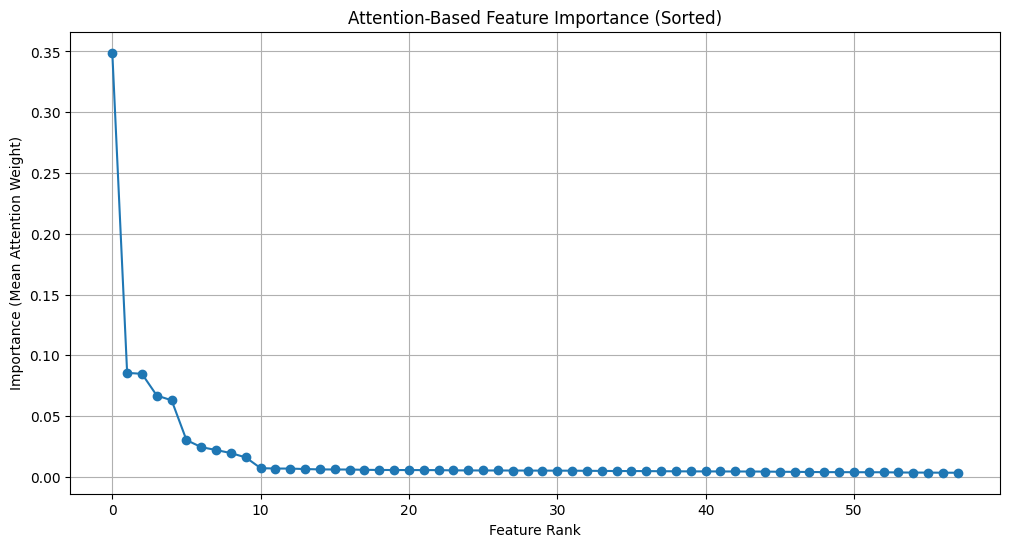


Plotting Permutation Importance for Elbow Method:


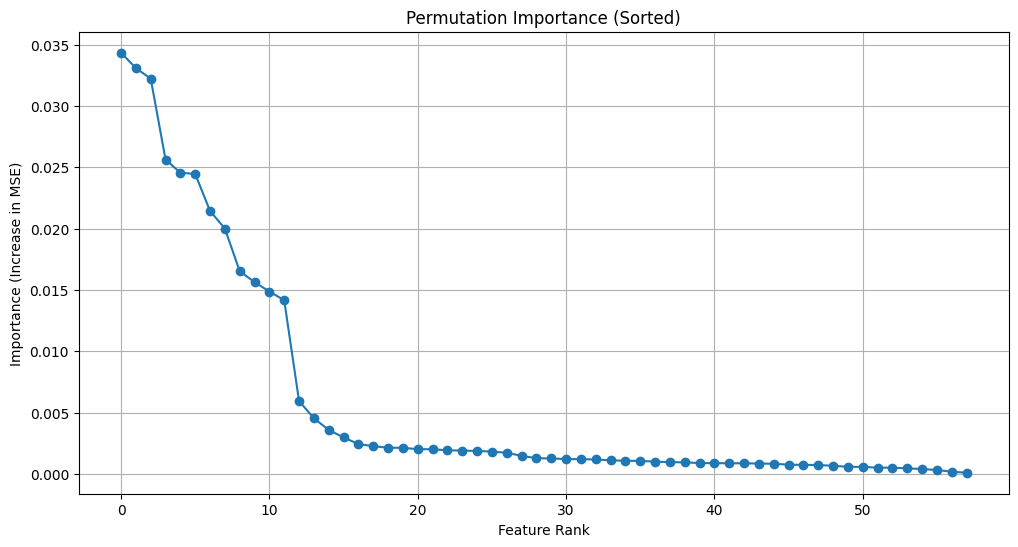

In [22]:
# Visualize Feature Importance for Elbow Method

if 'attention' in results:
    print("\nPlotting Attention-Based Feature Importance for Elbow Method:")
    attention_importance_df = results['attention']['importance_df'].sort_values(by='importance', ascending=False)
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(attention_importance_df)), attention_importance_df['importance'], marker='o', linestyle='-')
    plt.title('Attention-Based Feature Importance (Sorted)')
    plt.xlabel('Feature Rank')
    plt.ylabel('Importance (Mean Attention Weight)')
    plt.grid(True)
    plt.show()

if 'permutation' in results:
    print("\nPlotting Permutation Importance for Elbow Method:")
    permutation_importance_df = results['permutation']['importance_df'].sort_values(by='importance_mean', ascending=False)
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(permutation_importance_df)), permutation_importance_df['importance_mean'], marker='o', linestyle='-')
    plt.title('Permutation Importance (Sorted)')
    plt.xlabel('Feature Rank')
    plt.ylabel('Importance (Increase in MSE)')
    plt.grid(True)
    plt.show()

In [23]:
# --- Extract Top Features from Attention and Permutation Results ---

# Check if results from both methods are available
if 'attention' in results and 'permutation' in results:
    print("Using intersection of top features from Attention and Permutation methods.")

    # Get the importance dataframes
    attention_importance_df = results['attention']['importance_df']
    permutation_importance_df = results['permutation']['importance_df']

    # Ensure dataframes are not empty
    if attention_importance_df.empty:
        print("Warning: Attention importance dataframe is empty. Cannot use intersection. Proceeding with all features.")
        use_filtered_features = False
    elif permutation_importance_df.empty:
        print("Warning: Permutation importance dataframe is empty. Cannot use intersection. Proceeding with all features.")
        use_filtered_features = False
    else:
        # Get the top 30 features from each method
        top_n = 30 # Define the number of top features to consider

        # Handle cases where there are less than top_n features available
        num_attention_features = min(top_n, len(attention_importance_df))
        num_permutation_features = min(top_n, len(permutation_importance_df))

        top_attention_features = set(attention_importance_df['feature'].head(num_attention_features).tolist())
        top_permutation_features = set(permutation_importance_df.index.tolist()[:num_permutation_features]) # Permutation index is feature name

        # Calculate the intersection
        intersect_features = list(top_attention_features.intersection(top_permutation_features))

        if not intersect_features:
            print("Warning: Intersection of top features is empty. Proceeding with all features.")
            use_filtered_features = False
        else:
            print(f"Identified {len(intersect_features)} features in the intersection of top {top_n}:")
            print(intersect_features)
            use_filtered_features = True
            df_initial_selection = df[intersect_features]
            # Get the indices of these intersection features in the original X_full feature list
            # You need the original list of feature names for this mapping
            # Assuming feature_names_clean holds the full list of original feature names
            if 'feature_names_clean' not in globals():
                 print("Error: 'feature_names_clean' variable not found. Cannot map intersection features to indices. Proceeding with all features.")
                 use_filtered_features = False
            else:
                 initial_selected_indices = [feature_names_clean.index(feat) for feat in intersect_features if feat in feature_names_clean]
                 print(f"Intersection feature indices: {initial_selected_indices}")

else:
    print("Attention or Permutation results not found. Proceeding with all features for BIC selection.")
    use_filtered_features = False

Using intersection of top features from Attention and Permutation methods.
Identified 20 features in the intersection of top 30:
['kcal_lag_3p', 'bg_diff_roll_mean_6p', 'bg_diff_roll_mean_12p', 'hour_cos', 'kcal_diff_roll_mean_6p', 'bg_roll_mean_3p', 'bg_lag_4p', 'bg_diff_roll_mean_3p', 'kcal_lag_12p', 'bg_roll_mean_6p', 'kcal_lag_5p', 'kcal_roll_mean_12p', 'bg_lag_12p', 'bg_lag_2p', 'bg_lag_1p', 'hr_roll_mean_6p', 'bg_lag_3p', 'bg_lag_5p', 'dayofweek_cos', 'bg_roll_mean_12p']
Intersection feature indices: [24, 37, 39, 7, 49, 34, 13, 35, 27, 36, 26, 50, 15, 11, 10, 42, 12, 14, 9, 38]


## BIC method

In [24]:
# Define a simple LSTM model
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=5):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

# Helper function to create sequences for LSTM
def create_sequences(data, target_col, sequence_length=12, forecast_horizons=[1, 2, 3, 6, 12]):
    sequences = []
    targets = []

    max_horizon = max(forecast_horizons)

    if max_horizon >= len(data):
        raise ValueError(f"Maximum forecast horizon {max_horizon} is too large for data length {len(data)}")

    for uuid in data['uuid'].unique():
        person_data = data[data['uuid'] == uuid].sort_values('timestamp')

        if len(person_data) < sequence_length + max_horizon:
            print(f"Warning: Not enough data for uuid {uuid}. Skipping.")
            continue

        feature_cols = [col for col in person_data.columns if col not in ['uuid', 'timestamp', target_col]]
        person_features = person_data[feature_cols].values
        person_targets = person_data[target_col].values

        if np.any(np.isnan(person_features)) or np.any(np.isnan(person_targets)):
            print(f"Warning: NaN values found in data for uuid {uuid}. Skipping.")
            continue

        for i in range(sequence_length, len(person_data) - max_horizon + 1):
            sequences.append(person_features[i-sequence_length:i])
            horizon_targets = [person_targets[i + h - 1] for h in forecast_horizons]
            targets.append(horizon_targets)

    if len(sequences) == 0:
        raise ValueError("No valid sequences created. Check your data.")

    return np.array(sequences), np.array(targets)

# Fixed BIC calculation with better error handling
def compute_bic(loss, n_samples, n_params):
    if n_samples <= 0:
        print(f"Warning: Invalid n_samples={n_samples}")
        return float('inf')

    if n_params <= 0:
        print(f"Warning: Invalid n_params={n_params}")
        return float('inf')

    if isinstance(loss, torch.Tensor):
        loss = loss.item()

    if np.isnan(loss) or np.isinf(loss) or loss <= 0:
        print(f"Warning: Invalid loss value: {loss}")
        return float('inf')

    sse = loss * n_samples

    try:
        bic = n_samples * np.log(sse / n_samples) + n_params * np.log(n_samples)

        if np.isnan(bic) or np.isinf(bic):
            print(f"Warning: BIC calculation resulted in {bic}")
            return float('inf')

        return bic
    except Exception as e:
        print(f"Error in BIC calculation: {e}")
        return float('inf')

# Enhanced model fitting with better training
def fit_candidate_model(X, y, input_size, hidden_size, ninit=5, epochs=50, lr=0.001):
    best_model = None
    best_loss = float('inf')

    if X.shape[0] == 0 or y.shape[0] == 0:
        print("Error: Empty input data")
        return None, float('inf')

    if torch.any(torch.isnan(X)) or torch.any(torch.isinf(X)) or torch.any(torch.isnan(y)) or torch.any(torch.isinf(y)):
         print("Error: NaN or Inf values in input data")
         return None, float('inf')


    output_size = y.shape[1] if len(y.shape) > 1 else 1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"    Training with hidden_size={hidden_size}, input_size={input_size}, output_size={output_size}")

    for init_attempt in range(ninit):
        try:
            model = LSTMNet(input_size, hidden_size, output_size)
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
            criterion = nn.MSELoss()

            model.to(device)
            X_device = X.to(device)
            y_device = y.to(device)

            for epoch in range(epochs):
                model.train()
                optimizer.zero_grad()

                output = model(X_device)
                loss = criterion(output, y_device)

                if torch.isnan(loss) or torch.isinf(loss):
                    print(f"    Warning: Invalid loss {loss.item()} at epoch {epoch}, init {init_attempt}")
                    break

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            model.eval()
            with torch.no_grad():
                final_output = model(X_device)
                final_loss = criterion(final_output, y_device).item()

            if not (np.isnan(final_loss) or np.isinf(final_loss)) and final_loss < best_loss:
                best_loss = final_loss
                best_model = deepcopy(model)

        except Exception as e:
            print(f"    Error in training attempt {init_attempt}: {e}")
            continue

    if best_model:
        best_model.to("cpu")

    X = X.to("cpu")
    y = y.to("cpu")

    if best_model is None:
        print("    Error: No valid model found in any initialization")
        return None, float('inf')

    n_params = sum(p.numel() for p in best_model.parameters() if p.requires_grad)
    bic = compute_bic(best_loss, X.shape[0], n_params)

    print(f"    Final loss: {best_loss:.6f}, n_params: {n_params}, BIC: {bic:.2f}")

    return best_model, bic

# Enhanced hidden node selection with better debugging
def hidden_node_selection(X, y, input_size, q_candidates, ninit=5):
    best_bic = float('inf')
    best_q = None

    q_candidates = [q for q in q_candidates if q > 0]
    if not q_candidates:
        print("Warning: No valid positive hidden node candidates provided.")
        return 1

    print(f"  Testing hidden sizes: {q_candidates}")
    print(f"  Data shapes: X={X.shape}, y={y.shape}")

    for q in q_candidates:
        print(f"  Trying hidden size q={q}")
        model, bic = fit_candidate_model(X, y, input_size, q, ninit=ninit)

        if model is not None and bic < best_bic:
            best_bic = bic
            best_q = q
            print(f"    New best BIC: {bic:.2f}")
        else:
            print(f"    BIC: {bic:.2f} (not improved)")


    if best_q is None:
        print("  Warning: No valid models found, using first candidate")
        best_q = q_candidates[0] # Fallback to the first candidate if no valid model is found

    print(f"  Selected hidden size: {best_q} with BIC: {best_bic:.2f}")
    return best_q

# Input node selection (unchanged but with better logging)
def input_node_selection(X_full, y, selected_inputs, hidden_size, ninit=5):
    current_selected_inputs = list(selected_inputs)
    improved = True

    if len(current_selected_inputs) == 0:
         print("Warning: No inputs selected to start input node selection.")
         return []

    X_current = X_full[:, :, current_selected_inputs]
    _, current_bic = fit_candidate_model(X_current, y, len(current_selected_inputs), hidden_size, ninit=ninit)
    print(f"\nStarting Input Selection with {len(current_selected_inputs)} inputs. Initial BIC: {current_bic:.2f}")

    while improved:
        improved = False
        print(f"Current selected inputs count: {len(current_selected_inputs)}")

        # Iterate through a copy of the list because we might modify the original
        for i in sorted(current_selected_inputs, reverse=True):
            trial_inputs = [j for j in current_selected_inputs if j != i]

            if len(trial_inputs) > 0:
                X_trial = X_full[:, :, trial_inputs]
                print(f"  Trying to drop input index {i} ({len(trial_inputs)} inputs remaining)...")
                _, bic_trial = fit_candidate_model(X_trial, y, len(trial_inputs), hidden_size, ninit=ninit)
                print(f"    Trial BIC: {bic_trial:.2f}, Current BIC: {current_bic:.2f}")

                if bic_trial < current_bic:
                    print(f"    BIC improved by dropping input index {i}. Updating selection.")
                    current_selected_inputs = trial_inputs
                    current_bic = bic_trial
                    improved = True
                    break
            else:
                print(f"  Cannot drop input index {i}, only one input remains.")


    print(f"Finished Input Selection. Final selected inputs count: {len(current_selected_inputs)}. Final BIC: {current_bic:.2f}")
    return current_selected_inputs

# --- Modify model_selection to accept initial_selected_indices and q_candidates_initial ---

def model_selection(X_full, y, feature_names, initial_selected_indices=None,
                              q_candidates_initial=[8, 16, 32], q_candidates_fine_tune_step=1,
                              max_fine_tune_iters=5, ninit=3):
    """
    Optimized Model Selection using BIC, starting with a subset of features
    and controlling hidden unit search.

    Parameters:
    -----------
    X_full : torch.Tensor
        The full input feature data (all features).
    y : torch.Tensor
        The target data.
    feature_names : list
        List of names corresponding to the columns in X_full.
    initial_selected_indices : list, optional
        List of integer indices for the features to start with.
        If None, starts with all features.
    q_candidates_initial : list, default [8, 16, 32]
        List of hidden unit sizes to test in the initial hidden node selection step.
    q_candidates_fine_tune_step : int, default 1
        Step size for generating hidden unit candidates during fine-tuning
        (e.g., 1 means test q-1, q, q+1).
    max_fine_tune_iters : int, default 5
        Maximum number of iterations for the fine-tuning step.
    ninit : int, default 3
        Number of initializations for training each candidate model.

    Returns:
    --------
    tuple : (selected_indices, selected_feature_names, final_q)
        List of indices of selected features, list of names of selected features,
        and the final selected hidden size.
    """
    print("Validating input data for model selection...")
    print(f"X_full shape: {X_full.shape}, y shape: {y.shape}")
    # Print range only if tensor is not empty
    if X_full.numel() > 0:
        print(f"X_full range: [{X_full.min():.4f}, {X_full.max():.4f}]")
    if y.numel() > 0:
        print(f"y range: [{y.min():.4f}, {y.max():.4f}]")


    if torch.any(torch.isnan(X_full)) or torch.any(torch.isinf(X_full)) or \
       torch.any(torch.isnan(y)) or torch.any(torch.isinf(y)):
         raise ValueError("NaN or infinite values detected in input data")

    if X_full.shape[0] < 10:
        print(f"Warning: Very small dataset ({X_full.shape[0]} samples)")

    pmax = X_full.shape[2]
    # Use initial_selected_indices if provided, otherwise start with all
    selected_inputs = list(range(pmax)) if initial_selected_indices is None else list(initial_selected_indices)

    # Map indices back to feature names for logging
    initial_selected_feature_names = [feature_names[i] for i in selected_inputs if i < len(feature_names)]
    print(f"Starting Model Selection with {len(selected_inputs)} potential inputs.")
    print(f"Initial inputs: {initial_selected_feature_names}")


    print("\n--- Step 1: Hidden-node Selection (Initial) ---")
    # Check if selected_inputs is empty before subsetting
    if not selected_inputs:
         print("Error: No inputs selected. Cannot perform hidden-node selection.")
         return [], [], 1 # Return empty lists and a default hidden size

    X_sub = X_full[:, :, selected_inputs]
    # Use the provided initial hidden unit candidates
    q = hidden_node_selection(X_sub, y, len(selected_inputs), q_candidates_initial, ninit=ninit)
    print(f"\nInitial hidden size selected: q = {q}")

    print("\n--- Step 2: Input-node Selection (Drop Step) ---")
    # The input_node_selection function works on the indices relative to X_full
    # It modifies the selected_inputs list in place within the function
    selected_inputs = input_node_selection(X_full, y, selected_inputs, q, ninit=ninit)
    print(f"\nInputs selected after initial drop step ({len(selected_inputs)} inputs):")
    selected_feature_names_step2 = [feature_names[i] for i in selected_inputs if i < len(feature_names)]
    print(selected_feature_names_step2)


    print("\n--- Step 3: Fine-tuning (Alternating Hidden/Input Selection) ---")
    improved = True
    iter_count = 0

    while improved and iter_count < max_fine_tune_iters:
        improved = False
        iter_count += 1
        print(f"\nFine-tuning Iteration {iter_count}/{max_fine_tune_iters}")

        print("  Attempting hidden node adjustment...")
        current_q = q
        # Check if selected_inputs is empty before subsetting
        if not selected_inputs:
             print("Warning: No inputs selected during fine-tuning. Skipping hidden node adjustment.")
        else:
            X_sub = X_full[:, :, selected_inputs]
            # Generate fine-tuning candidates based on the current best q and step size
            q_candidates_fine_tune = sorted(list(set([
                max(1, current_q - q_candidates_fine_tune_step),
                current_q,
                current_q + q_candidates_fine_tune_step
            ])))

            # Ensure candidates are positive and within a reasonable range (e.g., not excessively large)
            q_candidates_fine_tune = [cand for cand in q_candidates_fine_tune if cand > 0 and cand <= X_full.shape[1] * 2] # Example upper bound heuristic

            new_q = hidden_node_selection(X_sub, y, len(selected_inputs), q_candidates_fine_tune, ninit=ninit)

            if new_q != current_q:
                q = new_q
                improved = True
                print(f"  Hidden size updated to q = {q}")
            else:
                print(f"  Hidden size remained q = {q}")

        print("\n  Attempting another input selection (drop step)...")
        current_selected_inputs_set = set(selected_inputs)
        # Use the current q for the input selection step
        # Check if selected_inputs is empty before calling input_node_selection
        if not selected_inputs:
             print("Warning: No inputs selected. Skipping input selection drop step.")
             new_selected_inputs = []
        else:
            new_selected_inputs = input_node_selection(X_full, y, selected_inputs, q, ninit=ninit)

        new_selected_inputs_set = set(new_selected_inputs)

        if new_selected_inputs_set != current_selected_inputs_set:
            selected_inputs = new_selected_inputs
            improved = True
            print(f"  Input selection changed. New inputs count: {len(selected_inputs)}")
            selected_feature_names_step3 = [feature_names[i] for i in selected_inputs if i < len(feature_names)]
            print(selected_feature_names_step3)
        else:
            print(f"  Input selection did not change.")


        if not improved:
            print("  No further improvement found in this iteration.")


    if iter_count == max_fine_tune_iters and improved:
        print(f"Warning: Maximum iterations ({max_fine_tune_iters}) reached during fine-tuning. Selection might not have fully converged.")


    print("\n--- Model Selection Complete ---")
    print(f"Final selected input indices ({len(selected_inputs)} features): {selected_inputs}")
    print("Final selected feature names:")
    final_selected_feature_names = [feature_names[i] for i in selected_inputs if i < len(feature_names)]
    print(final_selected_feature_names)
    print(f"Final best hidden size: {q}")

    # Return the list of selected feature names as well
    return selected_inputs, final_selected_feature_names, q

In [ ]:
import pickle
import os
from google.colab import drive
from sklearn.preprocessing import StandardScaler # Ensure StandardScaler is imported
import torch # Ensure torch is imported
import numpy as np # Ensure numpy is imported
import pandas as pd # Ensure pandas is imported

# Re-define create_sequences here as well for self-containment, even though it was added earlier.
# This makes this cell runnable independently if needed.
def create_sequences(data, target_col, sequence_length=12, forecast_horizons=[1, 2, 3, 6, 12]):
    sequences = []
    targets = []

    max_horizon = max(forecast_horizons)

    # Ensure data is sorted by uuid and timestamp before creating sequences
    data = data.sort_values(by=['uuid', 'timestamp'])

    for uuid in data['uuid'].unique():
        person_data = data[data['uuid'] == uuid].copy()

        if len(person_data) < sequence_length + max_horizon:
            # print(f"Warning: Not enough data ({len(person_data)}) for uuid {uuid} for sequence creation (need at least {sequence_length + max_horizon}). Skipping.")
            continue

        feature_cols = [col for col in person_data.columns if col not in ['uuid', 'timestamp', target_col]]
        person_target_values = person_data[target_col].values
        person_feature_values = person_data[feature_cols].values


        # Check for NaN values within the sequence and target window
        # Ensure target_col and feature_cols are fully filled before calling this. If not, handle NaNs before.
        # if np.any(np.isnan(person_target_values)) or np.any(np.isnan(person_feature_values)):
        #     print(f"Warning: NaN values found in target or feature columns for uuid {uuid}. Skipping sequence creation.")
        #     continue


        for i in range(len(person_data) - sequence_length - max_horizon + 1):
             # Ensure we are not trying to access beyond the target array length
             if i + sequence_length + max_horizon - 1 < len(person_target_values):
                  # Input sequence is the feature values for the last 'sequence_length' steps
                  sequence = person_feature_values[i:i+sequence_length]
                  # Target is the value at specified future horizons
                  horizon_targets = [person_target_values[i + sequence_length + h -1] for h in forecast_horizons]

                  # Ensure no NaNs in the generated sequence or targets
                  if not np.any(np.isnan(sequence)) and not np.any(np.isnan(horizon_targets)):
                     sequences.append(sequence)
                     targets.append(horizon_targets)
                  # else:
                      # print(f"Warning: NaN found in generated sequence or target for uuid {uuid} at index {i}. Skipping.")


    if len(sequences) == 0:
        print(f"No valid sequences created after checking for minimum length and NaNs for target '{target_col}'.")
        # Return empty arrays with correct shapes to avoid errors later
        # Assuming feature_cols were successfully identified
        # Need to determine num_features even if no sequences are created
        # Use the columns from the input df to determine feature_cols
        feature_cols_df = [col for col in data.columns if col not in ['uuid', 'timestamp', target_col]]

        if feature_cols_df:
             # Shape: (0, sequence_length, num_features)
             empty_sequences = np.array([], dtype=np.float32).reshape(0, sequence_length, len(feature_cols_df))
        else:
              # Fallback if feature_cols was not defined or empty
              empty_sequences = np.array([], dtype=np.float32).reshape(0, sequence_length, 0)

        # Shape: (0, num_horizons) - Need forecast_horizons list to determine this
        empty_targets = np.array([], dtype=np.float32).reshape(0, len(forecast_horizons))
        return empty_sequences, empty_targets

    # Reshape sequences to be (batch_size, sequence_length, num_features)
    return np.array(sequences), np.array(targets)


# Define the directory in Google Drive where you want to save the cache
cache_dir = '/content/drive/My Drive/DiabetesML' # Update this path to your desired directory

# Define the full path for the cache file
cache_filepath = os.path.join(cache_dir, 'model_selection_cache.pkl')

# Mount Google Drive if not already mounted
# This assumes you have already run the drive.mount('/content/drive') command earlier
# If not, uncomment the next two lines:
# from google.colab import drive
# drive.mount('/content/drive')

# Ensure the cache directory exists
os.makedirs(cache_dir, exist_ok=True)

# Define sequence length here so it's always available
sequence_length = 12 # Assuming sequence_length is defined

# Check if the cache file exists
cached_results = None # Initialize cached_results to None
if os.path.exists(cache_filepath):
    print(f"Loading cached model selection results from {cache_filepath}...")
    try:
        with open(cache_filepath, 'rb') as f:
            cached_results = pickle.load(f)
            # Load all cached items
            selected_inputs = cached_results['selected_inputs']
            best_hidden_size = cached_results['best_hidden_size']
            # Load selected_feature_names from cache if available
            selected_feature_names = cached_results.get('selected_feature_names', None) # Use .get for backward compatibility

        print("Cache loaded successfully.")

        # If selected_feature_names was not in the old cache format, generate it from indices
        if selected_feature_names is None:
            print("Generating selected feature names from indices (old cache format)...")
             # Ensure 'df' and 'feature_names_clean' are available to generate names
            if 'df' in globals() and 'feature_names_clean' in globals():
                try:
                    selected_feature_names = [feature_names_clean[i] for i in selected_inputs]
                    print(f"Generated selected feature names: {selected_feature_names}")
                except Exception as e:
                    print(f"Error generating feature names from indices: {e}. Proceeding with indices only.")
                    # If mapping fails, reset selected_feature_names to None or handle appropriately
                    selected_feature_names = None
            else:
                 print("Warning: 'df' or 'feature_names_clean' not found. Cannot generate selected feature names from indices.")
                 selected_feature_names = None


    except Exception as e:
        print(f"Error loading cache file: {e}. Proceeding to run model selection.")
        # If loading fails, delete the corrupted cache file and proceed to re-run
        os.remove(cache_filepath)
        print(f"Removed potentially corrupted cache file: {cache_filepath}")
        # Reset cached_results and variables to indicate re-run is needed
        cached_results = None
        selected_inputs = None
        best_hidden_size = None
        selected_feature_names = None # Ensure this is also reset

else:
    print("No cache file found. Running model selection...")
    # Set flags to indicate that model selection needs to run
    cached_results = None
    selected_inputs = None
    best_hidden_size = None
    selected_feature_names = None # Ensure this is also reset


# --- Model Selection Code (runs only if cache not loaded) ---
# This part contains your original model selection logic

if cached_results is None:
    print("Starting LSTM Model Selection.")

    # Add data validation before model selection
    try:
        # Create sequences (assuming df is defined and ready)
        # Make sure df is loaded or available at this point
        if 'df' not in globals():
             print("Error: 'df' DataFrame not found. Please ensure 'df' is loaded or created before running model selection.")
             raise NameError("'df' DataFrame not found.")

        # --- FINAL NaN CHECK AND FILL BEFORE SEQUENCE CREATION ---
        # Identify columns that will be used as features and the target
        target_col = 'bg'
        # Assuming feature_names_clean from previous feature engineering cell contains the relevant features
        if 'feature_names_clean' not in globals():
            # If feature_names_clean is not available, infer from df columns
            feature_names_clean = [col for col in df.columns if col not in ['uuid', 'timestamp', target_col]]
            print("Warning: 'feature_names_clean' not found. Inferring feature columns from df.")

        cols_to_check = feature_names_clean + [target_col]

        # Check for NaNs in the relevant columns
        nan_counts_before_final_fill = df[cols_to_check].isnull().sum().sum()

        if nan_counts_before_final_fill > 0:
            print(f"Warning: Found {nan_counts_before_final_fill} NaN values in relevant columns before sequence creation.")
            print("Applying final fillna(0) to these columns.")
            # Apply a final fillna(0) to ensure no NaNs remain in feature/target columns
            df[cols_to_check] = df[cols_to_check].fillna(0)
        else:
            print("No NaN values found in relevant columns before sequence creation.")
        # --- END FINAL NaN CHECK AND FILL ---


        # Create sequences
        # Use the updated df which should now be NaN-free in relevant columns
        # Use the feature_names_clean list to ensure only relevant features are passed for sequence creation
        df_for_sequence = df[['uuid', 'timestamp', target_col] + feature_names_clean].copy()

        # Estimate the dominant time interval from the data
        def get_dominant_interval_minutes_df(df, group_col='uuid', timestamp_col='timestamp'):
            if df.empty or len(df) < 2:
                return pd.Timedelta(minutes=5).total_seconds() / 60.0 # Default to 5 if no data

            df_sorted = df.sort_values(by=[group_col, timestamp_col])
            diffs = df_sorted.groupby(group_col)[timestamp_col].diff().dropna()

            if diffs.empty:
                return pd.Timedelta(minutes=5).total_seconds() / 60.0 # Default if diffs are empty

            # Calculate the mode, handle multiple modes by taking the first
            mode_diff = diffs.mode()
            if mode_diff.empty:
                return pd.Timedelta(minutes=5).total_seconds() / 60.0 # Default if mode is empty

            return mode_diff.iloc[0].total_seconds() / 60.0


        estimated_interval_minutes = get_dominant_interval_minutes_df(df_for_sequence, 'uuid', 'timestamp')
        print(f"Estimated dominant time interval from data for sequences: {estimated_interval_minutes:.2f} minutes.")
        # Convert horizon minutes to steps based on the estimated interval
        # Use the same forecast horizons as the baselines
        forecast_horizons_minutes_list = [5, 10, 15, 30, 45, 60, 120]
        forecast_relative_steps = [max(1, round(h / estimated_interval_minutes)) for h in forecast_horizons_minutes_list]
        # Ensure uniqueness and sort
        forecast_relative_steps = sorted(list(set(forecast_relative_steps)))
        print(f"Forecast horizons in minutes: {forecast_horizons_minutes_list}")
        print(f"Corresponding relative steps from sequence end: {forecast_relative_steps}")


        X, y = create_sequences(
            df_for_sequence,
            target_col=target_col,
            sequence_length=sequence_length, # Assuming sequence_length is defined
            forecast_horizons=forecast_relative_steps # Pass the relative steps here
        )

        # Check if any sequences were created
        if X.shape[0] == 0:
             print("Error: No sequences were created after final NaN handling. This might be due to insufficient data length for all individuals after filtering.")
             # Re-raise the ValueError with more context, or handle it gracefully
             raise ValueError("No valid sequences created after final NaN handling. Check data length per UUID.")


        # Check for issues in raw data (should ideally be handled by fillna, but double check)
        if np.any(np.isnan(X)) or np.any(np.isnan(y)):
            print("ERROR: NaN values found in sequences after creation!")
            # You might want to handle this by interpolation or removal

        # Convert to PyTorch tensors
        X = torch.FloatTensor(X)
        y = torch.FloatTensor(y)

        # Enhanced scaling with validation
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()

        # Reshape and scale X
        X_shape_original = X.shape
        X_reshaped_for_scaling = X.view(-1, X_shape_original[-1])

        # Check if any features have zero variance - print only if found
        X_numpy = X_reshaped_for_scaling.numpy()
        # Use a small tolerance when checking for zero variance
        zero_var_features = np.isclose(np.var(X_numpy, axis=0), 0, atol=1e-9)
        if np.any(zero_var_features):
            zero_var_count = np.sum(zero_var_features)
            print(f"Warning: Found {zero_var_count} features with near-zero variance.") # Reduced print
            # Optionally, remove zero-variance features before scaling
            # X_reshaped_for_scaling = X_reshaped_for_scaling[:, ~zero_var_features]
            # feature_names_clean = [name for i, name in enumerate(feature_names_clean) if ~zero_var_features[i]]
            # print(f"Removed {zero_var_count} zero-variance features.")


        X_scaled_flat = scaler_X.fit_transform(X_reshaped_for_scaling)
        X_scaled = torch.FloatTensor(X_scaled_flat.reshape(X_shape_original))

        # Scale y
        y_shape_original = y.shape
        if len(y_shape_original) == 1:
            y_reshaped_for_scaling = y.unsqueeze(1)
            y_scaled_reshaped = scaler_y.fit_transform(y_reshaped_for_scaling)
            y_scaled = torch.FloatTensor(y_scaled_reshaped).squeeze(1)
        else:
            y_reshaped_for_scaling = y.view(-1, 1)
            y_scaled_reshaped = scaler_y.fit_transform(y_reshaped_for_scaling)
            y_scaled = torch.FloatTensor(y_scaled_reshaped.reshape(y_shape_original))

        # Update with scaled data
        X_full_scaled = X_scaled # Rename to X_full_scaled as this contains all features initially
        y_scaled = y_scaled

        # Define parameters for the optimized selection
        initial_q_candidates = [8, 16, 32] # Customize initial hidden size candidates
        fine_tune_step = 1 # Customize fine-tuning step size for hidden units
        max_fine_tune_iters = 5 # Customize max fine-tuning iterations
        ninit_models = 3 # Customize number of initializations for each model


     # Determine which initial indices to use based on the pre-filtering result
        # Ensure use_filtered_features and initial_selected_indices are available from previous cells
        # If not, default to using all features.
        use_filtered_features = globals().get('use_filtered_features', False)
        initial_selected_indices_from_prev_steps = globals().get('initial_selected_indices', None)

        start_indices = initial_selected_indices_from_prev_steps if use_filtered_features and initial_selected_indices_from_prev_steps is not None else None # Use intersection indices if available and not None

     # Run the optimized model selection
        print("\nStarting Optimized BIC Model Selection...")
        # Pass the potentially updated feature_names_clean
        selected_inputs, selected_feature_names, best_hidden_size = model_selection(
         X_full_scaled, # Use the full scaled data with all features
         y_scaled,
         feature_names_clean, # Pass the full list of feature names
         initial_selected_indices=start_indices, # Pass the intersection indices here
         q_candidates_initial=initial_q_candidates,
         q_candidates_fine_tune_step=fine_tune_step,
         max_fine_tune_iters=max_fine_tune_iters,
         ninit=ninit_models
        )

        print(f"\nModel Selection Complete.") # Indicate completion
        print(f"Selected input feature indices: {selected_inputs}")
        print(f"Best hidden size: {best_hidden_size}")
        print(f"Selected input feature names: {selected_feature_names}")


        # --- Save the results to a cache file ---
        cached_results = {
            'selected_inputs': selected_inputs,
            'best_hidden_size': best_hidden_size,
            'selected_feature_names': selected_feature_names # Save the feature names
        }
        with open(cache_filepath, 'wb') as f:
            pickle.dump(cached_results, f)
        print(f"Model selection results cached to {cache_filepath}")

    except Exception as e:
        print(f"\nAn error occurred during model selection:") # Reduced error print
        import traceback
        traceback.print_exc() # Still print full traceback for debugging
        # No need for detailed suggestions, traceback provides more info

# --- End of Cache Block ---

# Now you can use selected_inputs, selected_feature_names and best_hidden_size for your subsequent steps
# regardless of whether they were loaded from cache or computed.

No cache file found. Running model selection...
Starting LSTM Model Selection.
No NaN values found in relevant columns before sequence creation.
Estimated dominant time interval from data for sequences: 5.00 minutes.
Forecast horizons in minutes: [5, 10, 15, 30, 45, 60, 120]
Corresponding relative steps from sequence end: [1, 2, 3, 6, 9, 12, 24]

Starting Optimized BIC Model Selection...
Validating input data for model selection...
X_full shape: torch.Size([13160, 12, 58]), y shape: torch.Size([13160, 7])
X_full range: [-13.1650, 14.0341]
y range: [-2.0956, 4.8521]
Starting Model Selection with 20 potential inputs.
Initial inputs: ['kcal_lag_3p', 'bg_diff_roll_mean_6p', 'bg_diff_roll_mean_12p', 'hour_cos', 'kcal_diff_roll_mean_6p', 'bg_roll_mean_3p', 'bg_lag_4p', 'bg_diff_roll_mean_3p', 'kcal_lag_12p', 'bg_roll_mean_6p', 'kcal_lag_5p', 'kcal_roll_mean_12p', 'bg_lag_12p', 'bg_lag_2p', 'bg_lag_1p', 'hr_roll_mean_6p', 'bg_lag_3p', 'bg_lag_5p', 'dayofweek_cos', 'bg_roll_mean_12p']

--- Ste

First hypoglycemia threshold is < 70 mg/dl, threshold for hyperglycemia appears to be between 180 and 200 mg/dl. Going to use 180 for now, I guess?

# Fit baseline last value carried forward model

Evaluating baseline model (Last Value Carried Forward) with horizons (minutes): [5, 10, 15, 30, 45, 60, 120]
Corresponding forecast steps (assuming 5 min interval): [1, 2, 3, 6, 9, 12, 24]

--- Evaluating Horizon: 5 minutes (1 steps) ---
  Regression - MAE: 2.94, RMSE: 4.50, R2: 0.98
  Hypo Classification - Accuracy: 1.00, Precision: 0.91, Recall: 0.91, F1: 0.91
  Hyper Classification - Accuracy: 0.99, Precision: 0.94, Recall: 0.94, F1: 0.94

--- Evaluating Horizon: 10 minutes (2 steps) ---
  Regression - MAE: 5.28, RMSE: 8.02, R2: 0.94
  Hypo Classification - Accuracy: 1.00, Precision: 0.82, Recall: 0.82, F1: 0.82
  Hyper Classification - Accuracy: 0.98, Precision: 0.88, Recall: 0.88, F1: 0.88

--- Evaluating Horizon: 15 minutes (3 steps) ---
  Regression - MAE: 7.21, RMSE: 10.93, R2: 0.88
  Hypo Classification - Accuracy: 1.00, Precision: 0.74, Recall: 0.74, F1: 0.74
  Hyper Classification - Accuracy: 0.97, Precision: 0.83, Recall: 0.83, F1: 0.83

--- Evaluating Horizon: 30 minutes (

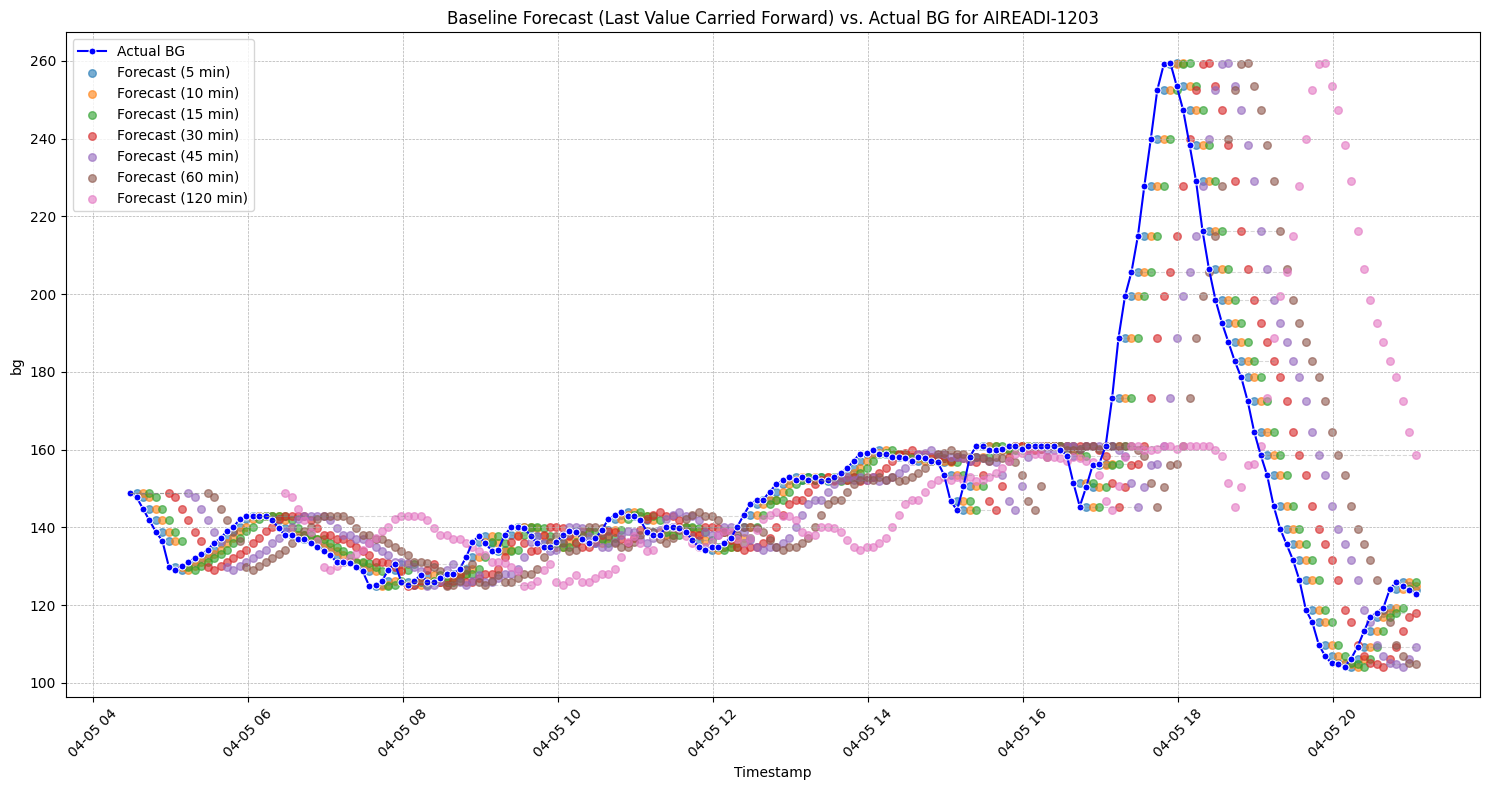

In [ ]:
# prompt: For the purposes of comparing the eventual final model, I want to calculate the predictive accuracy of a model which merely uses as a forecast the most recent value of bg carried forward. Calculate relevant metrics of predictive accuracy at a forecast horizon of 5 mins (1 step), 10 mins (2 steps), 15 mins (3 steps), 30 minutes(6 steps), 45 minutes (9 steps), 1 hour (12 steps), and 2 hours (24 steps). I'm also interested in how well my models can predict whether a person will be hypoglycemic (a bg less than 70) or hyperglycemic (a bg greater than 180) using the same time horizons. Use the same most recent bg value carried forward to determine if the model is predicting a hyper or hypoglycemic event and compute relevant performance metrics for this categorization. Also, give me some code so I can visualize what  the forecast looks like at different time horizons so I can verify these metrics are being calculated correctly

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_baseline_metrics(df, forecast_horizons_minutes, target_col='bg', time_interval_minutes=5, hypo_threshold=70, hyper_threshold=180):
    """
    Calculates predictive accuracy and classification metrics for a baseline model
    that uses the most recent value carried forward as the forecast.

    Args:
        df (pd.DataFrame): DataFrame with 'uuid', 'timestamp', and target_col.
        forecast_horizons_minutes (list): List of forecast horizons in minutes.
        target_col (str): Name of the target column (e.g., 'bg').
        time_interval_minutes (int): The regular time interval of the data in minutes.
        hypo_threshold (float): The threshold for hypoglycemia.
        hyper_threshold (float): The threshold for hyperglycemia.

    Returns:
        dict: A dictionary containing accuracy and classification metrics for each horizon.
    """
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values(by=['uuid', 'timestamp'])

    results = {}
    forecast_steps = [int(h / time_interval_minutes) for h in forecast_horizons_minutes]

    print(f"Evaluating baseline model (Last Value Carried Forward) with horizons (minutes): {forecast_horizons_minutes}")
    print(f"Corresponding forecast steps (assuming {time_interval_minutes} min interval): {forecast_steps}")

    for horizon_minutes, steps in zip(forecast_horizons_minutes, forecast_steps):
        print(f"\n--- Evaluating Horizon: {horizon_minutes} minutes ({steps} steps) ---")
        horizon_results = {}

        y_true_list = []
        y_pred_list = []

        y_true_hypo_list = []
        y_pred_hypo_list = []
        y_true_hyper_list = []
        y_pred_hyper_list = []

        for uuid in df['uuid'].unique():
            person_data = df[df['uuid'] == uuid].copy().sort_values('timestamp')

            if len(person_data) <= steps:
                # print(f"Skipping uuid {uuid}: Not enough data for horizon {horizon_minutes} min ({steps} steps).")
                continue

            # Shift target_col to get the actual future value
            # forecast_horizon steps into the future
            actual_future_bg = person_data[target_col].shift(-steps)

            # The forecast is the current value (before shifting)
            predicted_bg = person_data[target_col].copy()

            # Align actual and predicted values and drop rows with NaN
            combined = pd.DataFrame({
                'actual': actual_future_bg,
                'predicted': predicted_bg
            }).dropna()

            if combined.empty:
                # print(f"Skipping uuid {uuid}: No valid pairs found for horizon {horizon_minutes} min after dropping NaNs.")
                continue

            y_true_list.extend(combined['actual'].tolist())
            y_pred_list.extend(combined['predicted'].tolist())

            # Classification for Hypoglycemia (< hypo_threshold)
            actual_hypo = (combined['actual'] < hypo_threshold).astype(int)
            predicted_hypo = (combined['predicted'] < hypo_threshold).astype(int)
            y_true_hypo_list.extend(actual_hypo.tolist())
            y_pred_hypo_list.extend(predicted_hypo.tolist())

            # Classification for Hyperglycemia (> hyper_threshold)
            actual_hyper = (combined['actual'] > hyper_threshold).astype(int)
            predicted_hyper = (combined['predicted'] > hyper_threshold).astype(int)
            y_true_hyper_list.extend(actual_hyper.tolist())
            y_pred_hyper_list.extend(predicted_hyper.tolist())


        # --- Calculate Regression Metrics ---
        if len(y_true_list) > 0:
            y_true_np = np.array(y_true_list)
            y_pred_np = np.array(y_pred_list)

            # Ensure arrays are clean (should be after dropna, but double check)
            valid_indices = ~np.isnan(y_true_np) & ~np.isnan(y_pred_np)
            y_true_np = y_true_np[valid_indices]
            y_pred_np = y_pred_np[valid_indices]

            if len(y_true_np) > 0:
                horizon_results['regression'] = {
                    'MAE': mean_absolute_error(y_true_np, y_pred_np),
                    'RMSE': np.sqrt(mean_squared_error(y_true_np, y_pred_np)),
                    'R2': r2_score(y_true_np, y_pred_np)
                }
                print(f"  Regression - MAE: {horizon_results['regression']['MAE']:.2f}, RMSE: {horizon_results['regression']['RMSE']:.2f}, R2: {horizon_results['regression']['R2']:.2f}")
            else:
                 print(f"  No valid data points for regression at {horizon_minutes} min horizon.")
                 horizon_results['regression'] = None
        else:
            print(f"  No data available to calculate regression metrics at {horizon_minutes} min horizon.")
            horizon_results['regression'] = None


        # --- Calculate Classification Metrics (Hypoglycemia) ---
        if len(y_true_hypo_list) > 0 and (1 in y_true_hypo_list or 0 in y_true_hypo_list):
             y_true_hypo_np = np.array(y_true_hypo_list)
             y_pred_hypo_np = np.array(y_pred_hypo_list)

             if len(np.unique(y_true_hypo_np)) < 2:
                 print(f"  Warning: Only one class present in actual hypo labels at {horizon_minutes} min horizon. Cannot compute full classification metrics.")
                 horizon_results['hypo_classification'] = {
                      'Accuracy': accuracy_score(y_true_hypo_np, y_pred_hypo_np),
                      'Confusion Matrix': confusion_matrix(y_true_hypo_np, y_pred_hypo_np).tolist(),
                      'Note': 'Only one true class present (hypo) - precision/recall/f1/roc might be misleading or fail.'
                 }
                 print(f"  Hypo Classification - Accuracy: {horizon_results['hypo_classification']['Accuracy']:.2f}")
             else:
                horizon_results['hypo_classification'] = {
                    'Accuracy': accuracy_score(y_true_hypo_np, y_pred_hypo_np),
                    'Precision': precision_score(y_true_hypo_np, y_pred_hypo_np, zero_division=0), # Handle no positive predictions
                    'Recall': recall_score(y_true_hypo_np, y_pred_hypo_np, zero_division=0), # Handle no true positives
                    'F1 Score': f1_score(y_true_hypo_np, y_pred_hypo_np, zero_division=0),
                    'Confusion Matrix': confusion_matrix(y_true_hypo_np, y_pred_hypo_np).tolist()
                }
                # ROC AUC requires prediction probabilities or scores, using binary prediction here might not be meaningful
                # unless we get 'distance from threshold' as a score. For binary prediction, AUC is just related to sensitivity/specificity.
                # Adding AUC only if meaningful
                try:
                     # Check if predicted_bg can be used as a score (lower values indicate higher chance of hypo)
                     # Need to align predicted_bg to the y_true_hypo_np
                     aligned_predicted_bg = combined['predicted'].values[valid_indices] # Use valid_indices from regression if needed
                     horizon_results['hypo_classification']['AUC'] = roc_auc_score(y_true_hypo_np, -aligned_predicted_bg) # -aligned_predicted_bg because lower BG means higher hypo risk
                except Exception as auc_e:
                     print(f"  Warning: Could not calculate Hypo AUC: {auc_e}")
                     horizon_results['hypo_classification']['AUC'] = None


                print(f"  Hypo Classification - Accuracy: {horizon_results['hypo_classification']['Accuracy']:.2f}, Precision: {horizon_results['hypo_classification']['Precision']:.2f}, Recall: {horizon_results['hypo_classification']['Recall']:.2f}, F1: {horizon_results['hypo_classification']['F1 Score']:.2f}")
                if horizon_results['hypo_classification']['AUC'] is not None:
                    print(f"  Hypo Classification - AUC: {horizon_results['hypo_classification']['AUC']:.2f}")

        else:
            print(f"  No data available to calculate hypo classification metrics at {horizon_minutes} min horizon.")
            horizon_results['hypo_classification'] = None


        # --- Calculate Classification Metrics (Hyperglycemia) ---
        if len(y_true_hyper_list) > 0 and (1 in y_true_hyper_list or 0 in y_true_hyper_list):
             y_true_hyper_np = np.array(y_true_hyper_list)
             y_pred_hyper_np = np.array(y_pred_hyper_list)

             if len(np.unique(y_true_hyper_np)) < 2:
                 print(f"  Warning: Only one class present in actual hyper labels at {horizon_minutes} min horizon. Cannot compute full classification metrics.")
                 horizon_results['hyper_classification'] = {
                      'Accuracy': accuracy_score(y_true_hyper_np, y_pred_hyper_np),
                      'Confusion Matrix': confusion_matrix(y_true_hyper_np, y_pred_hyper_np).tolist(),
                       'Note': 'Only one true class present (hyper) - precision/recall/f1/roc might be misleading or fail.'
                 }
                 print(f"  Hyper Classification - Accuracy: {horizon_results['hyper_classification']['Accuracy']:.2f}")
             else:
                horizon_results['hyper_classification'] = {
                    'Accuracy': accuracy_score(y_true_hyper_np, y_pred_hyper_np),
                    'Precision': precision_score(y_true_hyper_np, y_pred_hyper_np, zero_division=0), # Handle no positive predictions
                    'Recall': recall_score(y_true_hyper_np, y_pred_hyper_np, zero_division=0), # Handle no true positives
                    'F1 Score': f1_score(y_true_hyper_np, y_pred_hyper_np, zero_division=0),
                    'Confusion Matrix': confusion_matrix(y_true_hyper_np, y_pred_hyper_np).tolist()
                }
                # AUC for hyper: higher BG means higher hyper risk
                try:
                     # Check if predicted_bg can be used as a score
                     aligned_predicted_bg = combined['predicted'].values[valid_indices]
                     horizon_results['hyper_classification']['AUC'] = roc_auc_score(y_true_hyper_np, aligned_predicted_bg) # aligned_predicted_bg for hyper risk
                except Exception as auc_e:
                     print(f"  Warning: Could not calculate Hyper AUC: {auc_e}")
                     horizon_results['hyper_classification']['AUC'] = None

                print(f"  Hyper Classification - Accuracy: {horizon_results['hyper_classification']['Accuracy']:.2f}, Precision: {horizon_results['hyper_classification']['Precision']:.2f}, Recall: {horizon_results['hyper_classification']['Recall']:.2f}, F1: {horizon_results['hyper_classification']['F1 Score']:.2f}")
                if horizon_results['hyper_classification']['AUC'] is not None:
                    print(f"  Hyper Classification - AUC: {horizon_results['hyper_classification']['AUC']:.2f}")

        else:
            print(f"  No data available to calculate hyper classification metrics at {horizon_minutes} min horizon.")
            horizon_results['hyper_classification'] = None


        results[horizon_minutes] = horizon_results

    return results

def visualize_baseline_forecast(df, uuid_to_plot, forecast_horizons_minutes, target_col='bg', time_interval_minutes=5, num_points=100):
    """
    Visualizes the baseline forecast (Last Value Carried Forward) vs. actual BG
    for a specific individual and selected forecast horizons.

    Args:
        df (pd.DataFrame): DataFrame with 'uuid', 'timestamp', and target_col.
        uuid_to_plot (str): The UUID of the individual to plot.
        forecast_horizons_minutes (list): List of forecast horizons in minutes to visualize.
        target_col (str): Name of the target column (e.g., 'bg').
        time_interval_minutes (int): The regular time interval of the data in minutes.
        num_points (int): The number of recent data points to plot for visualization.
    """
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values(by=['uuid', 'timestamp'])

    person_data = df[df['uuid'] == uuid_to_plot].copy().sort_values('timestamp')

    if person_data.empty:
        print(f"No data found for UUID {uuid_to_plot}.")
        return

    print(f"\nVisualizing Baseline Forecast for UUID: {uuid_to_plot}")

    # Select the most recent 'num_points' data points
    if len(person_data) > num_points:
        person_data = person_data.tail(num_points)

    plt.figure(figsize=(15, 8))
    sns.lineplot(data=person_data, x='timestamp', y=target_col, label='Actual BG', color='blue', marker='o', markersize=5, linewidth=1.5)

    forecast_steps = [int(h / time_interval_minutes) for h in forecast_horizons_minutes]

    for horizon_minutes, steps in zip(forecast_horizons_minutes, forecast_steps):
        if len(person_data) <= steps:
            print(f"Skipping visualization for {horizon_minutes} min horizon: Not enough data points in the selected window ({len(person_data)} points vs {steps} steps needed).")
            continue

        # Actual future values for this horizon
        actual_future_bg = person_data[target_col].shift(-steps)
        actual_future_bg = actual_future_bg.dropna() # Drop NaNs where future value is unavailable

        # Baseline forecast (Last Value Carried Forward)
        # The forecast for time t+steps is the value at time t.
        # We need to plot this predicted value at time t+steps,
        # but the 'predicted' value itself is from time t.
        # So, for each point at time 't' where we have an actual 't+steps' value,
        # the prediction is the value at 't'. We want to plot this prediction
        # aligned with the actual future time 't+steps'.

        # Let's create a new dataframe to align the actual and predicted points for plotting
        plot_data = person_data[['timestamp', target_col]].copy()
        plot_data['future_timestamp'] = plot_data['timestamp'] + pd.Timedelta(minutes=horizon_minutes)
        plot_data['actual_future_bg'] = plot_data[target_col].shift(-steps)
        plot_data['predicted_bg'] = plot_data[target_col] # The prediction for future_timestamp is the current value

        # Drop rows where actual future or predicted values are NaN
        plot_data_valid = plot_data.dropna(subset=['actual_future_bg', 'predicted_bg'])

        if plot_data_valid.empty:
             print(f"No valid data points for plotting {horizon_minutes} min horizon after alignment.")
             continue


        # Plot the predicted points at their future time
        plt.scatter(plot_data_valid['future_timestamp'], plot_data_valid['predicted_bg'],
                    label=f'Forecast ({horizon_minutes} min)', alpha=0.6, s=30)

        # Optionally plot lines connecting the current point to the forecast point
        # for a specific subset of points to show the forecast mechanism
        sample_indices = np.linspace(0, len(plot_data_valid) - 1, 10, dtype=int) # Select ~10 points to show lines
        for idx in sample_indices:
            plt.plot([plot_data_valid['timestamp'].iloc[idx], plot_data_valid['future_timestamp'].iloc[idx]],
                     [plot_data_valid['predicted_bg'].iloc[idx], plot_data_valid['predicted_bg'].iloc[idx]],
                     linestyle='--', color='gray', linewidth=0.8, alpha=0.3) # Horizontal line for LVCF

    plt.title(f'Baseline Forecast (Last Value Carried Forward) vs. Actual BG for {uuid_to_plot}')
    plt.xlabel('Timestamp')
    plt.ylabel(target_col)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# --- Example Usage ---

# Ensure 'df' DataFrame is loaded or created from previous steps and is imputed/cleaned.
# Assuming df is a pandas DataFrame with 'uuid', 'timestamp', and 'bg' columns.

# Define the forecast horizons in minutes
forecast_horizons = [5, 10, 15, 30, 45, 60, 120] # Corresponding to 1, 2, 3, 6, 9, 12, 24 steps if interval is 5 mins

# Assuming the data interval is 5 minutes (adjust if needed)
time_interval = 5

# Define BG thresholds
hypo_thresh = 70
hyper_thresh = 180

# Calculate and print metrics
# Ensure df is available and contains the necessary columns ('uuid', 'timestamp', 'bg')
if 'df' in globals():
    baseline_metrics = evaluate_baseline_metrics(
        df,
        forecast_horizons,
        target_col='bg',
        time_interval_minutes=time_interval,
        hypo_threshold=hypo_thresh,
        hyper_threshold=hyper_thresh
    )

    print("\n--- Baseline Model Evaluation Results ---")
    for horizon, metrics in baseline_metrics.items():
        print(f"\nHorizon: {horizon} minutes")
        if metrics['regression']:
            print("  Regression Metrics:")
            for key, value in metrics['regression'].items():
                print(f"    {key}: {value:.4f}")
        if metrics['hypo_classification']:
            print("  Hypoglycemia (<70 mg/dL) Classification Metrics:")
            for key, value in metrics['hypo_classification'].items():
                 if isinstance(value, float):
                      print(f"    {key}: {value:.4f}")
                 else:
                       print(f"    {key}: {value}")
        if metrics['hyper_classification']:
            print("  Hyperglycemia (>180 mg/dL) Classification Metrics:")
            for key, value in metrics['hyper_classification'].items():
                 if isinstance(value, float):
                      print(f"    {key}: {value:.4f}")
                 else:
                       print(f"    {key}: {value}")

else:
    print("Error: 'df' DataFrame not found. Cannot run baseline evaluation.")


# Visualize the baseline forecast for a random UUID
# Ensure df is available and contains 'uuid'
if 'df' in globals() and not df['uuid'].empty:
    # Select a random UUID that has enough data points
    # Estimate the minimum required data points for the longest horizon
    min_data_points_for_viz = int(max(forecast_horizons) / time_interval) + 100 # Add some buffer for plotting
    valid_uuids = df.groupby('uuid').filter(lambda x: len(x) >= min_data_points_for_viz)['uuid'].unique()

    if len(valid_uuids) > 0:
        random_uuid_for_viz = np.random.choice(valid_uuids)
        print(f"\nSelecting UUID {random_uuid_for_viz} for visualization.")
        visualize_baseline_forecast(
            df,
            random_uuid_for_viz,
            forecast_horizons,
            target_col='bg',
            time_interval_minutes=time_interval,
            num_points=200 # Plot the last 200 points
        )
    else:
        print("\nNo UUID found with enough data points to visualize all horizons.")
        # Try visualizing with a shorter list of horizons if no UUID meets the requirement
        short_horizons = [5, 15, 60]
        valid_uuids_short = df.groupby('uuid').filter(lambda x: len(x) >= int(max(short_horizons) / time_interval) + 100)['uuid'].unique()
        if len(valid_uuids_short) > 0:
             random_uuid_for_viz_short = np.random.choice(valid_uuids_short)
             print(f"\nNo UUID found for full visualization, visualizing a subset of horizons for UUID {random_uuid_for_viz_short}.")
             visualize_baseline_forecast(
                 df,
                 random_uuid_for_viz_short,
                 short_horizons,
                 target_col='bg',
                 time_interval_minutes=time_interval,
                 num_points=200
             )
        else:
             print("\nCould not find any UUID with enough data even for a short visualization.")

elif 'df' not in globals():
     print("Error: 'df' DataFrame not found. Cannot run visualization.")
else:
     print("Error: 'df' DataFrame is empty. Cannot run visualization.")



In [28]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score
from typing import List, Dict, Tuple

class MovingAverageBaseline:
    """
    Simple Moving Average Baseline Model for Blood Glucose Prediction

    Creates moving averages of bg values to predict future BG and hyper/hypoglycemic events
    at multiple forecast horizons. This is a true baseline using only historical BG patterns.
    """

    def __init__(self, window_sizes: List[int] = [3, 5, 7, 10]):
        """
        Initialize the moving average baseline model.

        Args:
            window_sizes: List of window sizes to try for moving average of bg
        """
        self.window_sizes = window_sizes
        self.best_window = None
        self.forecast_horizons = [5, 10, 15, 30, 45, 60, 120]  # minutes

    def _create_bg_moving_averages(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Create moving average features from bg values.

        Args:
            df: Input dataframe

        Returns:
            DataFrame with bg moving average features
        """
        df_ma = df.copy()

        # Sort by uuid and timestamp
        df_ma = df_ma.sort_values(['uuid', 'timestamp'])

        # Create moving average of bg for each window size
        for window in self.window_sizes:
            df_ma[f'bg_ma_{window}'] = (
                df_ma.groupby('uuid')['bg']
                .rolling(window=window, min_periods=1)
                .mean()
                .reset_index(level=0, drop=True)
            )

        return df_ma

    def _create_targets(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Create target variables for different forecast horizons.

        Args:
            df: Input dataframe

        Returns:
            DataFrame with target variables
        """
        df_targets = df.copy()

        # Ensure timestamp is datetime
        if not pd.api.types.is_datetime64_any_dtype(df_targets['timestamp']):
            df_targets['timestamp'] = pd.to_datetime(df_targets['timestamp'])

        # Sort by uuid and timestamp
        df_targets = df_targets.sort_values(['uuid', 'timestamp'])

        # Create targets for each forecast horizon
        for horizon in self.forecast_horizons:
            # Calculate number of steps ahead (assuming 5-minute intervals)
            steps_ahead = horizon // 5

            # Create future BG targets
            df_targets[f'bg_target_{horizon}min'] = (
                df_targets.groupby('uuid')['bg']
                .shift(-steps_ahead)
            )

            # Create binary targets for hyper/hypoglycemic events
            df_targets[f'hyper_target_{horizon}min'] = (
                df_targets[f'bg_target_{horizon}min'] > 180
            ).astype(int)

            df_targets[f'hypo_target_{horizon}min'] = (
                df_targets[f'bg_target_{horizon}min'] < 70
            ).astype(int)

        return df_targets

    def prepare_data(self, df: pd.DataFrame, train_end_date: str = None,
                    val_end_date: str = None) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """
        Prepare data with moving average features, targets, and time-based splits.

        Args:
            df: Input dataframe with columns: uuid, bg, timestamp
            train_end_date: End date for training set (format: 'YYYY-MM-DD')
            val_end_date: End date for validation set (format: 'YYYY-MM-DD')

        Returns:
            Tuple of (train_df, val_df, test_df)
        """
        # Ensure timestamp is datetime
        df_processed = df.copy()
        if not pd.api.types.is_datetime64_any_dtype(df_processed['timestamp']):
            df_processed['timestamp'] = pd.to_datetime(df_processed['timestamp'])

        # Sort by uuid and timestamp
        df_processed = df_processed.sort_values(['uuid', 'timestamp'])

        # Create moving average features
        df_processed = self._create_bg_moving_averages(df_processed)

        # Create targets
        df_processed = self._create_targets(df_processed)

        # Time-based splits
        if train_end_date is None or val_end_date is None:
            # Auto-determine split dates based on data range
            min_date = df_processed['timestamp'].min()
            max_date = df_processed['timestamp'].max()
            date_range = max_date - min_date

            # Use 70% for training, 15% for validation, 15% for testing
            train_end_date = min_date + pd.Timedelta(days=date_range.days * 0.7)
            val_end_date = min_date + pd.Timedelta(days=date_range.days * 0.85)

            print(f"Auto-determined splits:")
            print(f"  Training: {min_date.date()} to {train_end_date.date()}")
            print(f"  Validation: {train_end_date.date()} to {val_end_date.date()}")
            print(f"  Testing: {val_end_date.date()} to {max_date.date()}")
        else:
            train_end_date = pd.to_datetime(train_end_date)
            val_end_date = pd.to_datetime(val_end_date)

        # Split data
        train_df = df_processed[df_processed['timestamp'] < train_end_date].copy()
        val_df = df_processed[
            (df_processed['timestamp'] >= train_end_date) &
            (df_processed['timestamp'] < val_end_date)
        ].copy()
        test_df = df_processed[df_processed['timestamp'] >= val_end_date].copy()

        print(f"\nDataset sizes:")
        print(f"  Training: {len(train_df)} observations")
        print(f"  Validation: {len(val_df)} observations")
        print(f"  Testing: {len(test_df)} observations")

        return train_df, val_df, test_df

    def fit(self, train_df: pd.DataFrame, val_df: pd.DataFrame):
        """
        Fit the model by selecting the best window size using validation data.

        Args:
            train_df: Training data (not used in this simple baseline)
            val_df: Validation data for window size selection
        """
        best_mae = float('inf')

        print("Selecting best moving average window size...")

        # Try each window size on validation set
        for window in self.window_sizes:
            ma_col = f'bg_ma_{window}'

            if ma_col not in val_df.columns:
                continue

            predictions = val_df[ma_col]

            # Calculate MAE for shortest horizon (5 minutes) to select best window
            target = val_df['bg_target_5min']

            # Remove NaN values
            mask = ~(predictions.isna() | target.isna())
            if mask.sum() == 0:
                continue

            mae = mean_absolute_error(target[mask], predictions[mask])

            print(f"  Window {window}: MAE = {mae:.2f} ({mask.sum()} samples)")

            if mae < best_mae:
                best_mae = mae
                self.best_window = window

        if self.best_window is None:
            self.best_window = self.window_sizes[0]
            print(f"Warning: Could not determine best window. Using default: {self.best_window}")
        else:
            print(f"\nBest window size selected: {self.best_window} (Validation MAE: {best_mae:.2f})")

    def predict(self, test_df: pd.DataFrame) -> Dict[str, np.ndarray]:
        """
        Make predictions for all forecast horizons using the best moving average.

        Args:
            test_df: Test data

        Returns:
            Dictionary with predictions for each horizon and event type
        """
        if self.best_window is None:
            raise ValueError("Model not fitted. Call fit() first.")

        predictions = {}

        # Get the best moving average predictions
        ma_col = f'bg_ma_{self.best_window}'
        if ma_col not in test_df.columns:
            raise ValueError(f"Moving average column {ma_col} not found in test data")

        bg_predictions = test_df[ma_col]

        # For each forecast horizon, use the same moving average prediction
        # (This is a simplification - real MA models might adjust for longer horizons)
        for horizon in self.forecast_horizons:
            predictions[f'bg_pred_{horizon}min'] = bg_predictions.values

            # Predict hyper/hypoglycemic events based on BG predictions
            predictions[f'hyper_pred_{horizon}min'] = (bg_predictions > 180).astype(int).values
            predictions[f'hypo_pred_{horizon}min'] = (bg_predictions < 70).astype(int).values

        return predictions

    def evaluate(self, test_df: pd.DataFrame, predictions: Dict[str, np.ndarray]) -> Dict[str, Dict[str, float]]:
        """
        Evaluate predictions across all horizons and metrics.

        Args:
            test_df: Test data with targets
            predictions: Dictionary of predictions from predict()

        Returns:
            Dictionary of metrics for each horizon and prediction type
        """
        results = {}

        for horizon in self.forecast_horizons:
            results[f'{horizon}min'] = {}

            # BG regression metrics
            bg_pred = predictions[f'bg_pred_{horizon}min']
            bg_target = test_df[f'bg_target_{horizon}min']

            # Remove NaN values
            mask = ~(pd.isna(bg_pred) | pd.isna(bg_target))
            if mask.sum() > 0:
                results[f'{horizon}min']['bg_mae'] = mean_absolute_error(bg_target[mask], bg_pred[mask])
                results[f'{horizon}min']['bg_rmse'] = np.sqrt(mean_squared_error(bg_target[mask], bg_pred[mask]))
                results[f'{horizon}min']['n_samples'] = mask.sum()

            # Hyperglycemic event classification metrics
            hyper_pred = predictions[f'hyper_pred_{horizon}min']
            hyper_target = test_df[f'hyper_target_{horizon}min']

            mask = ~(pd.isna(hyper_pred) | pd.isna(hyper_target))
            if mask.sum() > 0 and len(np.unique(hyper_target[mask])) > 1:
                results[f'{horizon}min']['hyper_accuracy'] = accuracy_score(hyper_target[mask], hyper_pred[mask])
                results[f'{horizon}min']['hyper_precision'] = precision_score(hyper_target[mask], hyper_pred[mask], zero_division=0)
                results[f'{horizon}min']['hyper_recall'] = recall_score(hyper_target[mask], hyper_pred[mask], zero_division=0)
                results[f'{horizon}min']['hyper_f1'] = f1_score(hyper_target[mask], hyper_pred[mask], zero_division=0)

            # Hypoglycemic event classification metrics
            hypo_pred = predictions[f'hypo_pred_{horizon}min']
            hypo_target = test_df[f'hypo_target_{horizon}min']

            mask = ~(pd.isna(hypo_pred) | pd.isna(hypo_target))
            if mask.sum() > 0 and len(np.unique(hypo_target[mask])) > 1:
                results[f'{horizon}min']['hypo_accuracy'] = accuracy_score(hypo_target[mask], hypo_pred[mask])
                results[f'{horizon}min']['hypo_precision'] = precision_score(hypo_target[mask], hypo_pred[mask], zero_division=0)
                results[f'{horizon}min']['hypo_recall'] = recall_score(hypo_target[mask], hypo_pred[mask], zero_division=0)
                results[f'{horizon}min']['hypo_f1'] = f1_score(hypo_target[mask], hypo_pred[mask], zero_division=0)

        return results

# Usage example:

# Initialize the moving average baseline model
ma_baseline = MovingAverageBaseline(window_sizes=[3, 5, 7, 10, 15])

# Prepare data with automatic time-based splits
# df should have columns: uuid, bg, timestamp
train_df, val_df, test_df = ma_baseline.prepare_data(df)

# Or specify custom split dates:
# train_df, val_df, test_df = ma_baseline.prepare_data(df,
#                                                      train_end_date='2023-08-01',
#                                                      val_end_date='2023-09-01')

# Fit the model (selects best window size)
ma_baseline.fit(train_df, val_df)

# Make predictions
predictions = ma_baseline.predict(test_df)

# Evaluate
results = ma_baseline.evaluate(test_df, predictions)

# Print results
print("\n" + "="*50)
print("MOVING AVERAGE BASELINE RESULTS")
print("="*50)

for horizon, metrics in results.items():
    print(f"\n{horizon} Results:")
    for metric, value in metrics.items():
        if isinstance(value, (int, float)):
            print(f"  {metric}: {value:.4f}")
        else:
            print(f"  {metric}: {value}")


Auto-determined splits:
  Training: 2023-12-12 to 2024-04-18
  Validation: 2024-04-18 to 2024-05-16
  Testing: 2024-05-16 to 2024-06-13

Dataset sizes:
  Training: 8565 observations
  Validation: 0 observations
  Testing: 5721 observations
Selecting best moving average window size...

MOVING AVERAGE BASELINE RESULTS

5min Results:
  bg_mae: 4.8163
  bg_rmse: 6.9883
  n_samples: 5719
  hyper_accuracy: 0.9771
  hyper_precision: 0.9101
  hyper_recall: 0.9161
  hyper_f1: 0.9131
  hypo_accuracy: 0.9993
  hypo_precision: 0.3333
  hypo_recall: 0.3333
  hypo_f1: 0.3333

10min Results:
  bg_mae: 6.7451
  bg_rmse: 9.7758
  n_samples: 5717
  hyper_accuracy: 0.9680
  hyper_precision: 0.8757
  hyper_recall: 0.8815
  hyper_f1: 0.8786
  hypo_accuracy: 0.9990
  hypo_precision: 0.0000
  hypo_recall: 0.0000
  hypo_f1: 0.0000

15min Results:
  bg_mae: 8.3499
  bg_rmse: 12.0892
  n_samples: 5715
  hyper_accuracy: 0.9607
  hyper_precision: 0.8479
  hyper_recall: 0.8535
  hyper_f1: 0.8507
  hypo_accuracy: 0

# Fit baseline RNN without predictors

In [ ]:
# prompt: Produce code to generate a baseline RNN/LSTM without any predictors. Evaluate prediction accuracy for the same time horizons as well as the blood glucose value, and categorizing whether or not a predicted value will be hyper or hypoglycemic

# Define the Baseline RNN/LSTM model
class BaselineRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=5, rnn_type='LSTM'):
        super(BaselineRNN, self).__init__()
        # The baseline model uses only the target variable as input, so input_size is 1
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(1, hidden_size, batch_first=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(1, hidden_size, batch_first=True)
        else:
            self.rnn = nn.RNN(1, hidden_size, batch_first=True)

        self.fc = nn.Linear(hidden_size, output_size) # output_size should match number of forecast horizons

        # Initialize weights for reproducibility and stability
        self.init_weights()

    def init_weights(self):
         for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)


    def forward(self, x):
        # x will have shape (batch_size, sequence_length, 1)
        out, (hidden, _) = self.rnn(x) if hasattr(self.rnn, 'bias_ih_l0') else (self.rnn(x)[0], self.rnn(x)[1])
        if isinstance(hidden, tuple):
            hidden = hidden[0] # Get the hidden state from the tuple (for LSTM)
        # Use the hidden state from the last time step
        return self.fc(hidden[-1])


# Helper function to create sequences using only the target variable
def create_baseline_sequences(data, target_col='bg', sequence_length=12, forecast_horizons=[1, 2, 3, 6, 12]):
    sequences = []
    targets = []

    max_horizon = max(forecast_horizons)

    # Ensure data is sorted by uuid and timestamp before creating sequences
    data = data.sort_values(by=['uuid', 'timestamp'])

    for uuid in data['uuid'].unique():
        person_data = data[data['uuid'] == uuid].copy().sort_values('timestamp')

        # Ensure the target column exists and is not empty
        if target_col not in person_data.columns or person_data[target_col].isnull().all():
             print(f"Warning: Target column '{target_col}' not found or all NaN for uuid {uuid}. Skipping.")
             continue

        person_target_values = person_data[target_col].values

        if len(person_data) < sequence_length + max_horizon:
            # print(f"Warning: Not enough data ({len(person_data)}) for uuid {uuid} for sequence creation (need at least {sequence_length + max_horizon}). Skipping.")
            continue

        # Check for NaN values in the target column within the sequence and target window
        # Ensure target_col is fully filled before calling this. If not, handle NaNs before.
        # if np.any(np.isnan(person_target_values)):
        #     print(f"Warning: NaN values found in target column '{target_col}' for uuid {uuid}. Skipping sequence creation.")
        #     continue


        for i in range(len(person_data) - sequence_length - max_horizon + 1):
             # Ensure we are not trying to access beyond the target array length
             if i + sequence_length + max_horizon - 1 < len(person_target_values):
                  # Input sequence is just the target variable for the last 'sequence_length' steps
                  sequence = person_target_values[i:i+sequence_length]
                  # Target is the value at specified future horizons
                  horizon_targets = [person_target_values[i + sequence_length + h -1] for h in forecast_horizons]

                  # Ensure no NaNs in the generated sequence or targets
                  if not np.any(np.isnan(sequence)) and not np.any(np.isnan(horizon_targets)):
                     sequences.append(sequence)
                     targets.append(horizon_targets)
                  # else:
                      # print(f"Warning: NaN found in generated sequence or target for uuid {uuid} at index {i}. Skipping.")


    if len(sequences) == 0:
        print(f"No valid baseline sequences created after checking for minimum length and NaNs for target '{target_col}'.")
        # Return empty arrays with correct shapes to avoid errors later
        # Shape: (0, sequence_length, 1) for sequences
        empty_sequences = np.array([], dtype=np.float32).reshape(0, sequence_length, 1)
        # Shape: (0, num_horizons) for targets
        empty_targets = np.array([], dtype=np.float32).reshape(0, len(forecast_horizons))
        return empty_sequences, empty_targets

    # Reshape sequences to be (batch_size, sequence_length, 1) for RNN input
    return np.array(sequences).reshape(-1, sequence_length, 1), np.array(targets)

# Function to train the baseline RNN model
def train_baseline_rnn(X, y, hidden_size, epochs=100, lr=0.001, rnn_type='LSTM', patience=10, min_delta=0.0001):
    input_size = X.shape[2] # Should be 1 for baseline model
    output_size = y.shape[1] if len(y.shape) > 1 else 1

    if X.shape[0] == 0:
        print("Error: No data to train baseline RNN.")
        return None, None

    model = BaselineRNN(input_size, hidden_size, output_size, rnn_type)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    X = X.to(device)
    y = y.to(device)

    best_loss = float('inf')
    epochs_no_improve = 0

    print(f"Starting Baseline RNN Training ({rnn_type}) with hidden_size={hidden_size}, epochs={epochs}, lr={lr}")

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        output = model(X)
        loss = criterion(output, y)

        if torch.isnan(loss) or torch.isinf(loss):
             print(f"Warning: Invalid loss {loss.item()} at epoch {epoch}. Stopping training.")
             break

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Gradient clipping
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

        # Early Stopping
        if loss.item() < best_loss - min_delta:
            best_loss = loss.item()
            epochs_no_improve = 0
            # Save best model state (optional, for now just track loss)
            # best_model_state = deepcopy(model.state_dict())
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered at epoch {epoch}. No improvement for {patience} epochs.")
                break

    # Load best model state if saved
    # model.load_state_dict(best_model_state) # if state was saved

    model.eval()
    with torch.no_grad():
        final_pred = model(X).cpu()
        final_loss = criterion(final_pred, y.cpu()).item()

    print(f"Baseline RNN Training Finished. Final Loss: {final_loss:.6f}")

    model.to('cpu') # Move model to CPU before returning
    return model, final_pred.numpy()


# Function to evaluate the baseline RNN predictions
def evaluate_baseline_rnn(y_true_scaled, y_pred_scaled, scaler_y, forecast_horizons_minutes, hypo_threshold=70, hyper_threshold=180):
    """
    Evaluates prediction accuracy and classification metrics for the baseline RNN model.

    Args:
        y_true_scaled (np.ndarray): Scaled actual target values (shape: samples, horizons).
        y_pred_scaled (np.ndarray): Scaled predicted target values (shape: samples, horizons).
        scaler_y (StandardScaler): The scaler used for the target variable.
        forecast_horizons_minutes (list): List of forecast horizons in minutes.
        hypo_threshold (float): The threshold for hypoglycemia (original scale).
        hyper_threshold (float): The threshold for hyperglycemia (original scale).

    Returns:
        dict: A dictionary containing accuracy and classification metrics for each horizon.
    """
    results = {}
    num_horizons = len(forecast_horizons_minutes)

    # Inverse transform scaled predictions and true values to original scale
    # Need to reshape the arrays to be (n_samples * num_horizons, 1) for the inverse transform
    y_true_original_flat = scaler_y.inverse_transform(y_true_scaled.reshape(-1, 1)).flatten()
    y_pred_original_flat = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    # Reshape back to (n_samples, num_horizons)
    y_true_original = y_true_original_flat.reshape(-1, num_horizons)
    y_pred_original = y_pred_original_flat.reshape(-1, num_horizons)


    print("\n--- Evaluating Baseline RNN Model ---")

    for i, horizon_minutes in enumerate(forecast_horizons_minutes):
        print(f"\n--- Evaluating Horizon: {horizon_minutes} minutes ---")
        horizon_results = {}

        y_true_h = y_true_original[:, i]
        y_pred_h = y_pred_original[:, i]

        # Filter out NaNs if any slipped through (shouldn't happen if data is cleaned)
        valid_indices = ~np.isnan(y_true_h) & ~np.isnan(y_pred_h)
        y_true_h = y_true_h[valid_indices]
        y_pred_h = y_pred_h[valid_indices]

        if len(y_true_h) == 0:
             print(f"  No valid data points for horizon {horizon_minutes} min after filtering.")
             results[horizon_minutes] = None
             continue

        # --- Calculate Regression Metrics ---
        try:
            horizon_results['regression'] = {
                'MAE': mean_absolute_error(y_true_h, y_pred_h),
                'RMSE': np.sqrt(mean_squared_error(y_true_h, y_pred_h)),
                'R2': r2_score(y_true_h, y_pred_h)
            }
            print(f"  Regression - MAE: {horizon_results['regression']['MAE']:.2f}, RMSE: {horizon_results['regression']['RMSE']:.2f}, R2: {horizon_results['regression']['R2']:.2f}")
        except Exception as e:
             print(f"  Error calculating regression metrics: {e}")
             horizon_results['regression'] = None


        # --- Calculate Classification Metrics (Hypoglycemia) ---
        try:
            actual_hypo = (y_true_h < hypo_threshold).astype(int)
            predicted_hypo = (y_pred_h < hypo_threshold).astype(int)

            if len(np.unique(actual_hypo)) < 2:
                print(f"  Warning: Only one class present in actual hypo labels at {horizon_minutes} min horizon. Cannot compute full classification metrics.")
                horizon_results['hypo_classification'] = {
                     'Accuracy': accuracy_score(actual_hypo, predicted_hypo),
                     'Confusion Matrix': confusion_matrix(actual_hypo, predicted_hypo).tolist(),
                     'Note': 'Only one true class present (hypo) - precision/recall/f1/roc might be misleading or fail.'
                }
                print(f"  Hypo Classification - Accuracy: {horizon_results['hypo_classification']['Accuracy']:.2f}")
            else:
                horizon_results['hypo_classification'] = {
                    'Accuracy': accuracy_score(actual_hypo, predicted_hypo),
                    'Precision': precision_score(actual_hypo, predicted_hypo, zero_division=0),
                    'Recall': recall_score(actual_hypo, predicted_hypo, zero_division=0),
                    'F1 Score': f1_score(actual_hypo, predicted_hypo, zero_division=0),
                    'Confusion Matrix': confusion_matrix(actual_hypo, predicted_hypo).tolist()
                }
                try:
                    # AUC requires scores, using continuous prediction as score
                    horizon_results['hypo_classification']['AUC'] = roc_auc_score(actual_hypo, -y_pred_h) # Lower BG pred means higher hypo risk
                except Exception as auc_e:
                    print(f"  Warning: Could not calculate Hypo AUC: {auc_e}")
                    horizon_results['hypo_classification']['AUC'] = None


                print(f"  Hypo Classification - Accuracy: {horizon_results['hypo_classification']['Accuracy']:.2f}, Precision: {horizon_results['hypo_classification']['Precision']:.2f}, Recall: {horizon_results['hypo_classification']['Recall']:.2f}, F1: {horizon_results['hypo_classification']['F1 Score']:.2f}")
                if horizon_results['hypo_classification']['AUC'] is not None:
                    print(f"  Hypo Classification - AUC: {horizon_results['hypo_classification']['AUC']:.2f}")

        except Exception as e:
             print(f"  Error calculating hypo classification metrics: {e}")
             horizon_results['hypo_classification'] = None


        # --- Calculate Classification Metrics (Hyperglycemia) ---
        try:
            actual_hyper = (y_true_h > hyper_threshold).astype(int)
            predicted_hyper = (y_pred_h > hyper_threshold).astype(int)

            if len(np.unique(actual_hyper)) < 2:
                 print(f"  Warning: Only one class present in actual hyper labels at {horizon_minutes} min horizon. Cannot compute full classification metrics.")
                 horizon_results['hyper_classification'] = {
                      'Accuracy': accuracy_score(actual_hyper, predicted_hyper),
                      'Confusion Matrix': confusion_matrix(actual_hyper, predicted_hyper).tolist(),
                      'Note': 'Only one true class present (hyper) - precision/recall/f1/roc might be misleading or fail.'
                 }
                 print(f"  Hyper Classification - Accuracy: {horizon_results['hyper_classification']['Accuracy']:.2f}")
            else:
                horizon_results['hyper_classification'] = {
                    'Accuracy': accuracy_score(actual_hyper, predicted_hyper),
                    'Precision': precision_score(actual_hyper, predicted_hyper, zero_division=0),
                    'Recall': recall_score(actual_hyper, predicted_hyper, zero_division=0),
                    'F1 Score': f1_score(actual_hyper, predicted_hyper, zero_division=0),
                    'Confusion Matrix': confusion_matrix(actual_hyper, predicted_hyper).tolist()
                }
                try:
                     # AUC requires scores, using continuous prediction as score
                     horizon_results['hyper_classification']['AUC'] = roc_auc_score(actual_hyper, y_pred_h) # Higher BG pred means higher hyper risk
                except Exception as auc_e:
                     print(f"  Warning: Could not calculate Hyper AUC: {auc_e}")
                     horizon_results['hyper_classification']['AUC'] = None


                print(f"  Hyper Classification - Accuracy: {horizon_results['hyper_classification']['Accuracy']:.2f}, Precision: {horizon_results['hyper_classification']['Precision']:.2f}, Recall: {horizon_results['hyper_classification']['Recall']:.2f}, F1: {horizon_results['hyper_classification']['F1 Score']:.2f}")
                if horizon_results['hyper_classification']['AUC'] is not None:
                    print(f"  Hyper Classification - AUC: {horizon_results['hyper_classification']['AUC']:.2f}")

        except Exception as e:
             print(f"  Error calculating hyper classification metrics: {e}")
             horizon_results['hyper_classification'] = None

        results[horizon_minutes] = horizon_results

    return results


# --- Main Execution for Baseline RNN ---

# Ensure 'df' DataFrame is loaded or created from previous steps and is imputed/cleaned.
# Assuming df is a pandas DataFrame with 'uuid', 'timestamp', and 'bg' columns.
# It should ideally be the 'df_clean' or 'df_final_featured' from previous steps,
# ensuring 'bg' column is filled.

# Define parameters
target_col = 'bg'
sequence_length = 12 # Number of past points to look at (e.g., 1 hour if interval is 5 min)
# Use the same forecast horizons as the LVCF baseline
forecast_horizons_minutes = [5, 10, 15, 30, 45, 60, 120]
# forecast_horizons will be the steps relative to sequence_length
# e.g., [1, 2, 3, 6, 9, 12, 24] steps if interval is 5 min
# Need to convert minutes to steps based on the dominant interval of the data
# This calculation should be done on df or df_clean as done in feature engineering

# Estimate the dominant time interval from the data
def get_dominant_interval_minutes_df(df, group_col='uuid', timestamp_col='timestamp'):
    if df.empty or len(df) < 2:
        return pd.Timedelta(minutes=5).total_seconds() / 60.0 # Default to 5 if no data

    df_sorted = df.sort_values(by=[group_col, timestamp_col])
    diffs = df_sorted.groupby(group_col)[timestamp_col].diff().dropna()

    if diffs.empty:
        return pd.Timedelta(minutes=5).total_seconds() / 60.0 # Default if diffs are empty

    # Calculate the mode, handle multiple modes by taking the first
    mode_diff = diffs.mode()
    if mode_diff.empty:
        return pd.Timedelta(minutes=5).total_seconds() / 60.0 # Default if mode is empty

    return mode_diff.iloc[0].total_seconds() / 60.0

# Assuming df_clean is the result of imputation/filling
if 'df_clean' in globals():
     df_for_baseline_seq = df_clean.copy()
elif 'df' in globals():
     df_for_baseline_seq = df.copy()
else:
    print("Error: Neither 'df_clean' nor 'df' DataFrames found. Cannot run baseline RNN.")
    df_for_baseline_seq = None # Set to None to prevent further execution

if df_for_baseline_seq is not None:
     estimated_interval_minutes = get_dominant_interval_minutes_df(df_for_baseline_seq, 'uuid', 'timestamp')
     print(f"Estimated dominant time interval from data for baseline sequences: {estimated_interval_minutes:.2f} minutes.")
     # Convert horizon minutes to steps based on the estimated interval
     forecast_horizons_steps = [max(1, round(h / estimated_interval_minutes)) for h in forecast_horizons_minutes]
     # Ensure uniqueness and sort
     # The create_baseline_sequences function expects forecast_horizons as *steps* relative to sequence end
     # So, the forecast_horizons parameter in create_baseline_sequences should be these steps.
     # Let's rename the list of steps to avoid confusion with minutes.
     forecast_relative_steps = sorted(list(set(forecast_horizons_steps)))

     print(f"Forecast horizons in minutes: {forecast_horizons_minutes}")
     print(f"Corresponding relative steps from sequence end: {forecast_relative_steps}")

     # Ensure the target column ('bg') is completely filled for baseline RNN training
     if df_for_baseline_seq[target_col].isnull().any():
          print(f"Warning: NaN values detected in target column '{target_col}' before baseline RNN sequence creation. Applying final fillna(0).")
          df_for_baseline_seq[target_col] = df_for_baseline_seq[target_col].fillna(0)


     # Create sequences for the baseline model (only uses target column as input)
     # The create_baseline_sequences function needs the relative steps.
     X_baseline, y_baseline = create_baseline_sequences(
         df_for_baseline_seq,
         target_col=target_col,
         sequence_length=sequence_length,
         forecast_horizons=forecast_relative_steps # Pass the relative steps here
     )

     # Check if sequences were successfully created
     if X_baseline.shape[0] > 0:
         print(f"\nCreated {X_baseline.shape[0]} baseline sequences.")
         print(f"X_baseline shape: {X_baseline.shape}, y_baseline shape: {y_baseline.shape}")

         # Scale the data
         scaler_X_baseline = StandardScaler()
         scaler_y_baseline = StandardScaler()

         # X_baseline has shape (samples, sequence_length, 1)
         # Need to reshape for scaler: (samples * sequence_length, 1)
         X_baseline_reshaped_for_scaling = X_baseline.reshape(-1, X_baseline.shape[-1])
         X_baseline_scaled_flat = scaler_X_baseline.fit_transform(X_baseline_reshaped_for_scaling)
         X_baseline_scaled = torch.FloatTensor(X_baseline_scaled_flat.reshape(X_baseline.shape))

         # y_baseline has shape (samples, num_horizons)
         # Need to reshape for scaler: (samples * num_horizons, 1)
         y_baseline_reshaped_for_scaling = y_baseline.reshape(-1, 1)
         y_baseline_scaled_flat = scaler_y_baseline.fit_transform(y_baseline_reshaped_for_scaling)
         y_baseline_scaled = torch.FloatTensor(y_baseline_scaled_flat.reshape(y_baseline.shape))


         # Define Baseline RNN parameters
         # Choose a reasonable hidden size, e.g., based on sequence length or simple heuristic
         baseline_hidden_size = max(8, int(sequence_length * 0.5)) # Example heuristic
         print(f"Baseline RNN hidden size: {baseline_hidden_size}")

         # Train the Baseline RNN
         baseline_rnn_model, baseline_rnn_predictions_scaled = train_baseline_rnn(
             X_baseline_scaled,
             y_baseline_scaled,
             hidden_size=baseline_hidden_size,
             epochs=200, # Can increase epochs, early stopping will manage it
             lr=0.005,
             rnn_type='LSTM', # Or 'GRU', 'RNN'
             patience=20, # Early stopping patience
             min_delta=1e-4 # Minimum change to qualify as improvement
         )

         if baseline_rnn_model is not None:
             # Evaluate the Baseline RNN predictions on the same data it was trained on (for comparison with LVCF)
             # In a real scenario, you would evaluate on a separate test set.
             baseline_rnn_metrics = evaluate_baseline_rnn(
                 y_baseline, # Use original y_baseline (NumPy) for evaluation metrics
                 baseline_rnn_predictions_scaled, # Use scaled predictions (NumPy) from training
                 scaler_y_baseline, # Pass the scaler to inverse transform
                 forecast_horizons_minutes,
                 hypo_threshold=hypo_thresh,
                 hyper_threshold=hyper_thresh
             )

             print("\n--- Baseline RNN Model Evaluation Results ---")
             for horizon, metrics in baseline_rnn_metrics.items():
                 print(f"\nHorizon: {horizon} minutes")
                 if metrics and metrics['regression']:
                     print("  Regression Metrics:")
                     for key, value in metrics['regression'].items():
                         print(f"    {key}: {value:.4f}")
                 if metrics and metrics['hypo_classification']:
                     print("  Hypoglycemia (<70 mg/dL) Classification Metrics:")
                     for key, value in metrics['hypo_classification'].items():
                          if isinstance(value, float):
                               print(f"    {key}: {value:.4f}")
                          else:
                               print(f"    {key}: {value}")
                 if metrics and metrics['hyper_classification']:
                     print("  Hyperglycemia (>180 mg/dL) Classification Metrics:")
                     for key, value in metrics['hyper_classification'].items():
                          if isinstance(value, float):
                               print(f"    {key}: {value:.4f}")
                          else:
                               print(f"    {key}: {value}")

         else:
             print("\nBaseline RNN model training failed.")

     else:
         print("\nCould not create baseline RNN sequences. Evaluation skipped.")




# Fit XGboost model with predictors

In [41]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
import random

# Define forecast horizons (in minutes)
forecast_horizons = [5, 10, 15, 30, 45, 60, 120]

# Function to create lagged features and targets
def create_horizon_data(df, horizon_minutes, selected_inputs):
    steps_ahead = int(horizon_minutes / 5)
    df_sorted = df.sort_values(by=["uuid", "timestamp"])

    df_sorted["bg_future"] = df_sorted.groupby("uuid")["bg"].shift(-steps_ahead)
    df_sorted["hyper_future"] = df_sorted.groupby("uuid")["bg"].shift(-steps_ahead) > 180
    df_sorted["hypo_future"] = df_sorted.groupby("uuid")["bg"].shift(-steps_ahead) < 70

    df_filtered = df_sorted.dropna(subset=["bg_future"])
    return df_filtered

# Prepare data for XGBoost
def prepare_xgb_data(df_horizon, selected_inputs):
    X = df_horizon[selected_inputs].to_numpy()
    y_regression = df_horizon["bg_future"].to_numpy()
    y_hyper = df_horizon["hyper_future"].astype(int).to_numpy()
    y_hypo = df_horizon["hypo_future"].astype(int).to_numpy()
    return {"X": X, "y_regression": y_regression, "y_hyper": y_hyper, "y_hypo": y_hypo}

# Train/val split by UUID
def create_train_val_split(df, train_ratio=0.8):
    uuids = df["uuid"].unique()
    n_train = int(len(uuids) * train_ratio)
    random.seed(42)
    train_uuids = random.sample(list(uuids), n_train)

    train_data = df[df["uuid"].isin(train_uuids)]
    val_data = df[~df["uuid"].isin(train_uuids)]
    return {"train": train_data, "val": val_data}

# Train models for a single horizon
def train_xgb_horizon(df, horizon, selected_inputs):
    print(f"Training models for {horizon}-minute horizon...")

    df_horizon = create_horizon_data(df, horizon, selected_inputs)
    split_data = create_train_val_split(df_horizon)
    train_data = prepare_xgb_data(split_data["train"], selected_inputs)
    val_data = prepare_xgb_data(split_data["val"], selected_inputs)

    dtrain_reg = xgb.DMatrix(train_data["X"], label=train_data["y_regression"])
    dval_reg = xgb.DMatrix(val_data["X"], label=val_data["y_regression"])
    dtrain_hyper = xgb.DMatrix(train_data["X"], label=train_data["y_hyper"])
    dval_hyper = xgb.DMatrix(val_data["X"], label=val_data["y_hyper"])
    dtrain_hypo = xgb.DMatrix(train_data["X"], label=train_data["y_hypo"])
    dval_hypo = xgb.DMatrix(val_data["X"], label=val_data["y_hypo"])

    xgb_params_reg = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "max_depth": 6,
        "eta": 0.1,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "min_child_weight": 1,
        "gamma": 0
    }

    xgb_params_clf = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "max_depth": 6,
        "eta": 0.1,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "min_child_weight": 1,
        "gamma": 0
    }

    print("  Training regression model...")
    model_reg = xgb.train(xgb_params_reg, dtrain_reg, num_boost_round=1000,
                          evals=[(dtrain_reg, "train"), (dval_reg, "val")],
                          early_stopping_rounds=50, verbose_eval=False)

    print("  Training hyperglycemia model...")
    model_hyper = xgb.train(xgb_params_clf, dtrain_hyper, num_boost_round=1000,
                            evals=[(dtrain_hyper, "train"), (dval_hyper, "val")],
                            early_stopping_rounds=50, verbose_eval=False)

    print("  Training hypoglycemia model...")
    model_hypo = xgb.train(xgb_params_clf, dtrain_hypo, num_boost_round=1000,
                           evals=[(dtrain_hypo, "train"), (dval_hypo, "val")],
                           early_stopping_rounds=50, verbose_eval=False)

    return {
        "horizon": horizon,
        "regression": model_reg,
        "hyperglycemia": model_hyper,
        "hypoglycemia": model_hypo,
        "train_data": train_data,
        "val_data": val_data
    }

# Evaluation
def evaluate_models(model_result):
    X_val = model_result["val_data"]["X"]
    reg_pred = model_result["regression"].predict(xgb.DMatrix(X_val))
    hyper_pred = model_result["hyperglycemia"].predict(xgb.DMatrix(X_val))
    hypo_pred = model_result["hypoglycemia"].predict(xgb.DMatrix(X_val))

    reg_actual = model_result["val_data"]["y_regression"]
    hyper_actual = model_result["val_data"]["y_hyper"]
    hypo_actual = model_result["val_data"]["y_hypo"]

    rmse = np.sqrt(mean_squared_error(reg_actual, reg_pred))
    mae = mean_absolute_error(reg_actual, reg_pred)

    hyper_auc = roc_auc_score(hyper_actual, hyper_pred) if len(np.unique(hyper_actual)) > 1 else np.nan
    hypo_auc = roc_auc_score(hypo_actual, hypo_pred) if len(np.unique(hypo_actual)) > 1 else np.nan

    return pd.DataFrame([{
        "horizon": model_result["horizon"],
        "rmse": rmse,
        "mae": mae,
        "hyper_auc": hyper_auc,
        "hypo_auc": hypo_auc
    }])

# Main training loop
def main_training_loop(df, selected_inputs):
    print("Starting XGBoost model training for all horizons...\n")
    xgb_models = {
        f"horizon_{h}": train_xgb_horizon(df, h, selected_inputs)
        for h in forecast_horizons
    }

    print("\nEvaluating model performance...\n")
    evaluation_results = pd.concat(
        [evaluate_models(model) for model in xgb_models.values()],
        ignore_index=True
    )

    print("XGBoost Model Performance Summary:")
    print(evaluation_results)

    # Feature importance for 30-minute horizon
    print("\nFeature importance for 30-minute horizon regression model:")
    model_30 = xgb_models["horizon_30"]["regression"]
    importance = model_30.get_score(importance_type='gain')
    importance_df = pd.DataFrame.from_dict(importance, orient='index', columns=['importance'])
    importance_df = importance_df.sort_values(by='importance', ascending=False)
    print(importance_df.head(10))

    # Optional: save models
    import pickle
    with open("xgboost_bg_models.pkl", "wb") as f:
        pickle.dump({"models": xgb_models, "eval": evaluation_results}, f)
    print("\nModels saved to 'xgboost_bg_models.pkl'")

# Example usage
selected_inputs_strings = df.columns[[selected_inputs]].tolist()

main_training_loop(df, selected_inputs_strings)


Starting XGBoost model training for all horizons...

Training models for 5-minute horizon...


TypeError: float() argument must be a string or a real number, not 'Timestamp'

# Fit RNN model with predictors



In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# --- Subset data for testing (can be deleted later) ---
# Get unique uuids
#all_uuids = df['uuid'].unique()

# Select a subset of uuids (e.g., the first 20)
#subset_uuids = all_uuids[:20]

# Filter the dataframe to include only the selected uuids
#df_subset = df[df['uuid'].isin(subset_uuids)].copy()

# Rename df_subset to df for the rest of the code to work seamlessly
#df = df_subset
# --- End of subsetting section ---

# --- Data Preprocessing and Imputation Suggestions ---

# Suggestions for Imputing Missing Values:
# 1. Forward Fill (fillna(method='ffill')): Fills missing values with the last observed non-null value.
#    Suitable for time-series data where values are likely to remain similar over short periods.
# 2. Backward Fill (fillna(method='bfill')): Fills missing values with the next observed non-null value.
#    Useful when future values are more representative than past values.
# 3. Interpolation (interpolate()): Estimates missing values based on surrounding values.
#    Can use different methods like linear, polynomial, etc.
# 4. Mean/Median Imputation (fillna(df[column].mean())): Replaces missing values with the mean or median of the column.
#    Simple but can distort the distribution.
# 5. Using a More Complex Model (e.g., KNN Imputer): Imputes missing values based on the values of k nearest neighbors.
#    Can be more accurate but is computationally more expensive.
# 6. Consider domain knowledge: If you know why data is missing, you might choose a specific imputation strategy.

# Example Imputation (Forward Fill within each uuid group):
# Apply forward fill grouped by 'uuid' to handle missing values within each individual's time series
for col in ['bg', 'hr', 'kcal', 'steps', 'ox_sat_percent']:
    df[col] = df.groupby('uuid')[col].fillna(method='ffill')
    # After forward fill, there might still be NaNs at the beginning of a series if the first value was missing.
    # You could add another imputation method here, e.g., backward fill or interpolation.
    df[col] = df.groupby('uuid')[col].fillna(method='bfill') # Example of adding backward fill

# Drop rows where 'bg' is still missing after imputation (if any)
df.dropna(subset=['bg'], inplace=True)

# Sort data by uuid and timestamp for correct sequencing
# Changed 'Timestamp' to 'timestamp' to match the column name in the DataFrame
df.sort_values(by=['uuid', 'timestamp'], inplace=True)

# Define features (predictors) and target variable
features = ['hr', 'kcal', 'steps', 'ox_sat_percent']
target = 'bg'

# Scale the features and target
scaler = MinMaxScaler()
# Fit and transform the features. Only fit on the training data later if splitting first.
# For now, scale the entire dataframe to prepare for sequence creation.
df[features + [target]] = scaler.fit_transform(df[features + [target]])

# Prepare data for RNN: Create sequences for each individual
def create_sequences(dataframe, group_col, time_col, features, target, sequence_length=10):
    X, y = [], []
    # Ensure the dataframe is sorted by group and time
    dataframe = dataframe.sort_values(by=[group_col, time_col])
    grouped = dataframe.groupby(group_col)

    for name, group in grouped:
        feature_data = group[features].values
        target_data = group[target].values

        for i in range(len(group) - sequence_length):
            X.append(feature_data[i : i + sequence_length])
            y.append(target_data[i + sequence_length]) # Predict the next value

    return np.array(X), np.array(y)

# Define sequence length (e.g., use the last 10 timesteps to predict the next)
sequence_length = 10

# Create sequences
# Changed 'Timestamp' to 'timestamp' to match the column name in the DataFrame
X, y = create_sequences(df, 'uuid', 'timestamp', features, target, sequence_length)

# Split data into training and testing sets
# Use stratify on uuid if you want to ensure representation from each uuid in train/test (not directly possible with simple split for sequences)
# A common approach is to split uuids first, then create sequences. For simplicity here, we split the sequences directly.
# This assumes that sequences from the same uuid might end up in different splits, which is okay if your goal is generalizability across different time points.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False) # Shuffle=False is good for time-series

# --- Build the RNN Model ---
model = Sequential()
# SimpleRNN layer:
# units: Number of neurons in the RNN layer.
# return_sequences: False by default, returns the output of the last timestep. Set to True to stack RNN layers.
# input_shape: Shape of a single sequence (timesteps, features).
model.add(SimpleRNN(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))

# Dense layer:
# units: Number of neurons in the output layer. 1 for regression (predicting a single value).
model.add(Dense(units=1))

# Compile the model
# optimizer: How the model updates weights (e.g., 'adam', 'rmsprop').
# loss: How the model measures error (e.g., 'mse' for regression).
model.compile(optimizer='adam', loss='mse')

# --- Train the Model ---
# Add Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# epochs: Number of training cycles.
# batch_size: Number of samples per gradient update.
# validation_split: Proportion of training data to use for validation.
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# --- Evaluate the Model ---
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}')

# --- Make Predictions ---
predictions = model.predict(X_test)

# --- Inverse Transform Predictions and Actuals ---
# The scaler was fit on all features and target. To inverse transform the target (bg),
# we need to create dummy arrays with the correct shape for the scaler.
# The scaler expects an array with the same number of features it was trained on.
# We will put the predictions/y_test into the 'bg' column and fill other columns with zeros or mean of scaled data.

# Create dummy data for inverse transformation. Use the mean of the scaled features.
dummy_features_mean = np.mean(scaler.transform(df[features]), axis=0)

#